# Scaling up Allee effects from populations to metapopulations

This Jupyter notebook contains the code to reproduce the results from the paper "Scaling up Allee effects from populations to metapopulations" by Kaustubh V. Kulkarni, Jonas Wickman, Christopher A. Klausmeier and Thomas Koffel. 

For the parts of the code that run sufficiently fast, the figures are directly plotted. For those that take longer, the data are stored in the `data` folder. The created figures are saved in the `figures` folder.

Define some variables for convenience and import required libraries.

In [1]:
import os 


code_path = os.getcwd()
root_path = os.path.dirname(code_path)
data_path = f'{root_path}\\data'
fig_path = f'{root_path}\\figures'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import matplotlib.animation as animation
from scipy.integrate import solve_ivp
from scipy.optimize import root
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import ArpackNoConvergence
from scipy.sparse import csr_matrix
from scipy.stats import poisson, nbinom
from scipy.ndimage import gaussian_filter
from typing import Callable
from matplotlib import colormaps, cm


# Functions

Run all the functions before moving on to numerical analysis.

In [3]:
# functions to calculate the mechanistic parameters from the emergent parameters

def c(r): return r
def alpha(r, a, A, K): return (r*a)/(A*K)
def rho(r, a, A, K): return r + (r*a**2)/(A*K) + (r*a*(A+K))/(A*K)

# stochastic processes 
def B(N, r, a, A, K): return (rho(r, a, A, K)*N**2)/(N+a)  # birth 
def D(N, r, a, A, K): return (c(r)+alpha(r, a, A, K)*N)*N  # death
def I(m, NR, survivor_frac=1): return m*NR*survivor_frac  # immigration
def E(m, N): return m*N  # emigration
def X(x): return x  # catastrophe


In [4]:
def get_transition_matrix(m: float, 
                          A: float, 
                          r: float, 
                          K: int, 
                          a: float, 
                          NR: float, 
                          x: float, 
                          survivor_frac: float) -> np.ndarray:
    
    N_max=2*K # maximum population size

    transition_matrix = np.zeros((N_max + 1, N_max + 1))

    for n in range(N_max+1):

        diagonal_term = -X(x)

        if n != 0:
            transition_matrix[n, n-1] = B(N=n-1, r=r, a=a, A=A, K=K) + I(m=m, NR=NR, survivor_frac=survivor_frac)
            diagonal_term -= D(n, r=r, a=a, A=A, K=K) + E(N=n, m=m)
        if n!= N_max: 
            transition_matrix[n, n+1] = D(N=n+1, r=r, a=a, A=A, K=K) + E(N=n+1, m=m)
            diagonal_term -= B(N=n, r=r, a=a, A=A, K=K) + I(m=m, NR=NR, survivor_frac=survivor_frac)

        transition_matrix[n, n] = diagonal_term

        transition_matrix[0, n] += X(x)

    return transition_matrix


In [5]:
def get_stationary_distribution(m: float,
                                A: float,
                                r: float,
                                K: int,
                                a: float,
                                NR: float,
                                x: float,
                                survivor_frac: float) -> np.ndarray:

    # maximum population size
    N_max=2*K

    # compress the matrix for efficient computations
    compressed_matrix = csr_matrix(get_transition_matrix(m=m, A=A, r=r, K=K, a=a, NR=NR, x=x, survivor_frac=survivor_frac))

    # obtain the eigenvector of the eigenvalue with the smallest magnitude (zero eigenvalue)
    eigenvalue, eigenvector = eigs(compressed_matrix, k=1, which='SM')
    eigenvector = eigenvector.real

    stationary_distribution = (eigenvector/np.sum(eigenvector)).reshape(N_max+1)

    return stationary_distribution


In [6]:
def black_box(regional_abundance: float, 
              m: float, 
              A: float, 
              r: float, 
              K: int, 
              a: float, 
              x: float, 
              survivor_frac: float, 
              root_finding: bool=False) -> float:

    # maximum population size
    N_max = 2*K

    # if regional abundance is a numpy array with a one element, convert it to a scalar
    # this avoids issues with the root-finding algorithm which converts the input to an array
    if isinstance(regional_abundance, np.ndarray) and len(regional_abundance) == 1:
        regional_abundance = regional_abundance[0]
    
    stationary_distribution = get_stationary_distribution(NR=regional_abundance, 
                                                          m=m, 
                                                          A=A, 
                                                          r=r, 
                                                          a=a, 
                                                          K=K, 
                                                          x=x, 
                                                          survivor_frac=survivor_frac)

    n_avg = np.dot(np.arange(0, N_max+1, 1), stationary_distribution)

    if root_finding:
        # subtracting the regional abundance from the average abundance because we will apply a root-finding algorithm
        return n_avg - regional_abundance
    else:
        return n_avg
    

In [7]:
# Prepare a transition matrix without immigration for faster computations
def transition_matrix_wo_immig(m: float, A: float, r: float, K: float, a: float, x: float) -> np.ndarray:
    return get_transition_matrix(m=m, A=A, r=r, K=K, a=a, NR=0, x=x, survivor_frac=1)

def numerically_integrate(m: float, 
                          A: float, 
                          initial_conditions:np.ndarray, 
                          r: float, 
                          a: float, 
                          K: int, 
                          x: float,
                          survivor_frac: float,
                          t_span: list = [0, 1e7],
                          t_eval: np.ndarray = np.array([1e7]),
                          return_ts: bool = False) -> np.ndarray:

    N_max = 2*K

    # using sparse matrices for faster computation
    transition_matrix_immigless = csr_matrix(transition_matrix_wo_immig(m=m, A=A, r=r, a=a, K=K, x=x))

    # diagonals to be multiplied with I value
    plain_diagonals = np.diag(np.full(N_max+1, -1)) +  np.diag(np.full(N_max, 1), -1)
    plain_diagonals[-1, -1] = 0
    plain_diagonals = csr_matrix(plain_diagonals)
   

    def I(P): return m*survivor_frac*np.dot(np.arange(0, N_max+1, 1), P)


    def dP_dt(t, P):

        P = P/sum(P)  # ensure that the distribution always sums to 1
        I_val = I(P)

        if m <= 500:  
            # sparse matrices may fail due to underflow for large m values
            # defining dense matrices takes longer time to run for large m values
            transition_mat = transition_matrix_immigless + I_val*plain_diagonals
            dPdt = transition_mat@P
        else: 
            # this method is slower but slightly more stable for large m values
            dPdt = np.zeros(len(P))

            dPdt[0] = (D(1, r=r, a=a, A=A, K=K) + E(m=m, N=1))*P[1] - (B(0, r=r, a=a, A=A, K=K) + I_val + X(x))*P[0] + X(x)*np.sum(P)

            for i in range(1, N_max):
                dPdt[i] = (B(i-1, r=r, a=a, A=A, K=K) + I_val)*P[i-1] + \
                        (D(i+1, r=r, a=a, A=A, K=K) + E(m=m, N=i+1))*P[i+1] - \
                        (B(i, r=r, a=a, A=A, K=K) + I_val + D(i, r=r, a=a, A=A, K=K) + E(m=m, N=i) + X(x))*P[i]
            
            dPdt[N_max] = (B(N_max-1, r=r, a=a, A=A, K=K) + I_val)*P[N_max-1] - (D(N_max, r=r, a=a, A=A, K=K) + E(m=m, N=N_max) + X(x))*P[N_max]

        return dPdt

    
    soln = solve_ivp(dP_dt, t_span=t_span, y0=initial_conditions, t_eval=t_eval, method='LSODA')

    if return_ts:
        return soln
    else: 
        distribution = soln.y[:, -1]
        return distribution/sum(distribution)


In [8]:
# functions used to calculate the minimum and maximum values of 
# dispersal rate possible for persistence
def persistence(m: float, 
                A: float,
                r: float, 
                K: int, 
                a: float, 
                x: float, 
                survivor_frac: float,
                initial_distribution=np.concatenate((np.zeros(100), [1]))) -> int:

    N_max = 2*K

    # simulate P(N, t) from the initial value to obtain the carrying capacity
    eq_distribution = numerically_integrate(m=m, A=A,
                                            initial_conditions=initial_distribution, 
                                            r=r, a=a, K=K, x=x, survivor_frac=survivor_frac)

    KR = np.dot(np.arange(0, N_max+1), eq_distribution)

    # whether the population fixes itself or not
    if np.isclose(KR, 0, atol=1e-6) or KR < 0:
        return -1
    else:
        return 1

# assuming the function changes sign only once in a range, we can use the bisection method to find m_min and m_max
def bisection_method(A: float, 
                     r: float, 
                     K: int, 
                     a: float, 
                     x: float, 
                     survivor_frac: float,
                     tofind: str,
                     # these are the limits in which bisection method does its 
                     # search, [lower, upper] when searching for a min or a max
                     limits: list=[0, 1],  
                     tol: float=1e-6, 
                     maxiter: int=1000) -> float:
    
    N_max = 2*K
    lower, upper = limits

    if persistence(upper, A=A, r=r, K=K, a=a, x=x, survivor_frac=survivor_frac)*persistence(lower, A=A, r=r, K=K, a=a, x=x, survivor_frac=survivor_frac) == 1:
        print('Sign does not change in the interval')
        return np.nan
    else:

        for _ in range(maxiter):

            mid = (lower + upper)/2

            if persistence(mid, A=A, r=r, K=K, a=a, x=x, survivor_frac=survivor_frac) == -1:
                if tofind == 'min':
                    lower = mid
                else:
                    upper = mid            
            else:
                if tofind == 'min':
                    upper = mid
                else:
                    lower = mid

            if np.abs(upper - lower) < tol:
                break

        return mid
    

In [9]:
def get_bifurcation_data(A: float, 
                         m_values: np.ndarray, 
                         r: float, 
                         K: int, 
                         a: float, 
                         x: float, 
                         survivor_frac: float) -> tuple:

    # initialise the arrays to store the regional thresholds and carrying capacities
    regional_thresholds = np.full(len(m_values), np.nan)
    carrying_capacities = np.full(len(m_values), np.nan)

    initial_guesses_AR = [30, 20, 10, 5, 0, 0.05, 0.1, 0.5, 0.75, 0.01] # for regional quasi-Allee threshold calculation
    initial_guesses_KR = [50, 60, 40, 30, 1, 0.5, 1.2e-4]  # for regional carrying capacity calculation

    for i, m in enumerate(m_values):

        # find out the carrying capacity by solving the black_box function
        for iguess in initial_guesses_KR:

            try:
                root1 = root(black_box, x0=iguess, args=(m, A, r, K, a, x, survivor_frac, True), tol=1e-9).x[0]
            except ArpackNoConvergence:
                root1 = np.nan
            
            # confirm that the root finder has converged to the correct root
            if not np.isnan(root1) and not np.isclose(root1, 0.0, atol=1e-4) and root1>0:
                # check if the root is an stable point (slope < 1)
                slope = (black_box(root1 + 1e-6, m=m, A=A, r=r, K=K, a=a, x=x, survivor_frac=survivor_frac, root_finding=False) - root1)/1e-6
                          
                if slope < 1:
                    carrying_capacities[i] = root1
                    break 

        if np.isclose(carrying_capacities[i], 0.0, atol=1e-6) or np.isnan(carrying_capacities[i]):
            regional_thresholds[i] = np.nan
        elif black_box(1e-6, m, A, r, K, a, x, survivor_frac, True) > 0.0:
            regional_thresholds[i] = 0.0
        else:
            # find out the regional quasi-Allee threshold by solving the black_box function
            for iguess in initial_guesses_AR:

                try:
                    root2 = root(black_box, x0=iguess, args=(m, A, r, K, a, x, survivor_frac, True), tol=1e-9).x[0]
                except ArpackNoConvergence:
                    root2 = np.nan
                
                # confirm that the root finder has converged to the correct root
                if not np.isnan(root2):
                    if root2 < 0: root2 = 0

                    # check if the root is an unstable point (slope > 1)
                    slope = (black_box(root2 + 1e-6, m=m, A=A, r=r, K=K, a=a, x=x, survivor_frac=survivor_frac) - root2)/1e-6

                    if slope > 1 and root2 < carrying_capacities[i]:
                        regional_thresholds[i] = root2
                        initial_guesses_AR[0] = root2  # add this root to the initial guesses to speed up next calculation
                        break 

    # create an array that shows whether zero is a stable or unstable equilibrium
    # where the regional threshold is zero, the zero equilibrium is unstable
    zero_stability = np.zeros(len(m_values))
    zero_stability[np.isclose(regional_thresholds, 0.0, atol= 1e-4)] = np.nan

    if np.isnan(regional_thresholds[0]) and not np.isclose(carrying_capacities[0], 0.0, atol=1e-4):
        regional_thresholds[0] = carrying_capacities[0]

    return m_values, regional_thresholds, carrying_capacities, zero_stability


In [10]:
def NR_limit(NR, r, a, A, K, x):
    g = lambda i: B(i, r, a, A, K) - D(i, r, a, A, K)
    poisson_distribution = poisson.pmf(np.arange(0, 2*K), NR)
    
    return np.dot(g(np.arange(0, 2*K, 1)), poisson_distribution) - X(x)*NR

In [11]:
# function to calculate the minimum initial NR value needed for persistence for a given initial distribution
def bisection_NR(m: float, 
                 A: float, 
                 initial_distribution:Callable, 
                 fixed_param, # an additional parameter to pass to the distribution if necessary
                 r: float, 
                 K: int, 
                 a: float, 
                 x: float, 
                 survivor_frac: float,
                 limits: list =[0, None],  # these are the limits in which bisection method does its search, [lower, upper] when searching for a min
                 tol: float=1e-6, 
                 maxiter: int=1000):
    N_max = 2*K
    lower, upper = limits
    if upper is None: upper = N_max

    if persistence(m=m, A=A, initial_distribution=initial_distribution(upper, fixed_param, N_max),
                    r=r, K=K, a=a, x=x, survivor_frac=survivor_frac) == -1:
        return np.nan
    else:

        for i in range(maxiter):

            mid = (lower + upper)/2

            if persistence(m=m, A=A, initial_distribution=initial_distribution(mid, fixed_param, N_max),
                            r=r, K=K, a=a, x=x, survivor_frac=survivor_frac) == -1:
                lower = mid
            else:
                upper = mid

            if np.abs(upper - lower) < tol:
                break

        return mid
    
# function for our delta distribution
def delta(NR: float, p0: float, N_max: int=100):
    distribution = np.zeros(N_max+1)
    distribution[0] = p0
    index = int(np.ceil(NR/(1-p0)))
    if index <= N_max:
        distribution[index] = 1 - p0
    else:
        distribution[N_max] = 1 - p0  # return with maximum possible average

    return distribution

# function for our poisson distribution
def trunc_poisson(NR, fixed_param=np.nan, N_max=100):
    n_values = np.arange(0, N_max+1)

    return poisson.pmf(n_values, mu=NR)

# function for our negative binomial distribution
def neg_binom(NR, successes, N_max=100):
    n_values = np.arange(0, N_max+1, dtype=int)
    p = successes/(successes+NR) 

    return nbinom.pmf(n_values, n=successes, p=p)

In [12]:
# function to get the deterministic bifurcation diagram
r=1
K=50
a=10
A=10

def dNdt(N, m, c=c(r), rho=rho(r, a, A, K), a=a, alpha=alpha(r, a, A, K), NR=50, survivor_frac=1):
    return (((rho*N)/(N+a)) - c - alpha*N)*N + m*(survivor_frac*NR - N)


def find_equilibrium_points(m, initial_guesses, c=c(r), rho=rho(r, a, A, K), a=a, alpha=alpha(r, a, A, K), NR=50, survivor_frac=1):

    eq_points = []
    # solve dNdt=0 to find the equilibrium points
    for iguess in initial_guesses:
        soln = root(dNdt, x0=iguess, args=(m, c, rho, a, alpha, NR, survivor_frac), tol=1e-9).x[0]

        # check if the particular equilibrium point is already in the list
        if not np.any(np.isclose(soln, eq_points, atol=1e-6)) and np.isclose(dNdt(soln, m, c, rho, a, alpha, NR, survivor_frac), 0.0, atol=1e-6):
            eq_points.append(soln)

    return eq_points

def check_stability(equilibrium_points, m, c=c(r), rho=rho(r, a, A, K), a=a, alpha=alpha(r, a, A, K)):

    stable_points = []
    unstable_points = []

    for point in equilibrium_points:

        N = point
        ddN = -c - 2*alpha*N + (2*rho*N*(N+a) - rho*N**2)/((N+a)**2) -m

        if ddN < 0:
            stable_points.append(point)
        else:
            unstable_points.append(point)

    return stable_points, unstable_points

In [13]:
def gillespie_simulation(initial:int,
                         duration: float, 
                         m: float, 
                         A: float, 
                         r: float, 
                         K: int, 
                         a: float, 
                         x: float, 
                         NR: float,
                         rngseed=None) -> tuple:

    # define a number much larger than the expected number of steps
    large_number = int(1e6)

    # sampling time steps and population sizes at each time step
    time_steps = np.full(large_number, 0.0)
    pop_sizes = np.full(large_number, np.nan)
    pop_sizes[0] = initial

    # define random number generators
    rng1 = np.random.default_rng(seed=rngseed)
    rng2 = np.random.default_rng(seed=rngseed)

    for i in range(1, large_number):
        # set the population size at the previous time step
        n = pop_sizes[i-1]

        # define the rates of the different events
        inc_rate = B(n, r, a, A, K) + I(m, NR, survivor_frac=1.0)
        dec_rate = D(n, r, a, A, K) + E(m, n)
        catastrophe_rate = X(x)

        rate_sum = inc_rate + dec_rate + catastrophe_rate

        # if the rate sum is zero, it means NR, n are both zero and population is extinct
        if rate_sum == 0:
            time_steps = time_steps[0:i]
            pop_sizes = pop_sizes[0:i]
            break

        # sample the time step
        time_steps[i] = rng1.exponential(1/rate_sum)

        # choose the event that occurs
        event = rng2.choice([1, -1, -n], p=[inc_rate/rate_sum, dec_rate/rate_sum, catastrophe_rate/rate_sum])

        # update the population size
        pop_sizes[i] = n + event

        if np.sum(time_steps[0:i]) > duration:
            time_steps = time_steps[0:i]
            pop_sizes = pop_sizes[0:i]
            break

    return np.cumsum(time_steps), pop_sizes


In [14]:
def draw_square_pie(ax, m_values, A_values, N_max, distributions):
    
    # Create a colormap from black to red and black to blue
    cmap = colormaps.get_cmap('viridis') 

    # create list of colors from this colormap
    colors = [cmap(i) for i in np.linspace(0, 1, 1001)]

    maxpopsize = 50

    color_range = [mcolors.rgb2hex(color) for color in colors]

    w = 0.45 # half the width of a square
    h = 0.45 # half the height of a square

    color2 = 'blue'
   
    for i, m in enumerate(m_values):
        for j, A in enumerate(A_values):

            square_x_coords = np.array([i-w, i+w, i+w, i-w])
            square_y_coords = np.array([j-h, j-h, j+h, j+h])

            proportion_above_A = np.sum(distributions[i, j, int(A):])
    
            phi = proportion_above_A*np.pi*2

            # conditional population size
            population_above_A = np.dot(distributions[i, j, int(A)+1:], np.arange(int(A)+1, N_max+1, 1))/proportion_above_A
            population_below_A = np.dot(distributions[i, j, 0:int(A)+1], np.arange(0, int(A)+1, 1))/(1-proportion_above_A)

            population_above_A = np.min([population_above_A, maxpopsize])

            color1 = color_range[int(population_below_A*1000/maxpopsize)]  # color based on the population below A
            color2 = color_range[int(population_above_A*1000/maxpopsize)]  # color based on the population above A


            ax.fill(square_x_coords, square_y_coords, color=color1)

            if phi<=np.pi/2:  # Plot a triangle
                if phi<=np.pi/4:
                    plt.fill([square_x_coords[0], i, square_x_coords[0]],
                             [square_y_coords[0], j, j- h*np.tan(np.pi/4-phi)], color2)
                else:
                    plt.fill([square_x_coords[0], i, square_x_coords[0]],
                             [square_y_coords[0], j, j+ h*np.tan(phi-np.pi/4)], color2)
            elif phi<=np.pi:  # Plot a quadrilateral
                if phi<=3*np.pi/4:
                    plt.fill([square_x_coords[0], i, i - h*np.tan(3*np.pi/4-phi), square_x_coords[3]], 
                             [square_y_coords[0], j, square_y_coords[3], square_y_coords[3]], color2)
                else:
                    plt.fill([square_x_coords[0], i, i + h*np.tan(phi-3*np.pi/4), square_x_coords[3]], 
                         [square_y_coords[0], j, square_y_coords[3], square_y_coords[3]], color2)
            elif phi<=3*np.pi/2:  # Plot a pentagon
                if phi<=5*np.pi/4:
                    plt.fill([square_x_coords[0], i, square_x_coords[1], square_x_coords[2], square_x_coords[3]], 
                             [square_y_coords[0], j, j+ h*np.tan(5*np.pi/4-phi), square_y_coords[2], square_y_coords[3]], color2)
                else:
                    plt.fill([square_x_coords[0], i, square_x_coords[1], square_x_coords[2], square_x_coords[3]], 
                             [square_y_coords[0], j, j- h*np.tan(phi-5*np.pi/4), square_y_coords[2], square_y_coords[3]], color2)
            else:  # Plot a hexagon
                if phi<=7*np.pi/4:
                    plt.fill([square_x_coords[0], i, i + h*np.tan(7*np.pi/4-phi), square_x_coords[1], square_x_coords[2], square_x_coords[3]], 
                             [square_y_coords[0], j, square_y_coords[0], square_y_coords[1], square_y_coords[3], square_y_coords[3]], color2)
                else:
                    plt.fill([square_x_coords[0], i, i - h*np.tan(phi-7*np.pi/4), square_x_coords[1], square_x_coords[2], square_x_coords[3]], 
                             [square_y_coords[0], j, square_y_coords[0], square_y_coords[1], square_y_coords[3], square_y_coords[3]], color2)
                    

    ax.set_xlim(-0.5, len(m_values)-0.5)
    ax.set_ylim(-0.5, len(A_values)-0.5)
    ax.set_aspect('equal')
    ax.set_xticks(ticks=np.arange(len(m_values)), labels=np.around(m_values, 3))
    ax.set_yticks(ticks=np.arange(len(A_values)), labels=A_values)
    ax.tick_params(labelsize=15)

    # add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=maxpopsize))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, orientation='vertical',
                fraction=0.046, pad=0.05)
    cbar.set_label('Average patch abundance', fontsize=35)
    cbar.ax.tick_params(labelsize=30)
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
                                                      

In [15]:
def get_jacobian(m, A, NR, r=1.0, K=50, a=10.0, x=0, survivor_frac=1.0,):

    N_max = 2*K
    jacobian = np.zeros((N_max, N_max))

    if NR == 0.0:
        stationary_distribution = np.zeros(N_max+1)
        stationary_distribution[0] = 1.0
    else:
        stationary_distribution = get_stationary_distribution(m=m, A=A, NR=NR, r=r, K=K, a=a, x=x, survivor_frac=survivor_frac) 

    for i in range(N_max):
        for j in range(N_max):

            if i==0: # Note that this correpsonds to N=1
                if j==0:
                    jacobian[i, j] = m*j*(stationary_distribution[0] - stationary_distribution[1]) - \
                          2*I(m, NR, survivor_frac) - B(1, r, a, A, K) -D(1, r, a, A, K) - E(1, m) - X(x)
                elif j==1:
                    jacobian[i, j] = m*j*(stationary_distribution[0] - stationary_distribution[1]) + D(2, r, a, A, K) + E(2,m) - I(m, NR, survivor_frac)
                else:
                    jacobian[i, j] = m*j*(stationary_distribution[0] - stationary_distribution[1]) - I(m, NR, survivor_frac)
            elif i==N_max-1: # Note that this correpsonds to N=N_max
                if j==N_max-2:
                    jacobian[i, j] = m*j*stationary_distribution[N_max-1] + B(N_max-1, r, a, A, K) + I(m, NR, survivor_frac)
                elif j==N_max-1:
                    jacobian[i, j] = m*j*stationary_distribution[N_max-1] - D(N_max, r, a, A, K) - E(N_max, m) - X(x)
                else:
                    jacobian[i, j] = m*j*stationary_distribution[N_max-1]
            else:
                if j==i-1:
                    jacobian[i, j] = m*j*(stationary_distribution[i-1]-stationary_distribution[i]) + B(i-1, r, a, A, K) + I(m, NR, survivor_frac)
                elif j==i:
                    jacobian[i, j] = m*j*(stationary_distribution[i-1]-stationary_distribution[i]) - \
                          B(i, r, a, A, K) - I(m, NR, survivor_frac) - D(i, r, a, A, K) - E(i, m) - X(x)
                elif j==i+1:
                    jacobian[i, j] = m*j*(stationary_distribution[i-1]-stationary_distribution[i]) + D(i+1, r, a, A, K) + E(i+1, m)
                else:
                    jacobian[i, j] = m*j*(stationary_distribution[i-1]-stationary_distribution[i])
        
    return jacobian

In [16]:
def gillespie_finite_patches(initials, duration, m, A, r, a, K, n_patch=3, rngseed=None):
    # define a number much larger than the expected number of steps
    large_number = 2000000

    # samplng time steps and population sizes at each time step
    time_steps = np.full(large_number, 0.0)
    pop_sizes = np.full((large_number, n_patch), np.nan)
    
    pop_sizes[0, :] = initials
    time_steps[0] = 0.0

    # define a random number generator
    rng = np.random.default_rng(seed=rngseed)

    # pre-calculate birth, death and emigration rates
    all_possible_n_values = np.arange(0, 101)
    rates_birth = B(all_possible_n_values, r, a, A, K)
    rates_death = D(all_possible_n_values, r, a, A, K)
    rates_emigration = E(m, all_possible_n_values)

    birth_rate = lambda pop_size: rates_birth[pop_size.astype(int)]
    death_rate = lambda pop_size: rates_death[pop_size.astype(int)]
    emigration_rate = lambda pop_size: rates_emigration[pop_size.astype(int)]

    n_values = pop_sizes[0, :].copy()

    for i in range(1, large_number):
        
        rates_B = birth_rate(n_values)
        rates_D = death_rate(n_values)
        rates_E = emigration_rate(n_values)

        rates = np.zeros(3 * n_patch)
        rates[:n_patch] = rates_B
        rates[n_patch:2*n_patch] = rates_D
        rates[2*n_patch:] = rates_E

        # calculate the total rate
        rate_sum = np.sum(rates)

        if rate_sum == 0:
            time_steps = time_steps[:i]
            pop_sizes = pop_sizes[:i, :]
            break

        # calculate the time step to the next event
        time_steps[i] = rng.exponential(1/rate_sum)

        # choose the event that occurs 
        event = rng.choice(3*n_patch, p=rates/rate_sum)

        if event < n_patch:  # birth in patch no. (event)
            n_values[event] += 1
            pop_sizes[i, event] = n_values[event]
        elif event < 2*n_patch:  # death in patch no. (event - n_patch)
            n_values[event-n_patch] -= 1 
            pop_sizes[i, event-n_patch] = n_values[event-n_patch]
        else:  # migration from patch no. (event - 2*n_patch) to patch no. (entry_patch)
            n_values[event-2*n_patch] -= 1
            entry_patch = rng.integers(0, n_patch)
            n_values[entry_patch] += 1
            pop_sizes[i, event-2*n_patch] = n_values[event-2*n_patch]
            pop_sizes[i, entry_patch] = n_values[entry_patch]

        if np.sum(time_steps) > duration:
            time_steps = time_steps[:i]
            pop_sizes = pop_sizes[:i, :]
            break


    return np.cumsum(time_steps), pop_sizes


# above function saves the patch abundances only when a change happens, to save memory
# the below function allows one to recover the complete data based on it
def recover_full_data(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask, np.arange(mask.shape[0])[:, None], 0)
    np.maximum.accumulate(idx, axis=0, out=idx)
   
    return arr[idx, np.arange(idx.shape[1])]



# Numerical analysis and plots

### Fig. 2

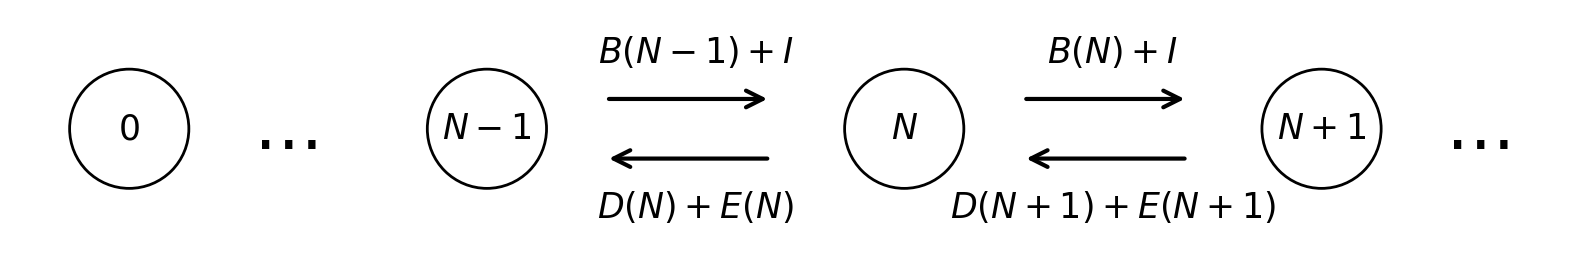

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


# create circle patches
circle0 = plt.Circle((0, 0), 1, edgecolor='black', linestyle='-', linewidth=2, fill=False)
circlenminus1 = plt.Circle((6, 0), 1, edgecolor='black', linestyle='-', linewidth=2, fill=False)
circlen = plt.Circle((13, 0), 1, edgecolor='black', linestyle='-', linewidth=2, fill=False)
circlenplus1 = plt.Circle((20, 0), 1, edgecolor='black', linestyle='-', linewidth=2, fill=False)

# create arrow patches
arrow1 = mpatches.FancyArrowPatch((8, 0.5), (10.75, 0.5), 
                                 arrowstyle='->', 
                                  mutation_scale=30, color='black', linewidth=3)
arrow2 = mpatches.FancyArrowPatch((10.75, -0.5), (8, -0.5), 
                                 arrowstyle='->', 
                                  mutation_scale=30, color='black', linewidth=3)
arrow3 = mpatches.FancyArrowPatch((15, 0.5), (17.75, 0.5), 
                                 arrowstyle='->', 
                                  mutation_scale=30, color='black', linewidth=3)
arrow4 = mpatches.FancyArrowPatch((17.75, -0.5), (15, -0.5), 
                                 arrowstyle='->', 
                                  mutation_scale=30, color='black', linewidth=3)

#create the figure
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(20)
fig.set_figheight(10)

# add circles
ax.add_patch(circle0)
ax.add_patch(circlenminus1)
ax.add_patch(circlen)
ax.add_patch(circlenplus1)

# add arrows
ax.add_patch(arrow1)
ax.add_patch(arrow2)
ax.add_patch(arrow3)
ax.add_patch(arrow4)

#add text on arrows
ax.text(9.5, 1, r'$B(N-1)+I$', fontsize=25, verticalalignment='bottom', horizontalalignment='center')
ax.text(16.5, 1, r'$B(N)+I$', fontsize=25, verticalalignment='bottom', horizontalalignment='center')
ax.text(9.5, -1, r'$D(N)+E(N)$', fontsize=25, verticalalignment='top', horizontalalignment='center')
ax.text(16.5, -1, r'$D(N+1)+E(N+1)$', fontsize=25, verticalalignment='top', horizontalalignment='center')

# add text
ax.text(0, 0, r'$0$', fontsize=25, verticalalignment='center', horizontalalignment='center')
ax.text(6, 0, r'$N-1$', fontsize=25, verticalalignment='center', horizontalalignment='center')
ax.text(13, 0, r'$N$', fontsize=25, verticalalignment='center', horizontalalignment='center')
ax.text(20, 0, r'$N+1$', fontsize=25, verticalalignment='center', horizontalalignment='center')
ax.text(22.5, 0, r'$\dots$', fontsize=50, verticalalignment='center', horizontalalignment='center')
ax.text(2.5, 0, r'$\dots$', fontsize=50, verticalalignment='center', horizontalalignment='center')

# set graphical parameters
ax.set_xlim(-2, 24)
ax.set_ylim(-2, 2)
ax.set_aspect('equal')
ax.axis('off')

# save the plot
plt.savefig(f'{fig_path}\\fig2.pdf', bbox_inches='tight', pad_inches=0.1)

## Deterministic open system model

### Fig. 1

Get deterministic model bifurcation data.

In [18]:
m_values_deterministic = np.logspace(-3, 0, 1000)

initial_guesses = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60]

higher_stable_pts = np.full(len(m_values_deterministic), np.nan)
lower_stable_pts = np.full(len(m_values_deterministic), np.nan)
unstable_pts = np.full(len(m_values_deterministic), np.nan)

for i, m in enumerate(m_values_deterministic):
    equilibrim_points = find_equilibrium_points(m, initial_guesses)
    stable_points, unstable_points = check_stability(equilibrim_points, m)

    higher_stable_pts[i] = max(stable_points)

    if len(stable_points) == 2:
        lower_stable_pts[i] = min(stable_points)
        unstable_pts[i] = unstable_points[0]

Also create a 2D bifurcation diagram for the deterministic open system model. The following block of code may take up to several minutes to run.

In [19]:
m_values = np.logspace(-4, 2, 500)
A_values = np.linspace(1e-3, 15, 500)

r=1
K=50
a=10
NR=50

deterministic_unstable_point = np.full((len(m_values), len(A_values)), 0.0)
deterministic_sink = np.full((len(m_values), len(A_values)), np.nan)

for i, m in enumerate(m_values):
    for j, A in enumerate(A_values):
        equilibria = find_equilibrium_points(m=m, initial_guesses=np.concatenate((np.linspace(0, A, 10), [50])),
                                             c=c(r), rho=rho(r, a, A, K), a=a, alpha=alpha(r, a, A, K), NR=NR)
        stable_points, unstable_points = check_stability(equilibria, m=m,
                                                          c=c(r), rho=rho(r, a, A, K), a=a, alpha=alpha(r, a, A, K))

        if len(unstable_points)>0:
            deterministic_unstable_point[i, j] = unstable_points[0]
        if len(stable_points)==2:
            deterministic_sink[i, j] = np.min(stable_points)


data0 = pd.DataFrame(deterministic_unstable_point, index=m_values, columns=A_values)
data1 = pd.DataFrame(deterministic_sink, index=m_values, columns=A_values)

data0.to_csv(f'{data_path}\\deterministic_unstable_point.csv')
data1.to_csv(f'{data_path}\\deterministic_sink.csv')

Draw the figure for the deterministic open system model.

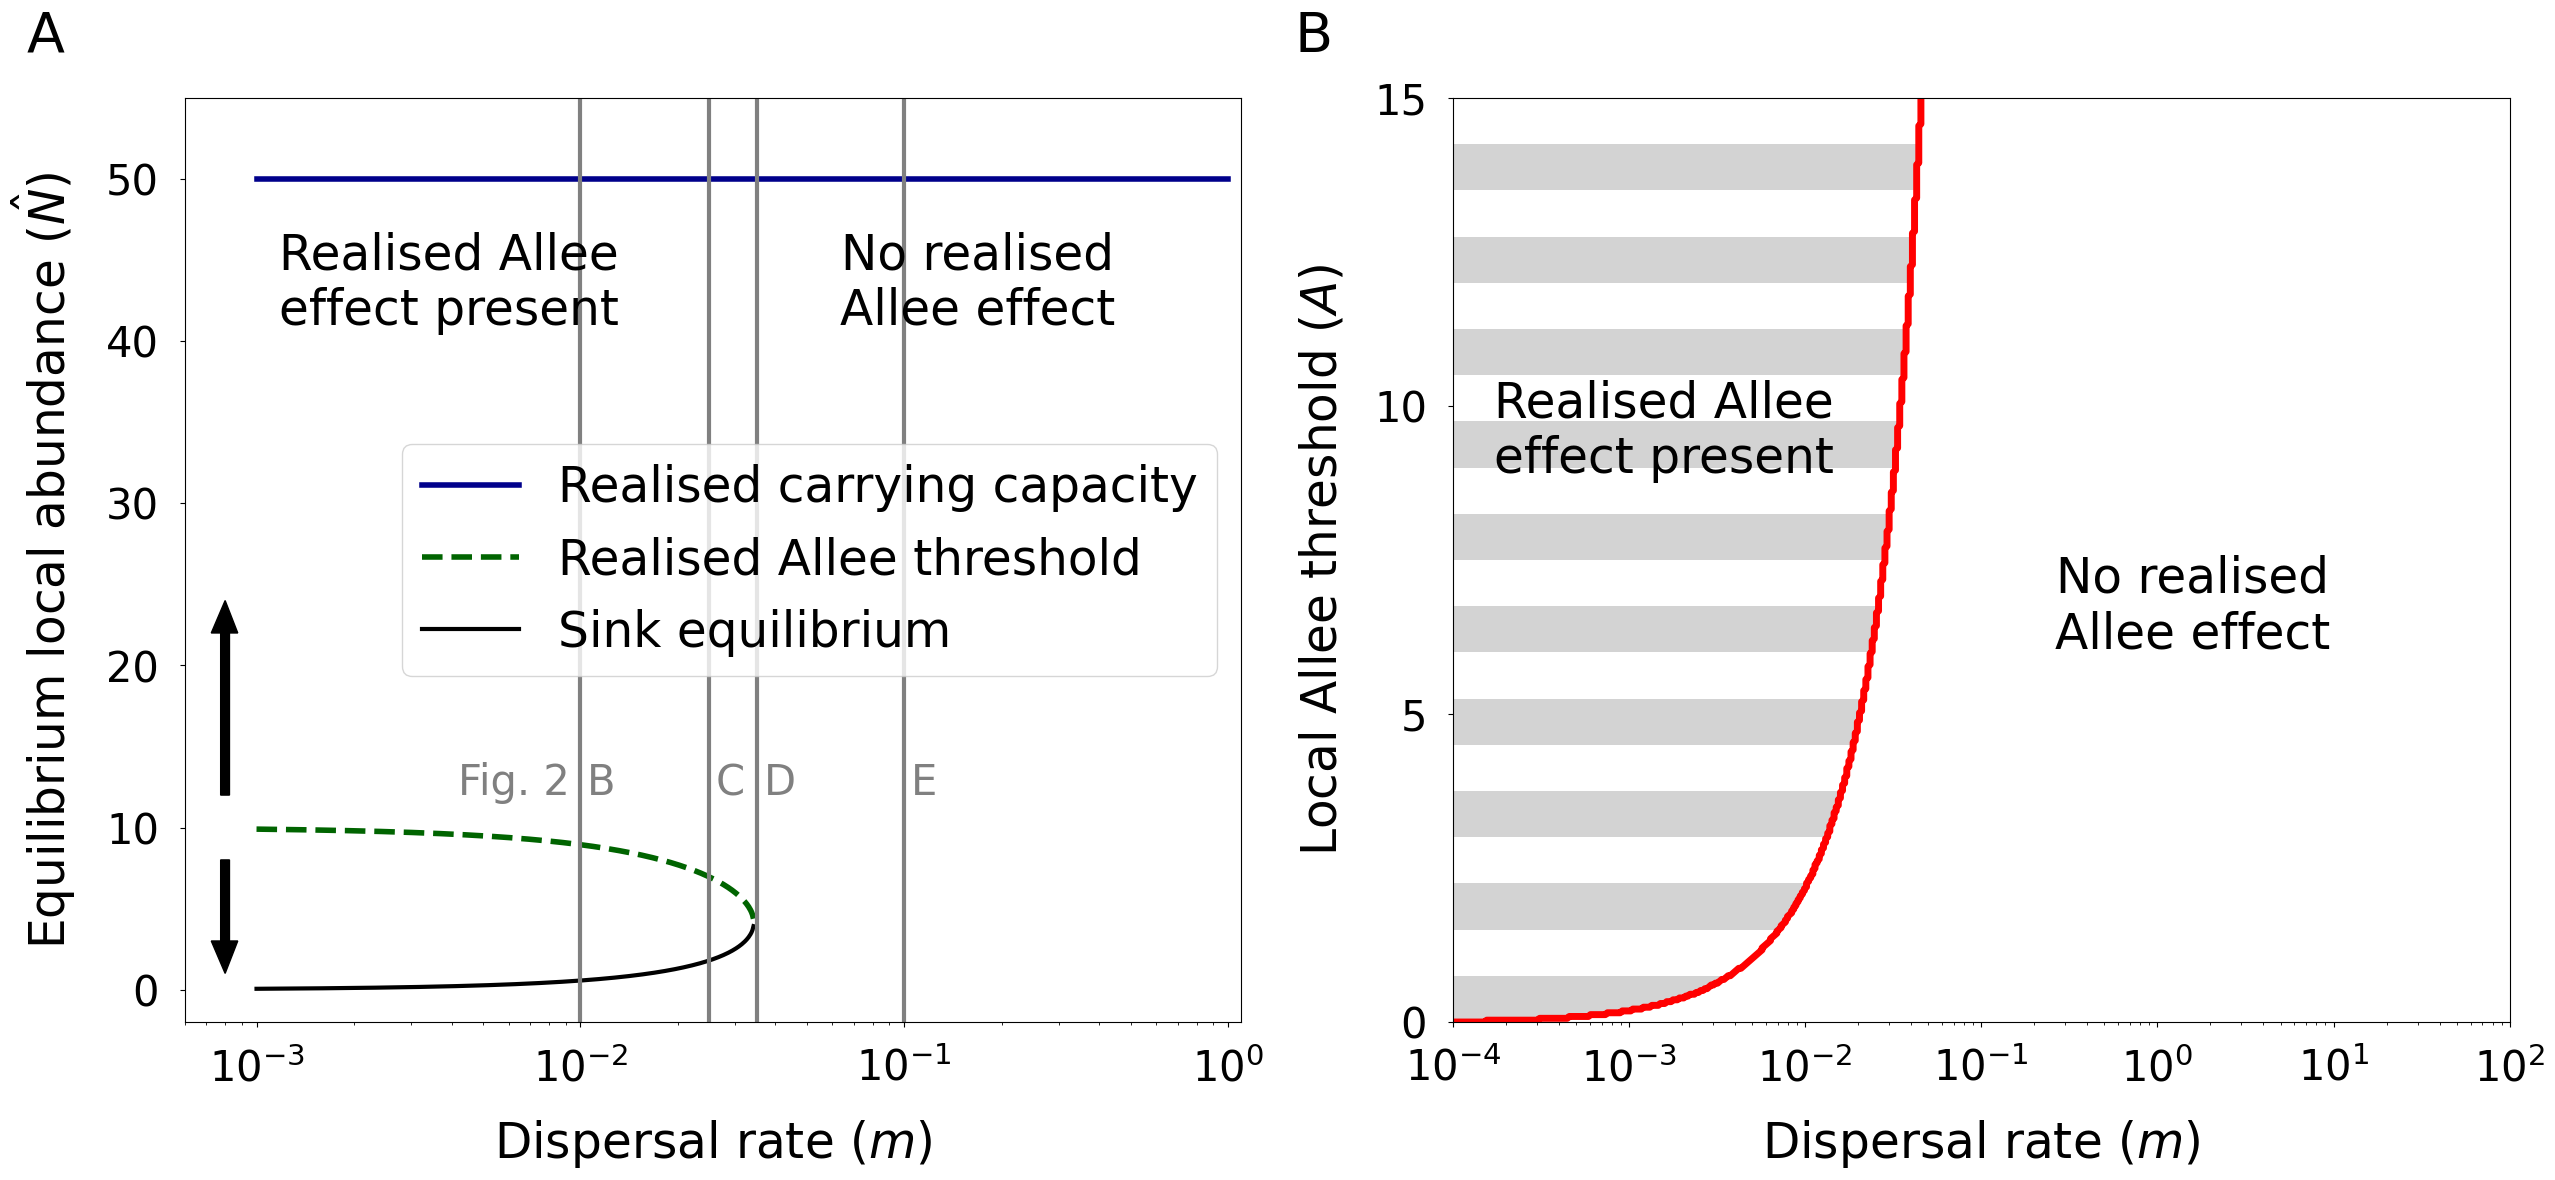

In [21]:
deterministic_data = pd.read_csv(f'{data_path}\\deterministic_unstable_point.csv', index_col=0)


fig, ax = plt.subplots(1, 2, figsize=(30, 12))
ax0, ax1 = ax

m_values_to_mark = [0.01, 0.025, 0.035, 0.1]
plot_labels = ['B', 'C', 'D', 'E']


# for i in np.arange(0, 1, 0.1):
#     ax0.fill([0, 0.54, 0.54, 0], [i, i, i+0.05, i+0.05], 'lightgrey', transform=ax0.transAxes)


# plot the deterministic bifurcation diagram
ax0.plot(m_values_deterministic, higher_stable_pts, label=r'Realised carrying capacity', color='darkblue', linewidth=4)
ax0.plot(m_values_deterministic[0:len(unstable_pts)], unstable_pts, label=r'Realised Allee threshold', color='darkgreen', linestyle='dashed', linewidth=4)
ax0.plot(m_values_deterministic[0:len(lower_stable_pts)], lower_stable_pts, label=r'Sink equilibrium', color='black', linewidth=3)
ax0.set_xscale('log')
ax0.set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=20)
ax0.set_ylabel(r'Equilibrium local abundance ($\hat{N}$)', fontsize=35, labelpad=20)
ax0.tick_params(labelsize=30, pad=15)
ax0.set_xticks(ticks = 10**np.arange(-3.0, 1.0), labels=[r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$10^{0}$'])
ax0.legend(fontsize=35)
ax0.set_xlim(6e-4, 1.1)
ax0.set_ylim(-2, 55)
ax0.text(-0.15, 1.05, 'A', fontsize=40, transform=ax0.transAxes)
ax0.text(0.0042, 12, 'Fig. 2', fontsize=30, color='grey')
ax0.arrow(8e-4, 12, 0, 10, width=5e-5, head_length=2, fc='black', ec='black')
ax0.arrow(8e-4, 8, 0, -5, width=5e-5, head_length=2, fc='black', ec='black')
ax0.text(0.25, 0.8, 'Realised Allee\neffect present', fontsize=35, transform=ax0.transAxes, ha='center', va='center')
ax0.text(0.75, 0.8, 'No realised\nAllee effect', fontsize=35, transform=ax0.transAxes, ha='center', va='center')

for i, m in enumerate(m_values_to_mark):
    ax0.axvline(x=m, color='grey', lw=3)
    ax0.text(1.05*m, 12, plot_labels[i], fontsize=30, ha='left', color='grey')


m_values = deterministic_data.index.to_numpy()
A_values = deterministic_data.columns.to_numpy()

for i in np.arange(0, 1, 0.1):
    ax1.fill([0, 1, 1, 0], [i, i, i+0.05, i+0.05], 'lightgrey', transform=ax1.transAxes)

ax1.contour(m_values, A_values, deterministic_data.to_numpy().T, levels=[0.0], colors='red', linewidths=5)
ax1.contourf(m_values, A_values, deterministic_data.to_numpy().T, levels=[-1, 0], colors='white')
ax1.set_xscale('log')
ax1.set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=20)
ax1.set_ylabel(r'Local Allee threshold ($A$)', fontsize=35, labelpad=20)
ax1.tick_params(which='major', labelsize=30, pad=15)
ax1.text(-0.15, 1.05, 'B', fontsize=40, transform=ax1.transAxes)
ax1.set_yticks(ticks=np.linspace(0, len(A_values)-1, 4), labels=np.linspace(0, 15, 4, dtype=int))
ax1.text(0.2, 0.64, 'Realised Allee\neffect present', fontsize=35, transform=ax1.transAxes, ha='center', va='center')
ax1.text(0.7, 0.45, 'No realised\nAllee effect', fontsize=35, transform=ax1.transAxes, ha='center', va='center')


plt.savefig(f'{fig_path}\\fig1.pdf', bbox_inches='tight', pad_inches=0.1)


## Stochastic open system model

### Fig. 3

Calculate the the number of peaks in the stationary distribution as a function of the Allee threshold and the dispersal rate. The following block of code may take up to several minutes to run.

In [22]:
m_values = np.logspace(-4, 2, 200)
A_values = np.linspace(1e-3, 15, 200)

peak_nums = np.full((len(m_values), len(A_values)), np.nan)

large_peaks = np.full((len(m_values), len(A_values)), np.nan)
small_peaks = np.full((len(m_values), len(A_values)), np.nan)

for i, m in enumerate(m_values):
    for j, A in enumerate(A_values):
        distribution = gaussian_filter(get_stationary_distribution(m=m, A=A, r=1, K=50, a=10, NR=50, x=0.0, survivor_frac=1.0), 2)
        peak_num = 0

        for k, point in enumerate(distribution):
            if k==0 and distribution[k] > distribution[k+1]:
                small_peaks[i, j] = k
                peak_num += 1
            elif k==100 and distribution[k] > distribution[k-1]:
                peak_num +=1
                large_peaks[i, j] = k
            elif distribution[k-1] < distribution[k] and distribution[k] > distribution[k+1]:
                peak_num += 1
                if k > A:
                    large_peaks[i, j] = k
                else:
                    small_peaks[i, j] = k

        peak_nums[i, j] = peak_num
            
data = pd.DataFrame(peak_nums, index=m_values, columns=A_values)
data.to_csv(f'{data_path}\\stochastic_open_peak_nums.csv')
data = pd.DataFrame(large_peaks, index=m_values, columns=A_values)
data.to_csv(f'{data_path}\\stochastic_open_large_peaks.csv')
data = pd.DataFrame(small_peaks, index=m_values, columns=A_values)
data.to_csv(f'{data_path}\\stochastic_open_small_peaks.csv')

Perform Gillespie simulations and draw the figure. The following block of code may take up to a minute to run.

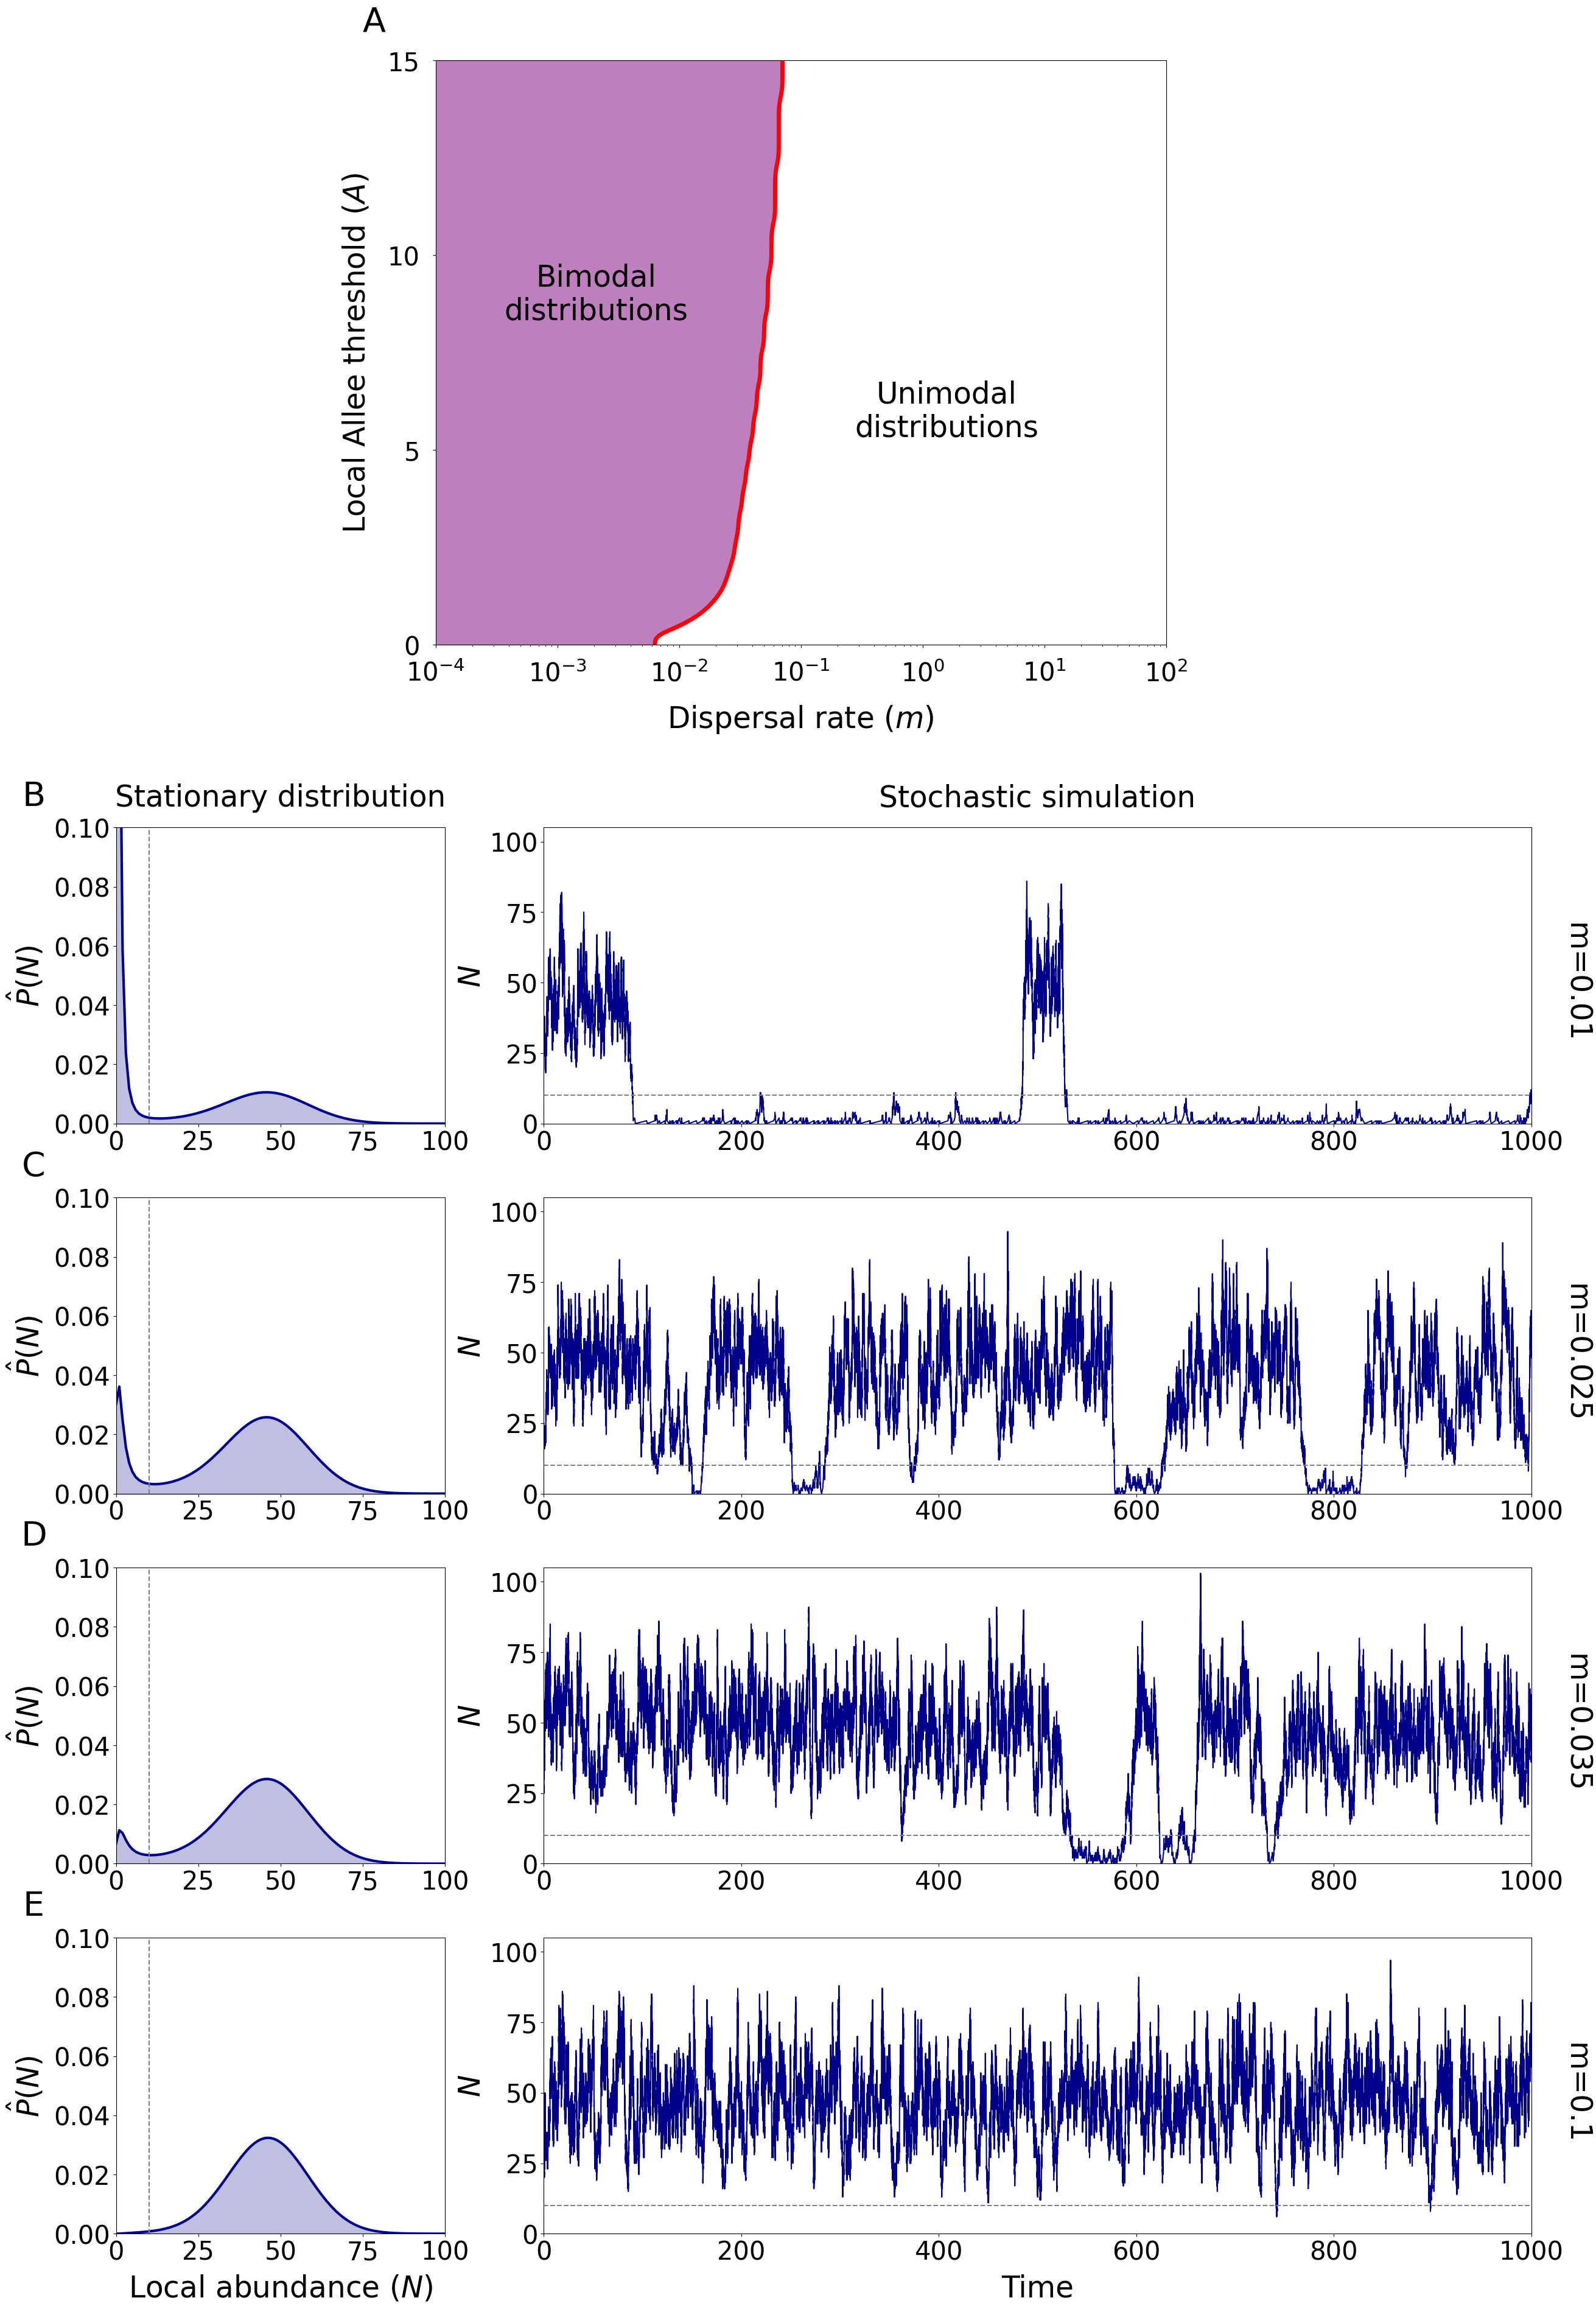

In [23]:
fig, ax = plt.subplots(4, 2, figsize=(30, 30), width_ratios=[1, 3])

m_values_gillespie = [0.01, 0.025, 0.035, 0.1]
plot_labels = ['B', 'C', 'D', 'E']
A = 10

K = 50
a = 10
r = 1
x = 0.0

NR = 50.0

# plot the 2D diagram showing modality of the stationary distribution
axis_2d = fig.add_axes((0.3, 0.98, 0.4, 0.32))

stochastic_data = pd.read_csv(f'{data_path}\\stochastic_open_peak_nums.csv', index_col=0)

m_values = stochastic_data.index.to_numpy()
A_values = stochastic_data.columns.to_numpy()
peak_nums = gaussian_filter(stochastic_data.to_numpy(), 2.5)

axis_2d.contour(m_values, A_values, peak_nums.T, levels=[1.5], colors='red', linewidths=5)
axis_2d.contourf(m_values, A_values, peak_nums.T, levels=[1.5, 2], colors='purple', alpha=0.5)
axis_2d.set_xscale('log')
axis_2d.set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=20)
axis_2d.set_ylabel(r'Local Allee threshold ($A$)', fontsize=35, labelpad=20)
axis_2d.tick_params(labelsize=30, pad=15)
axis_2d.set_yticks(ticks=np.linspace(0, len(A_values)-1, 4), labels=np.linspace(0, 15, 4, dtype=int))
axis_2d.text(-0.1, 1.05, 'A', fontsize=40, transform=axis_2d.transAxes)
axis_2d.text(0.22, 0.6, 'Bimodal\ndistributions', fontsize=35, transform=axis_2d.transAxes, ha='center', va='center')
axis_2d.text(0.7, 0.4, 'Unimodal\ndistributions', fontsize=35, transform=axis_2d.transAxes, ha='center', va='center')

times = []
pops = []
distris = []

seeds = [43, 69, 1729, 314]

for i, m in enumerate(m_values_gillespie):

    eq_distribution = get_stationary_distribution(m=m, A=A, r=r, K=K, a=a, NR=NR, x=x, survivor_frac=1.0)
    time, population = gillespie_simulation(initial=25, duration=1000, m=m, A=A, r=r, K=K, a=a, x=x, NR=NR, rngseed=seeds[i])
    times.append(time)
    pops.append(population)
    distris.append(eq_distribution)

    ax[i, 0].plot(np.arange(0, 2*K+1, 1), distris[i], color='darkblue', linewidth=3)
    ax[i, 0].vlines(x=A, ymin=0, ymax=0.1, colors='grey', linestyles='dashed')
    ax[i, 0].fill_between(np.arange(0, 2*K+1, 1), distris[i], color='darkblue', alpha=0.25)
    ax[i, 0].set_xlim(0, 100)
    ax[i, 0].set_ylim(0., 0.1)
    ax[i, 0].tick_params(labelsize=30)
    ax[i, 0].set_ylabel(r'$\hat{P}(N)$', fontsize=35, labelpad=10)
    ax[i, 0].set_position([0.125, 0.12*(len(m_values_gillespie)-i), 0.2, 0.1])
    ax[i, 0].text(-0.25, 1.05, plot_labels[i], horizontalalignment='center', verticalalignment='bottom', fontsize=40, transform=ax[i, 0].transAxes)

    ax[i, 1].plot(times[i], pops[i], color='darkblue')
    ax[i, 1].set_xlim(0, 1000)
    ax[i, 1].set_ylim(0, 105)
    ax[i, 1].hlines(y=A, xmin=0, xmax=1000, colors='grey', linestyles='dashed')
    ax[i, 1].text(1060, 50, f'm={m}', horizontalalignment='right', verticalalignment='center', rotation=270, fontsize=35)
    ax[i, 1].tick_params(labelsize=30)
    ax[i, 1].set_ylabel(r'$N$', fontsize=35)
    ax[i, 1].set_position([0.4, 0.12*(len(m_values_gillespie)-i), 0.5, 0.1])


ax[0, 0].set_title('Stationary distribution', fontsize=35, pad=25)
ax[0, 1].set_title('Stochastic simulation', fontsize=35, pad=25)
ax[3, 0].set_xlabel(r'Local abundance ($N$)', fontsize=35, labelpad=10)
ax[3, 1].set_xlabel('Time', fontsize=35, labelpad=10)

fig.subplots_adjust(hspace=0.25, wspace=0.15)

plt.savefig(f'{fig_path}\\fig3.pdf', bbox_inches='tight', pad_inches=0.1)

## Metapopulation model

### Fig. 4

Create an illustration of regional Allee effects in a metapopulation with finitely many ($10$) patches, with a local Allee threshold of $15$. The following block of code may take up to a few minutes to to run.

In [37]:
# with sufficient initial abundance (4 patches with 50 individuals, 6 empty patches)
times0, populations0 = gillespie_finite_patches(np.concatenate((np.full(4, 50), np.full(6, 0))), 100, m=0.2, A=15, r=1, a=10, K=50,
                                  n_patch=10, rngseed=42)
populations0 = recover_full_data(populations0)

# with sufficient initial abundance (4 patches with 50 individuals, 6 empty patches)
times1, populations1 = gillespie_finite_patches(np.concatenate((np.full(2, 50), np.full(8, 0))), 100, m=0.2, A=15, r=1, a=10, K=50,
                                  n_patch=10, rngseed=40)
populations1 = recover_full_data(populations1)

Draw the figure.

Text(0.5, 1.0, 'Insufficient initial regional abundance')

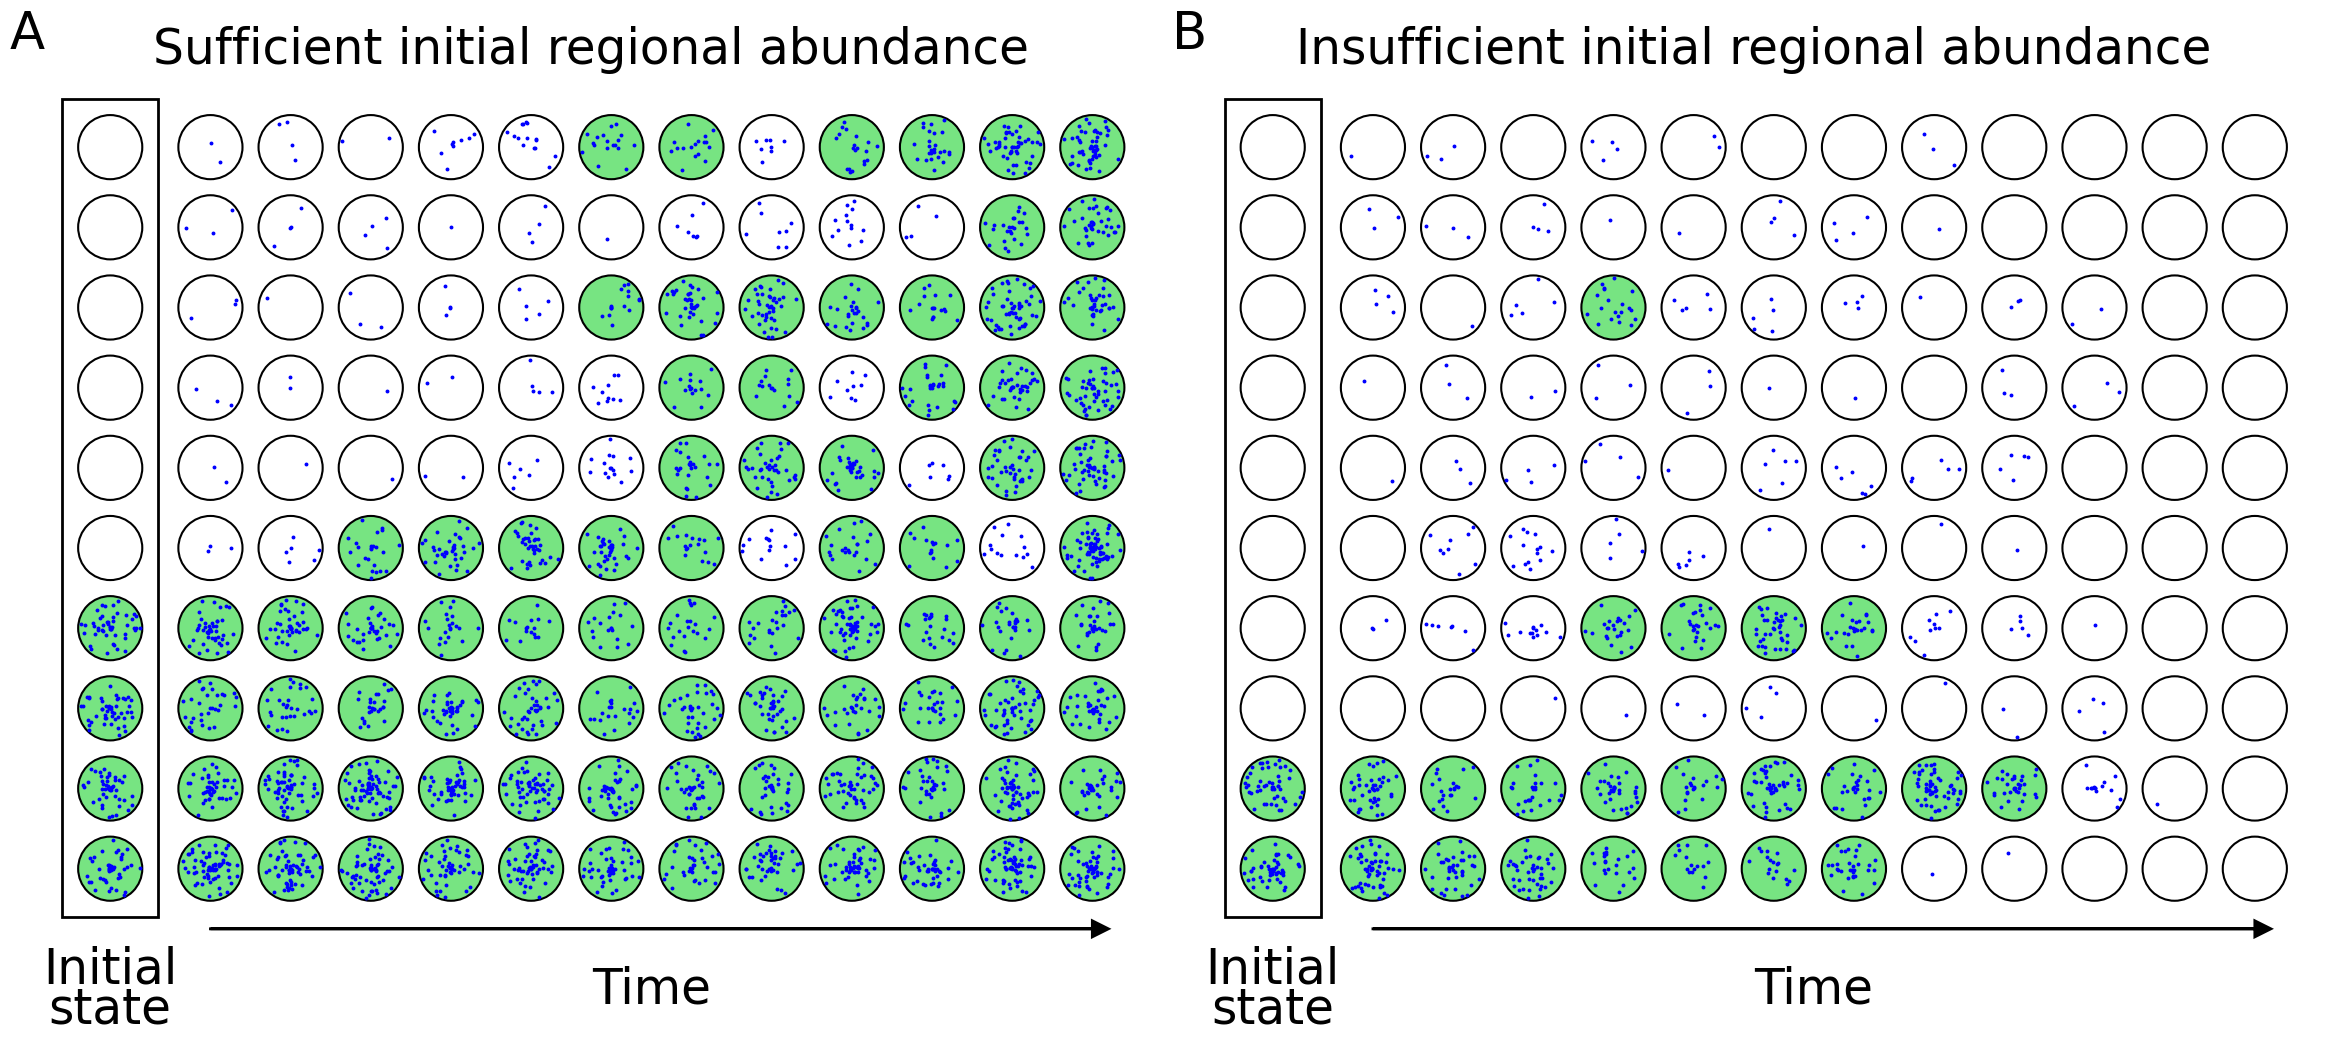

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(30, 15), gridspec_kw={'wspace': 0})
ax0, ax1 = ax

labels = ['A', 'B']

rng = np.random.default_rng(seed=69)

time_point_num = 13

time_points0 = np.concatenate(([0], np.logspace(0, np.log10(50), time_point_num-1)))
indices_to_plot0 = np.full_like(time_points0, 0, dtype=int)
time_points1 = [0, 1, 4, 6, 10, 11, 15, 18, 24, 27, 29, 32, 35]
indices_to_plot1 = np.full_like(time_points1, 0, dtype=int)

for i, t in enumerate(time_points0):
    indices_to_plot0[i] = np.argmin(np.abs(times0 - t))

for i, t in enumerate(time_points1):
    indices_to_plot1[i] = np.argmin(np.abs(times1 - t))

local_abundances0 = populations0[indices_to_plot0, :]
local_abundances1 = populations1[indices_to_plot1, :]

offsets = np.zeros(time_point_num)
offsets[0] = -0.25

fill_cols = ['white', "#59de66d1"]

for i in range(time_point_num):
    for j in range(10):
        fill_col0 = fill_cols[int(local_abundances0[i, j] > 15)]
        fill_col1 = fill_cols[int(local_abundances1[i, j] > 15)]

        circle0 = plt.Circle((i+offsets[i], j), 0.4, color='k', fc=fill_col0, linewidth=1.5)
        circle1 = plt.Circle((i+offsets[i], j), 0.4, color='k', fc=fill_col1, linewidth=1.5)
        ax0.add_patch(circle0)
        ax1.add_patch(circle1)



for i in range(time_point_num):
    for j in range(10):
        radius_values0 = rng.uniform(-0.375, 0.375, np.sum(local_abundances0[i, j]).astype(int))
        angles0 = rng.uniform(0, 2*np.pi, np.sum(local_abundances0[i, j]).astype(int))
        ax0.plot(offsets[i] + i + radius_values0*np.cos(angles0), j + radius_values0*np.sin(angles0), 'o', color = 'blue', markersize=1.8)

        radius_values1 = rng.uniform(-0.375, 0.375, np.sum(local_abundances1[i, j]).astype(int))
        angles1 = rng.uniform(0, 2*np.pi, np.sum(local_abundances1[i, j]).astype(int))
        ax1.plot(offsets[i] + i + radius_values1*np.cos(angles1), j + radius_values1*np.sin(angles1), 'o', color = 'blue', markersize=1.8)


for i in range(2):
    ax[i].set_xlim(-1.5, time_point_num)
    ax[i].set_ylim(-1, 9.7)
    ax[i].set_aspect('equal')
    rect = plt.Rectangle([-0.85, -0.6], 1.2, 10.2, linewidth=2, ec='k', fill=None)
    ax[i].add_patch(rect)
    ax[i].text(-0.25, -1.25, 'Initial', fontsize=35, ha='center', va='center')
    ax[i].text(-0.25, -1.75, 'state', fontsize=35, ha='center', va='center')
    ax[i].text(6.5, -1.5, 'Time', fontsize=35, ha='center', va='center')
    ax[i].arrow(1, -0.75, time_point_num-2, 0, lw=2, head_length=0.2, head_width=0.2, ec='k', fc='k')
    ax[i].text(0, 1.05, labels[i], fontsize=37, transform=ax[i].transAxes)
    ax[i].axis('off')

ax0.set_title('Sufficient initial regional abundance', fontsize=35, pad=20)
ax1.set_title('Insufficient initial regional abundance', fontsize=35, pad=20)

plt.savefig(f'{fig_path}\\fig4.pdf', bbox_inches='tight', pad_inches=0.1)


### Fig. 5

Obtain the bifurcation diagrams w.r.t. dispersal rate for specific values of the local Allee threshold. The following block of code may take up to several minutes to run.

In [33]:
A_values = [5, 7, 8, 25]

for A in A_values:
    m_min = bisection_method(A=A, r=1.0, K=50, a=10.0, x=0.0, survivor_frac=1.0, tofind='min', limits=[1e-4, 10])
    m_values = np.concatenate((np.logspace(np.log10(m_min), 0, 175, endpoint=False), np.logspace(0, 4, 50)))

    m_values, regional_thresholds, carrying_capacities, zero_stability = get_bifurcation_data(A=A, 
                                                                                            m_values=m_values, 
                                                                                            r=1.0, K=50, a=10.0, 
                                                                                            x=0.0, survivor_frac=1.0)
    data = pd.DataFrame({'m': m_values, 
                        'A_R': regional_thresholds, 
                        'K_R': carrying_capacities, 
                        'zero_vals': zero_stability})
    data.to_csv(f'{data_path}\\metapopulation_bifurcation_A={A}_r=1_K=50_a=10_x=0_survivor_frac=1.0.csv', index=False)

Two-dimensional bifurcation diagrams w.r.t. dispersal rate ($m$) and local Allee threshold ($A$). The following block of code may take up to several hours to run.

In [ ]:
import pandas as pd

A_values = np.linspace(0.01, 15, 200)
m_values = np.logspace(-4, 2, 100)

# obtain the list of minimum m values for each A value
m_min_values = np.full(len(A_values), np.nan)
for i, A in enumerate(A_values):
    m_min_values[i] = bisection_method(A=A, r=1.0, K=50, a=10.0, x=0.0, survivor_frac=1.0, tofind='min', limits=[1e-4, 1.0])

# create a list of m values that contains m_min for every A_value 
m_values_final = np.sort(np.concatenate((m_values, m_min_values[np.isnan(m_min_values)==False])))

KR_data_2d = np.full((len(m_values_final), len(A_values)), np.nan)
AR_data_2d = np.full((len(m_values_final), len(A_values)), np.nan)

for i, A in enumerate(A_values):
    if np.isnan(m_min_values[i]):
        m_values_new, regional_thresholds, carrying_capacities, zero_vals = get_bifurcation_data(A=A, m_values=m_values_final,
                                                                                                r=1.0, K=50, a=10.0, x=0.0, survivor_frac=1.0)
    else:
        m_values_relevant = m_values_final[m_values_final > m_min_values[i]]
        m_values_new, regional_thresholds, carrying_capacities, zero_vals = get_bifurcation_data(A=A, m_values=m_values_relevant,
                                                                                                r=1.0, K=50, a=10.0, x=0.0, survivor_frac=1.0)

        regional_thresholds = np.concatenate((np.full(len(m_values_final)-len(regional_thresholds), np.nan), regional_thresholds))
        carrying_capacities = np.concatenate((np.full(len(m_values_final)-len(carrying_capacities), 0.0), carrying_capacities))

    AR_data_2d[:, i] = regional_thresholds
    KR_data_2d[:, i] = carrying_capacities


# save the data as a csv file
data_AR = pd.DataFrame(AR_data_2d, columns=A_values, index=m_values_final)
data_AR.to_csv(f'{data_path}\\AR_data_r=1_K=50_a=10_x=0_survivor_frac=1.csv')

data_KR = pd.DataFrame(KR_data_2d, columns=A_values, index=m_values_final)
data_KR.to_csv(f'{data_path}\\KR_data_r=1_K=50_a=10_x=0_survivor_frac=1.csv')

Calculate the number of peaks in the equilibrium distributions in the metapopulation model. The following block of code may take up to several minutes to run.

In [37]:
metapopulation_data_KR = pd.read_csv(f'{data_path}\\KR_data_r=1_K=50_a=10_x=0_survivor_frac=1.csv', index_col=0)
m_values = metapopulation_data_KR.index.to_numpy(dtype=float)
A_values = metapopulation_data_KR.columns.to_numpy(dtype=float)

peak_nums_metapopulation = np.full_like(metapopulation_data_KR.to_numpy(), np.nan)

for i, m in enumerate(m_values):
    for j, A in enumerate(A_values):
        KR = metapopulation_data_KR.iloc[i, j]
        if KR > 0.01:
            distribution = gaussian_filter(get_stationary_distribution(m=m, A=A, r=1, K=50, a=10, 
                                        NR=KR, x=0.0, survivor_frac=1.0), 5)
            peak_num = 0

            for k, point in enumerate(distribution):
                if k==0 and distribution[k] > distribution[k+1]:
                    if distribution[k] > 1e-4:
                        peak_num += 1
                elif distribution[k-1] < distribution[k] and distribution[k] > distribution[k+1]:
                    peak_num += 1

        else:
            peak_num = 0

        peak_nums_metapopulation[i, j] = peak_num
        
    
df = pd.DataFrame(peak_nums_metapopulation, index=m_values, columns=A_values)
df.to_csv(f'{data_path}\\metapopulation_peak_nums.csv')

Draw the figure.

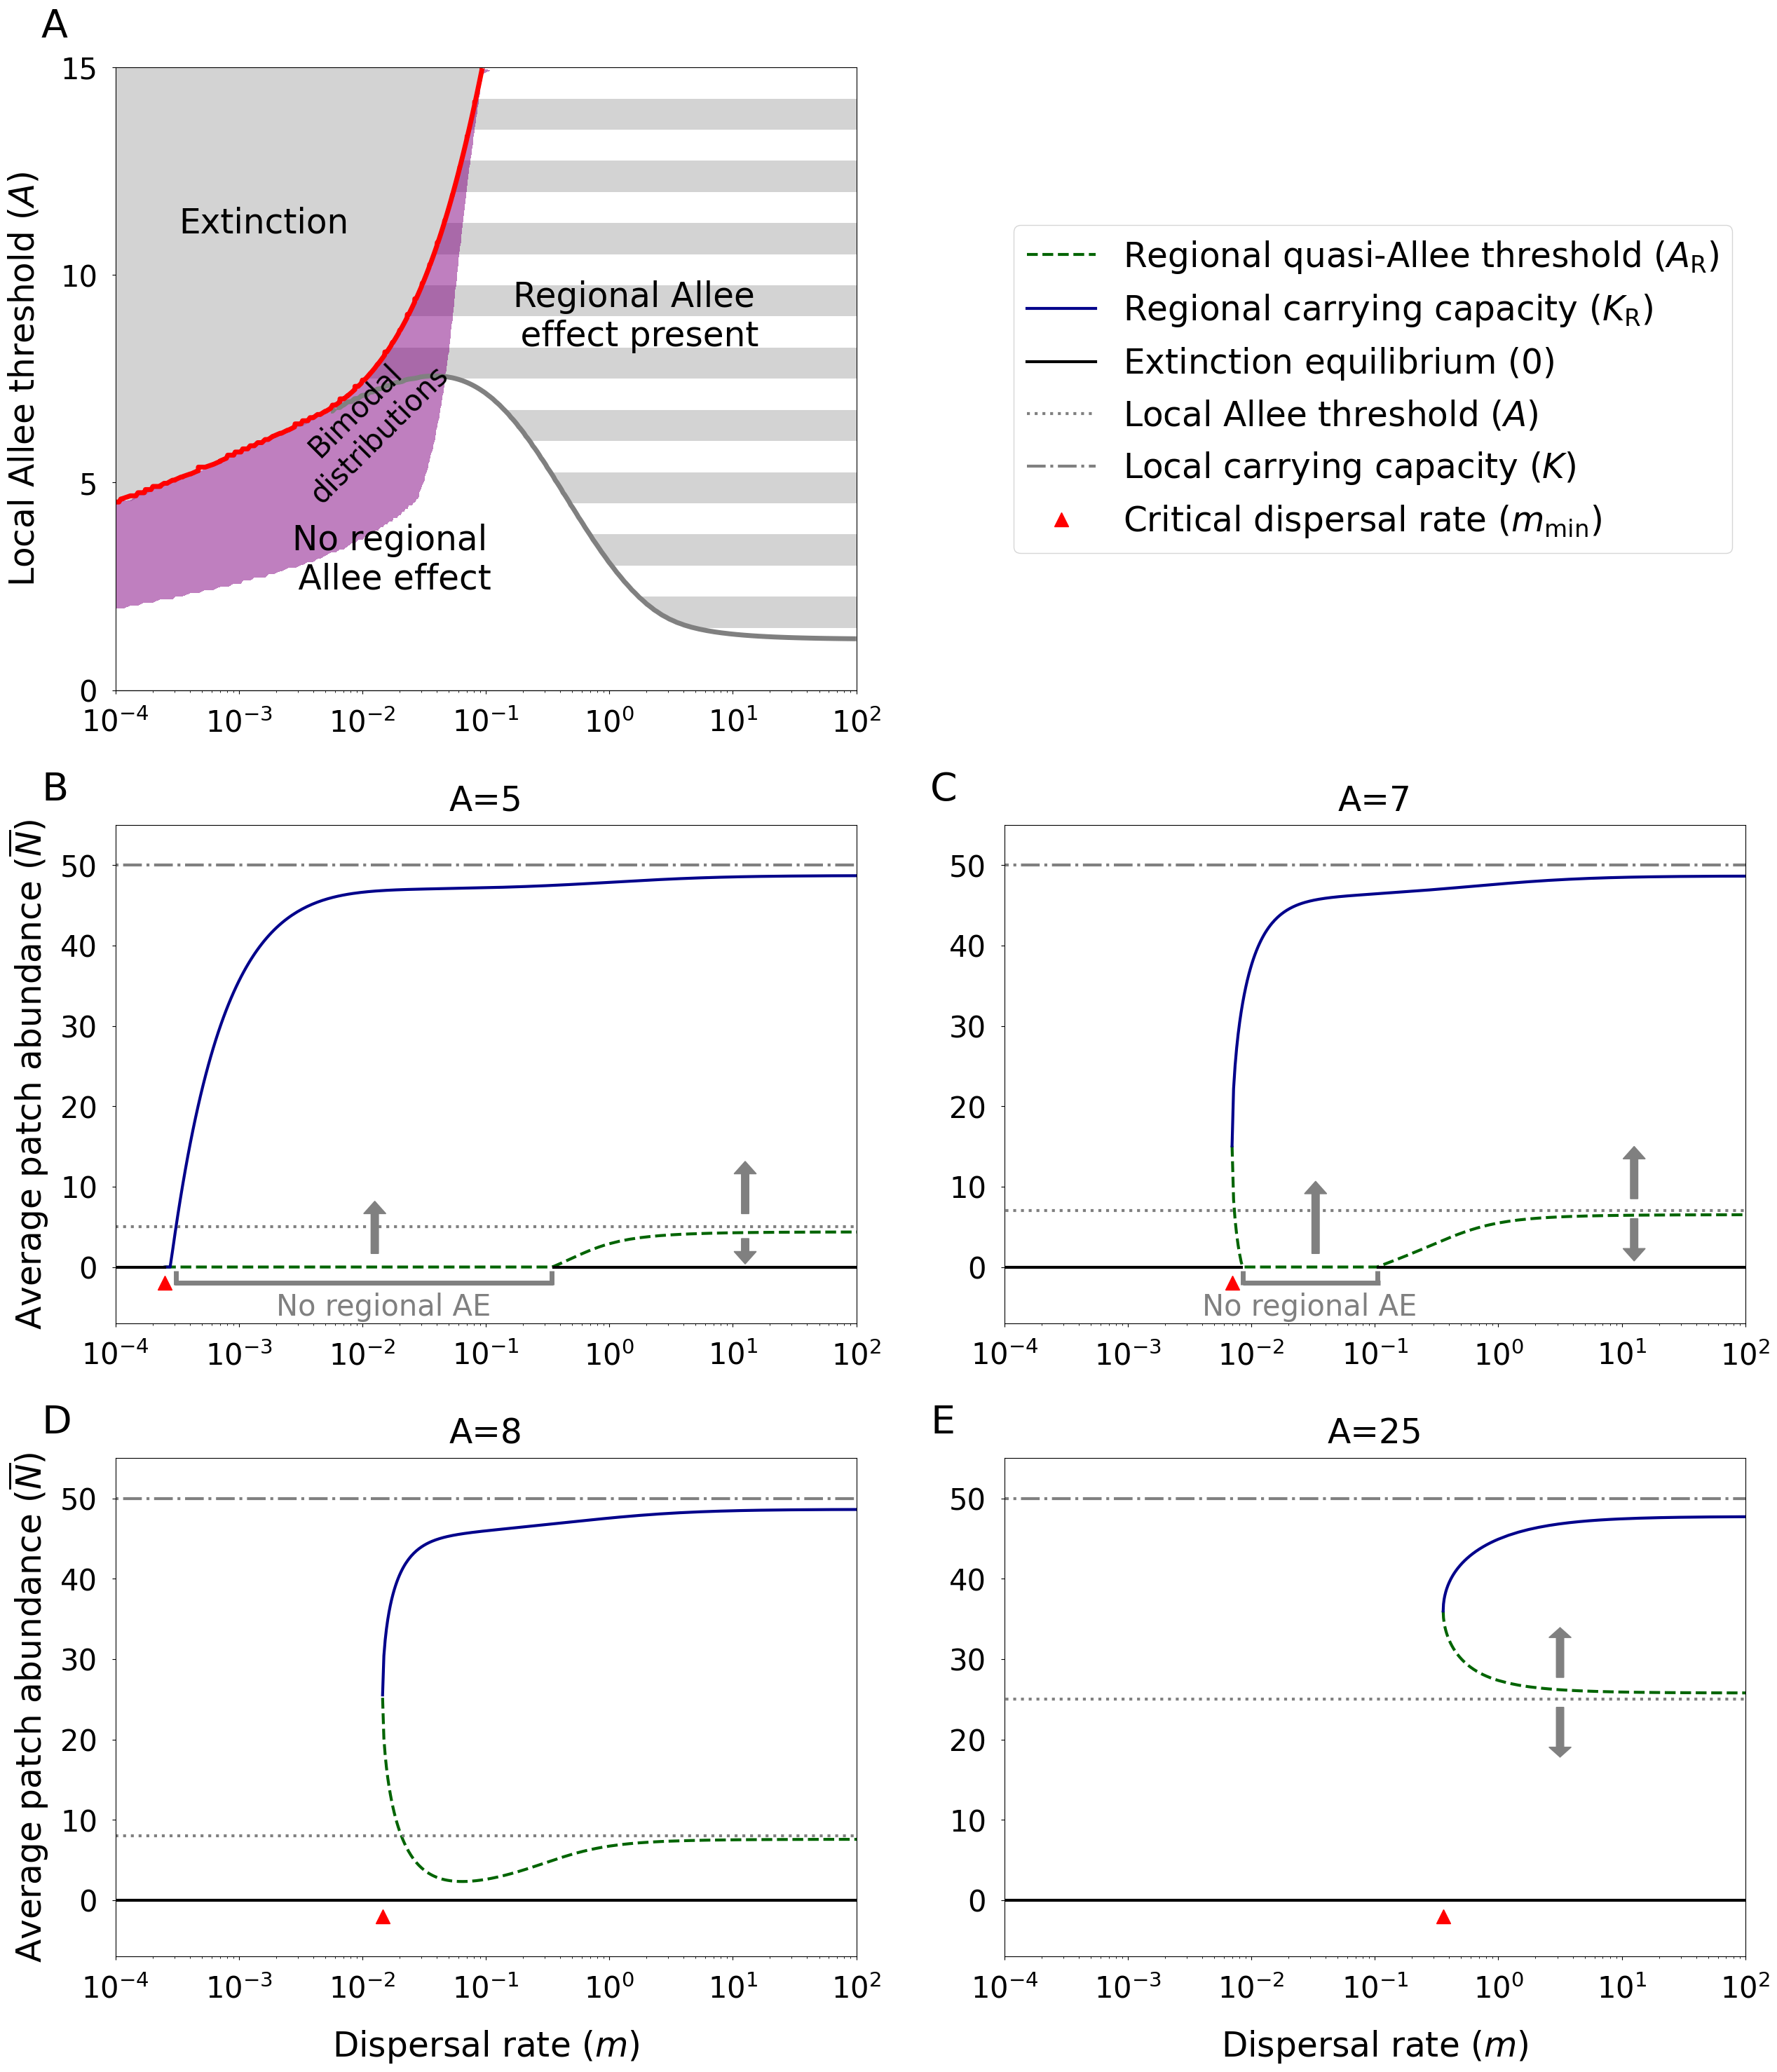

In [40]:
fig, ax = plt.subplots(3, 2, height_ratios=[1.25, 1, 1], width_ratios=[1, 1], gridspec_kw={'hspace':0.25})
fig.set_figheight(35)
fig.set_figwidth(30)

# plot the 2D bifurcation diagram
metapopulation_data_AR = pd.read_csv(f'{data_path}\\AR_data_r=1_K=50_a=10_x=0_survivor_frac=1.csv', index_col=0)
metapopulation_data_KR = pd.read_csv(f'{data_path}\\KR_data_r=1_K=50_a=10_x=0_survivor_frac=1.csv', index_col=0)
metapopulation_data_peak_num = pd.read_csv(f'{data_path}\\metapopulation_peak_nums.csv', index_col=0)

m_values = metapopulation_data_AR.index.to_numpy(dtype=float)
A_values = metapopulation_data_AR.columns.to_numpy(dtype=float)

# add strips to represent bistability; other things are plotted on top of them
for i in np.arange(0, 1, 0.1):
    ax[0, 0].fill([0, 1, 1, 0], [i, i, i+0.05, i+0.05], 'lightgrey', transform=ax[0, 0].transAxes)

ax[0, 0].contour(m_values[m_values>5e-3], A_values, metapopulation_data_AR.to_numpy().T[:, m_values>5e-3], 
            levels=[0.25], colors='grey', linewidths=5)

ax[0, 0].contourf(m_values, A_values, metapopulation_data_AR.to_numpy().T, 
            levels=[0, 0.25], colors=['white'])

ax[0, 0].contour(m_values, A_values, metapopulation_data_KR.to_numpy().T, levels=[1e-4], colors='red', linewidths=5)
ax[0, 0].contourf(m_values, A_values, metapopulation_data_KR.to_numpy().T, levels=[0, 1e-4], colors='lightgrey')

ax[0, 0].contourf(m_values, A_values, metapopulation_data_peak_num.to_numpy().T, levels=[1, 2], colors='purple', alpha=0.5)
ax[0, 0].set_xscale('log')
#ax[0, 0].set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=20)
ax[0, 0].set_ylabel(r'Local Allee threshold ($A$)', fontsize=35, labelpad=20)
ax[0, 0].tick_params(labelsize=30, pad=15)

ax[0, 0].set_yticks(ticks=np.linspace(0, 15, 4, dtype=int), labels=np.linspace(0, 15, 4, dtype=int))
ax[0, 0].set_ylim(0, 15)
ax[0, 0].text(-0.1, 1.05, 'A', fontsize=40, transform=ax[0, 0].transAxes)
ax[0, 0].text(0.2, 0.75, 'Extinction', fontsize=35, transform=ax[0, 0].transAxes, ha='center', va='center')
ax[0, 0].text(0.37, 0.21, 'No regional\n Allee effect', fontsize=35, transform=ax[0, 0].transAxes, ha='center', va='center')
#ax[0, 0].text(0.37, 0.12, '(No regional Allee effect)', fontsize=30, transform=ax[0, 0].transAxes, ha='center', va='center')
ax[0, 0].text(0.7, 0.6, 'Regional Allee\n effect present', fontsize=35, transform=ax[0, 0].transAxes, ha='center', va='center')
#ax[0, 0].text(0.7, 0.61, '(Regional Allee effect present)', fontsize=30, transform=ax[0, 0].transAxes, ha='center', va='center')
ax[0, 0].text(0.34, 0.43, 'Bimodal\ndistributions', fontsize=30, transform=ax[0, 0].transAxes, ha='center', va='center', rotation=45)

A_values = [5, 7, 8, 25]
labels = ['B', 'C', 'D', 'E']

for i in [1, 2]:
    for j in [0, 1]:
        A = A_values[2*i+j - 2]
        data = pd.read_csv(f'{data_path}\\metapopulation_bifurcation_A={A}_r=1_K=50_a=10_x=0_survivor_frac=1.0.csv')

        zero_vals = data['zero_vals']

        ax[i, j].plot(data['m'], data['A_R'], label=r'Regional quasi-Allee threshold ($A_\text{R}$)', color='darkgreen', linestyle='dashed', linewidth=3)
        ax[i, j].plot(data['m'], data['K_R'], label=r'Regional carrying capacity ($K_\text{R}$)', color='darkblue', linewidth=3)
        ax[i, j].plot(np.concatenate(([1e-6], data['m'], [1e6])), np.concatenate(([0.0], zero_vals, [0.0])), color='black', linewidth=3, label=r'Extinction equilibrium ($0$)')
        ax[i, j].hlines(y=A, xmin=0, xmax=1e7, colors='grey', linestyles='dotted', linewidth=3, label = r'Local Allee threshold ($A$)')
        ax[i, j].hlines(y=50, xmin=0, xmax=1e7, colors='grey', linestyles='dashdot', linewidth=3, label = r'Local carrying capacity ($K$)')

        ax[i, j].set_xlim(1e-4, 1e2)
        ax[i, j].set_ylim(-7, 55)
        ax[i, j].set_xscale('log')
        ax[i, j].tick_params(labelsize=30, pad=15)
        ax[i, j].set_title(f'A={A}', fontsize=35, pad=15)
        ax[i, j].text(-0.1, 1.05, labels[2*i+j -2], fontsize=40, transform=ax[i, j].transAxes)

        # mark m_min in every figure
        ax[i, j].plot(data['m'][0], -2, ls='', marker='^', markersize=15, color='red', label=r'Critical dispersal rate ($m_\text{min}$)')


ax[1, 0].arrow(0.35, 0.14, 0, 0.08, width=0.01, head_length=0.025, fc='grey', ec='grey', transform=ax[1, 0].transAxes)
ax[1, 0].arrow(0.85, 0.22, 0, 0.08, width=0.01, head_length=0.025, fc='grey', ec='grey', transform=ax[1, 0].transAxes)
ax[1, 0].arrow(0.85, 0.17, 0, -0.026, width=0.01, head_length=0.025, fc='grey', ec='grey', transform=ax[1, 0].transAxes)
ax[1, 0].hlines(y=-2, xmin=3e-4, xmax=0.35, colors='grey', linestyles='-', linewidth=5)
ax[1, 0].vlines(x=3.1e-4, ymin=-0.5, ymax=-2.25, colors='grey', linestyles='-', linewidth=5)
ax[1, 0].vlines(x=0.34, ymin=-0.5, ymax=-2.25, colors='grey', linestyles='-', linewidth=5)
ax[1, 0].text(0.002, -6, r'No regional AE', fontsize=30, color='grey')


ax[1, 1].arrow(0.42, 0.14, 0, 0.12, width=0.01, head_length=0.025, fc='grey', ec='grey', transform=ax[1, 1].transAxes)
ax[1, 1].arrow(0.85, 0.25, 0, 0.08, width=0.01, head_length=0.025, fc='grey', ec='grey', transform=ax[1, 1].transAxes)
ax[1, 1].arrow(0.85, 0.21, 0, -0.06, width=0.01, head_length=0.025, fc='grey', ec='grey', transform=ax[1, 1].transAxes)
ax[1, 1].hlines(y=-2, xmin=0.0085, xmax=1.1e-1, colors='grey', linestyles='-', linewidth=5)
ax[1, 1].vlines(x=0.0085, ymin=-0.5, ymax=-2.25, colors='grey', linestyles='-', linewidth=5)
ax[1, 1].vlines(x=1.05e-1, ymin=-0.5, ymax=-2.25, colors='grey', linestyles='-', linewidth=5)
ax[1, 1].text(0.004, -6, r'No regional AE', fontsize=30, color='grey')

ax[2, 0].arrow(0.36, 0.17, 0, 0.1, width=0.01, head_length=0.025, fc='grey', ec='grey', transform=ax[1, 0].transAxes)
ax[2, 0].arrow(0.75, 0.26, 0, 0.08, width=0.01, head_length=0.025, fc='grey', ec='grey', transform=ax[1, 0].transAxes)
ax[2, 0].arrow(0.75, 0.21, 0, -0.06, width=0.01, head_length=0.025, fc='grey', ec='grey', transform=ax[1, 0].transAxes)

ax[2, 1].arrow(0.75, 0.56, 0, 0.08, width=0.01, head_length=0.02, fc='grey', ec='grey', transform=ax[2, 1].transAxes)
ax[2, 1].arrow(0.75, 0.5, 0, -0.08, width=0.01, head_length=0.02, fc='grey', ec='grey', transform=ax[2, 1].transAxes)

ax[1, 0].set_ylabel(r'Average patch abundance ($\overline{N}$)', fontsize=35, labelpad=10)
ax[2, 0].set_ylabel(r'Average patch abundance ($\overline{N}$)', fontsize=35, labelpad=10)

ax[2, 0].set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=25)
ax[2, 1].set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=25)

ax[1, 0].legend(fontsize=35, loc='center', bbox_to_anchor=(0.0, 0.0, 3.395, 3.75))
ax[0, 1].axis('off')


plt.savefig(f'{fig_path}\\fig5.pdf', bbox_inches='tight', pad_inches=0.1)


## SI Figures

### Fig. S1

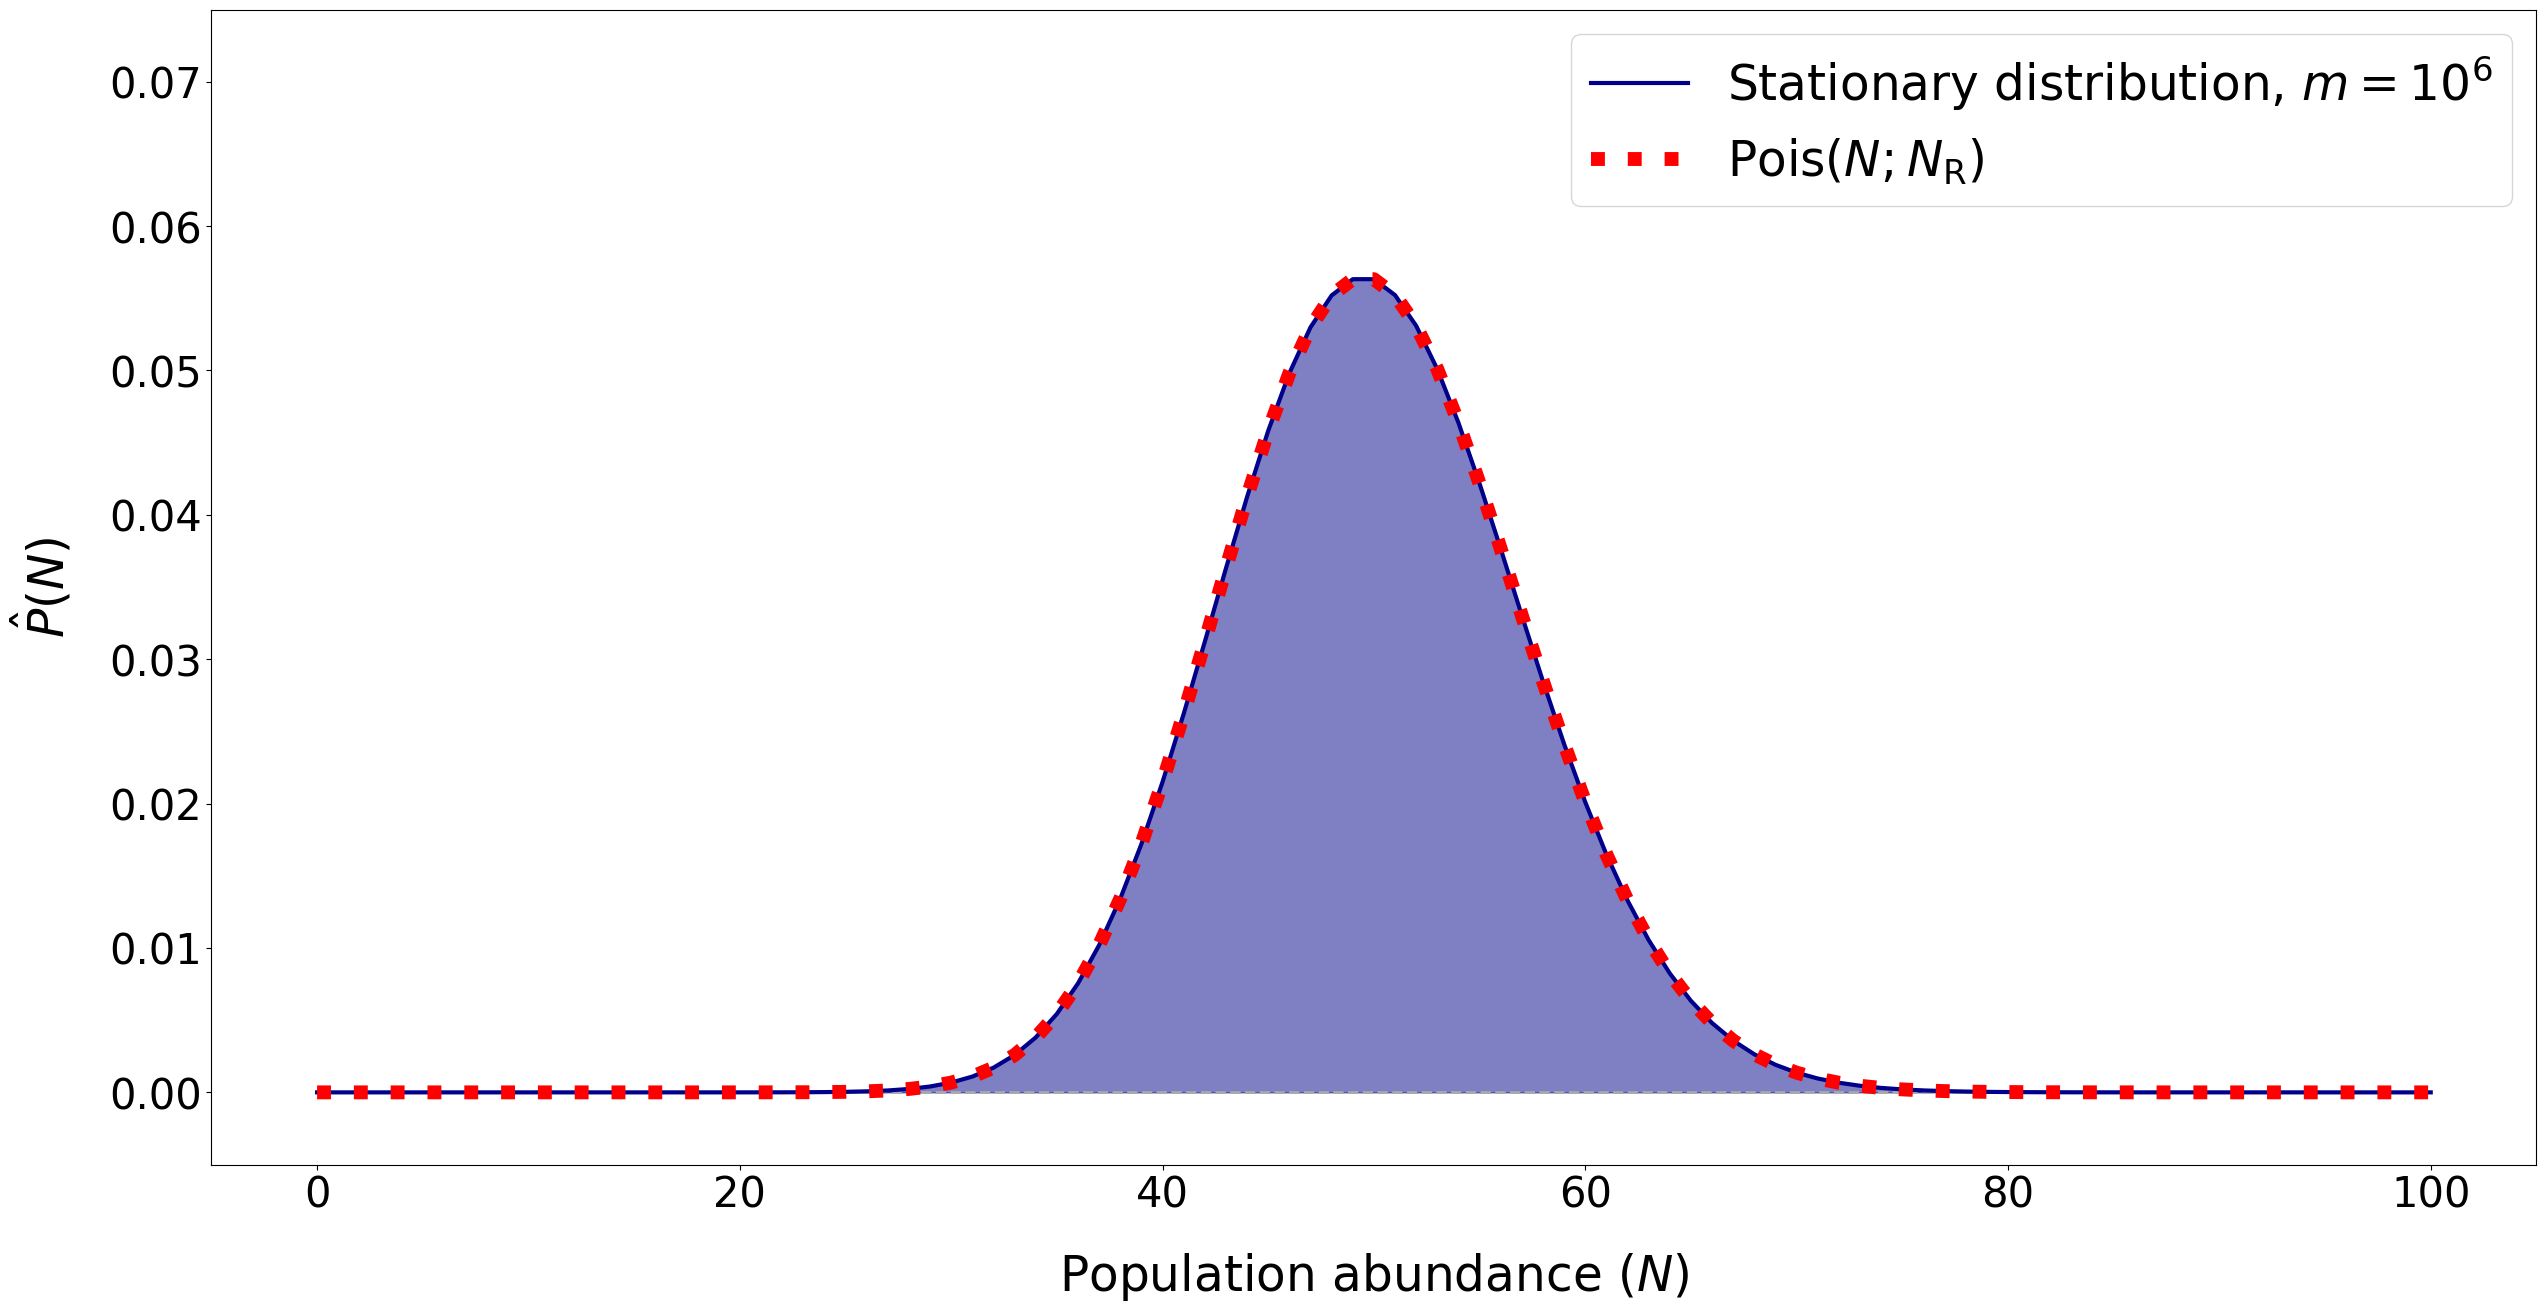

In [43]:
distribution_high_m = get_stationary_distribution(m=1e7, A=10, r=1.0, K=50, a=10.0, NR=50.0, x=0.0, survivor_frac=1.0)
distribution_poisson = poisson.pmf(np.arange(0, 101, 1), 50.0)

fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(30)
ax.hlines(0.0, 0.0, 100.0, linestyle='dashed', color='darkgrey', linewidth=2)
ax.plot(np.arange(0, 101, 1), distribution_high_m, color='darkblue', linewidth=3, label=r'Stationary distribution, $m=10^6$')
ax.fill_between(np.arange(0, 101, 1), distribution_high_m, color='darkblue', alpha=0.5)
ax.plot(np.arange(0, 101, 1), distribution_poisson, color='red', linewidth=10, linestyle='dotted', label=r'Pois($N; N_\text{R}$)')
ax.set_xlim(-5, 105)
ax.set_ylim(-0.005, 0.075)
ax.set_xlabel(r'Population abundance ($N$)', fontsize=35, labelpad=25)
ax.set_ylabel(r'$\hat{P}(N)$', fontsize=35, labelpad=25)
ax.tick_params(labelsize=30)
ax.legend(fontsize=35)

plt.savefig(f'{fig_path}\\figS1.pdf', bbox_inches='tight', pad_inches=0.1)


### Fig. S2

The following block of code may take up to several seconds to run.

In [18]:
A_values = np.arange(1, 38, 1)
KRinf_values = np.full(len(A_values), np.nan)
ARinf_values = np.full(len(A_values), np.nan)

AR_values = np.full(len(A_values), np.nan)
KR_values = np.full(len(A_values), np.nan)

# calculate equilibria using the Poisson distribution
for i, A in enumerate(A_values):
    ARinf_values[i] = root(NR_limit, A, args=(1.0, 10.0, A, 50, 0.0)).x[0]
    KRinf_values[i] = root(NR_limit, 50, args=(1.0, 10.0, A, 50, 0.0)).x[0]

# calculate equilibria for a high dispersal rate m=10^6
for i, A in enumerate(A_values):
    AR_values[i] = root(black_box, A, args=(1e6, A, 1.0, 50, 10.0, 0, 1.0, True)).x[0]   
    KR_values[i] = root(black_box, 45, args=(1e6, A, 1.0, 50, 10.0, 0, 1.0, True), tol=1e-9).x[0]

Draw the figure.

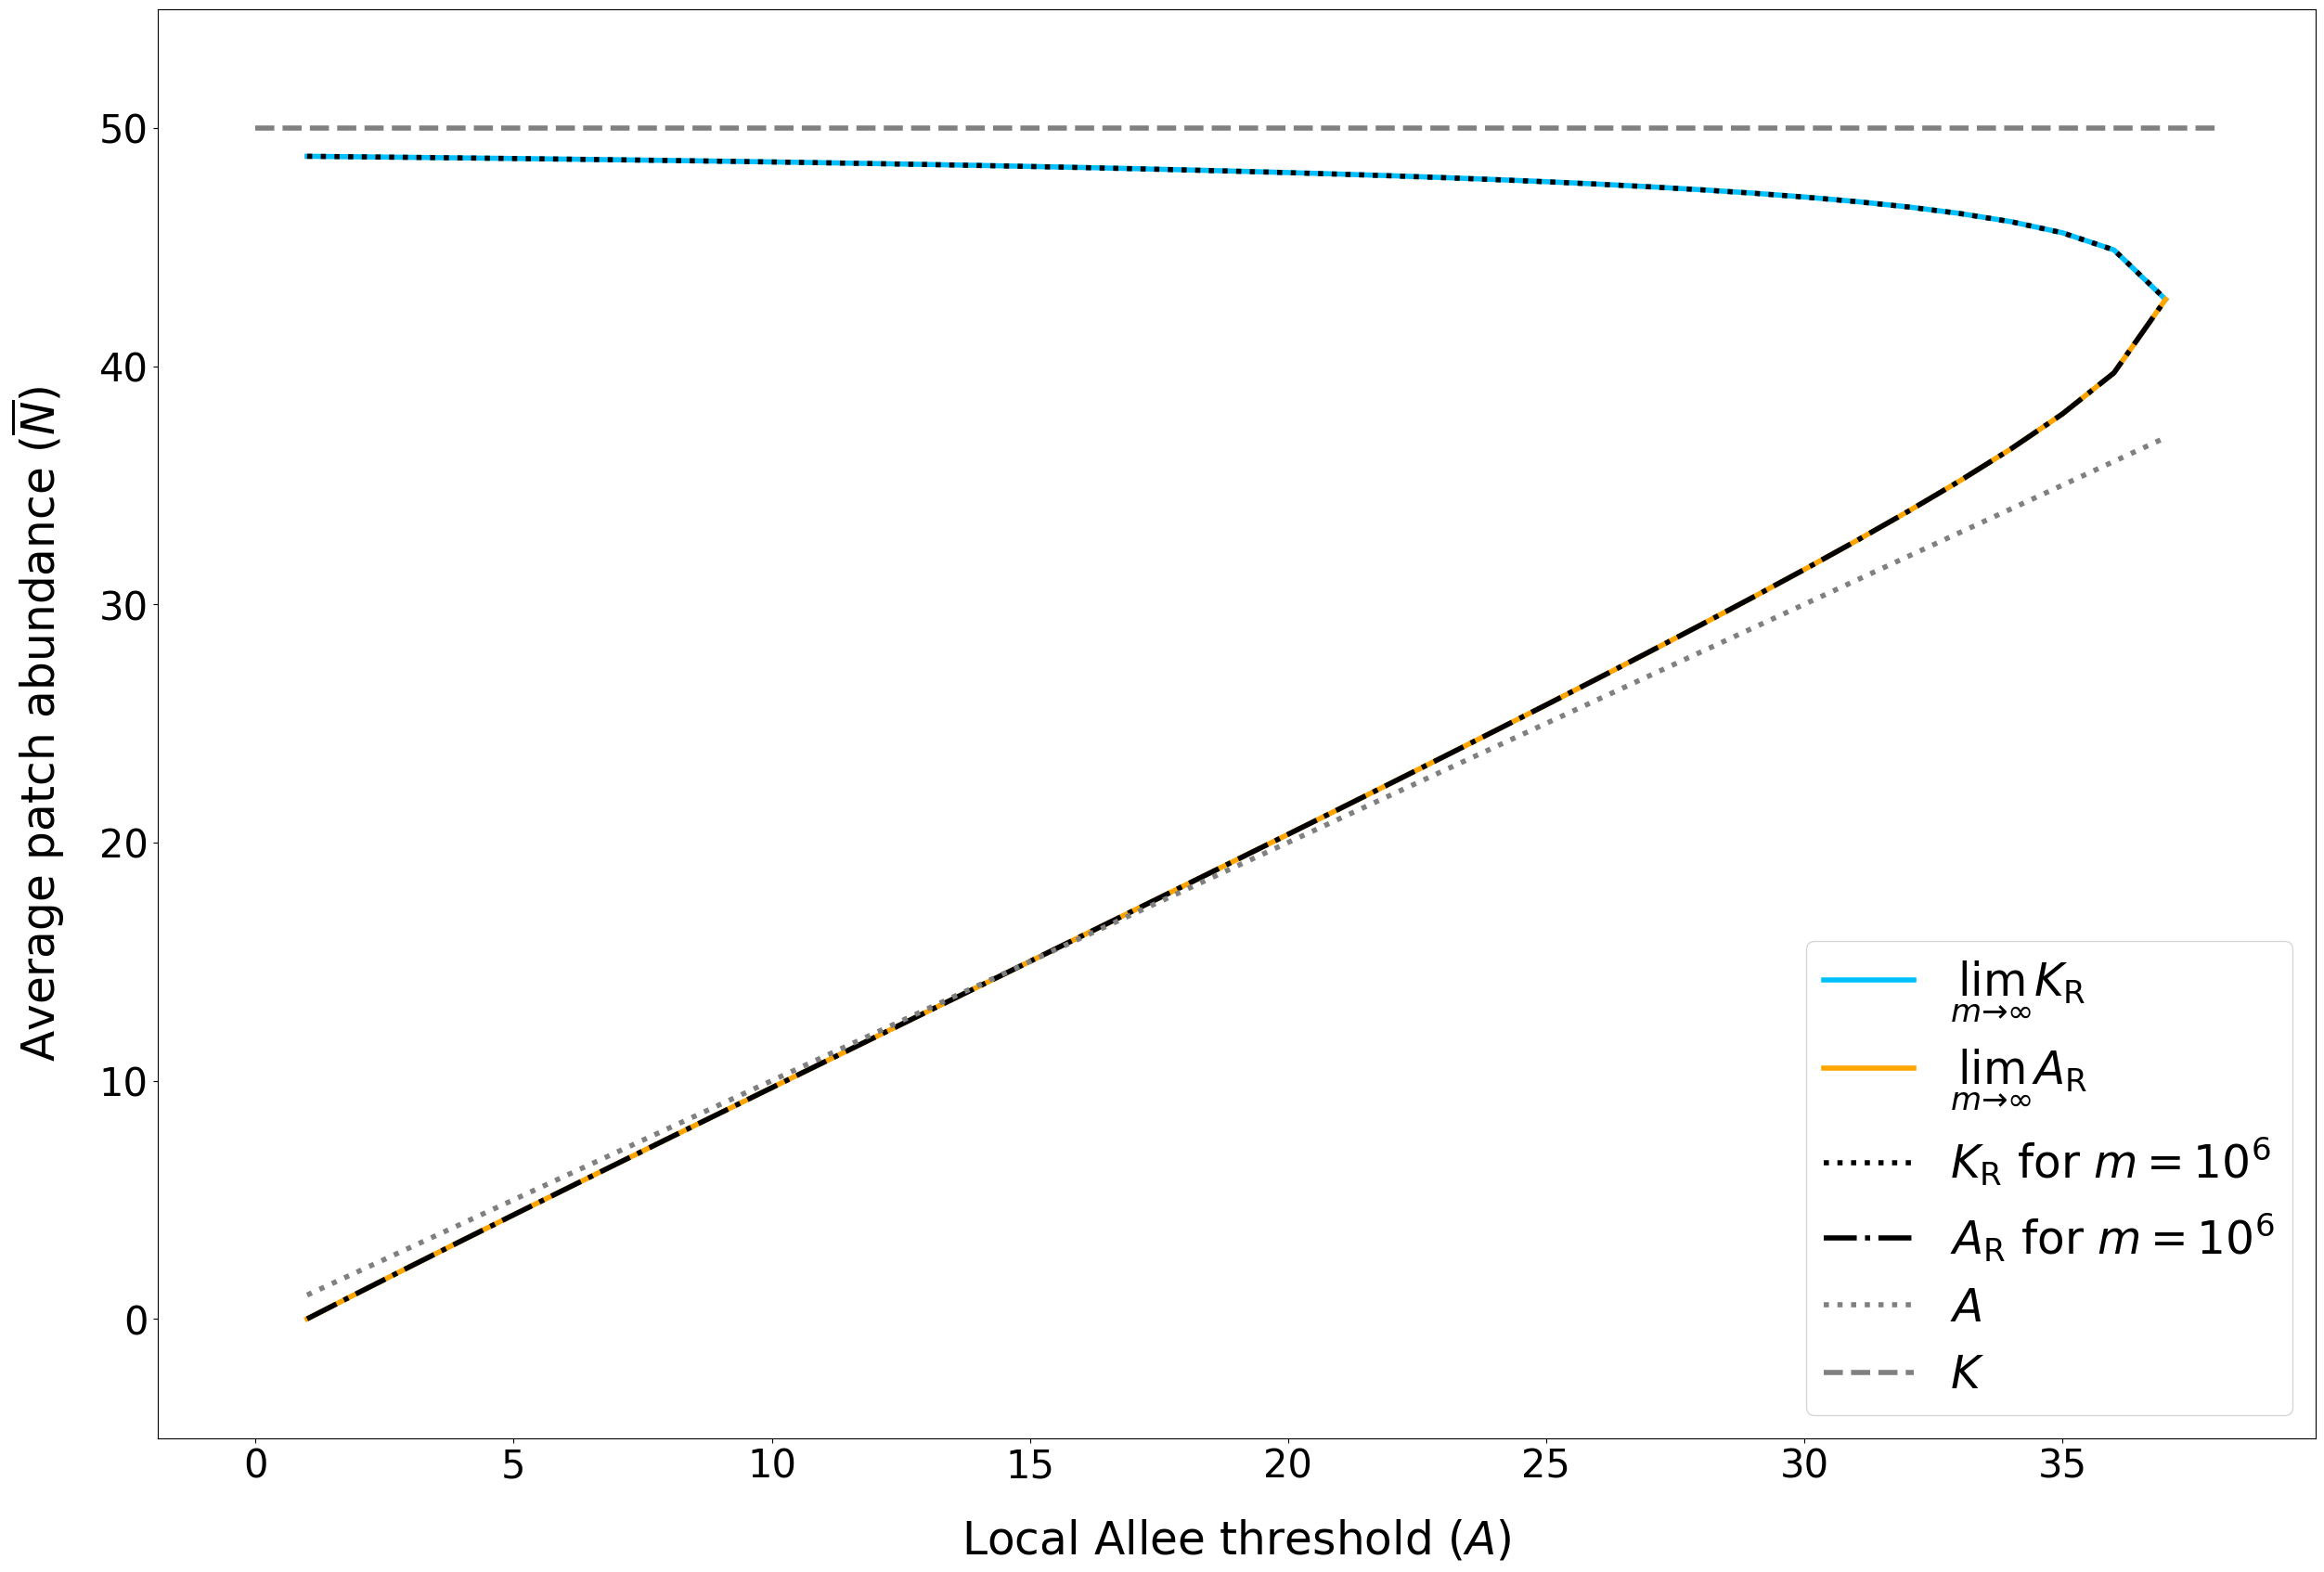

In [19]:
fig, ax = plt.subplots(figsize=(30, 20))
ax.plot(A_values, KRinf_values, color='deepskyblue', label=r'$\lim_{m\rightarrow \infty} K_\text{R}$', linewidth=4)
ax.plot(A_values, ARinf_values, color='orange', label=r'$\lim_{m\rightarrow \infty} A_\text{R}$', linewidth=4)

ax.plot(A_values, KR_values, color='black', label=r'$K_\text{R}$ for $m=10^6$', linestyle='dotted', linewidth=4)
ax.plot(A_values, AR_values, color = 'black', label=r'$A_\text{R}$ for $m=10^6$', linestyle='dashdot', linewidth=4)

ax.plot(A_values, A_values, color='grey', linestyle='dotted', label=r'$A$', linewidth=4)
ax.hlines(50, 0, 38, color='grey', linestyle='dashed', label=r'$K$', linewidth=4)
ax.set_xlabel(r'Local Allee threshold ($A$)', fontsize=35, labelpad=25)
ax.set_ylabel(r'Average patch abundance ($\overline{N}$)', fontsize=35, labelpad=25)
ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_ylim(-5, 55)
ax.legend(fontsize=35)

plt.savefig(f'{fig_path}\\figS2.pdf', bbox_inches='tight', pad_inches=0.1)


### Fig. S3

The following block of code may take up to a minute to run.

In [19]:
K_values = np.logspace(1.5, 6, 60)
KRinf_values = np.zeros(len(K_values))
ARinf_values2 = np.zeros(len(K_values))
ARinf_values3 = np.zeros(len(K_values))
ARinf_values4 = np.zeros(len(K_values))
ARinf_values5 = np.zeros(len(K_values))
ARinf_values_fixed_A = np.zeros(len(K_values))

for i, K in enumerate(K_values):
    KRinf_values[i] = root(NR_limit, K, args=(1, K/5, K/5, K, 0)).x[0]
    ARinf_values2[i] = root(NR_limit, K/2, args=(1, K/5, K/2, K, 0)).x[0]
    ARinf_values3[i] = root(NR_limit, K/3, args=(1, K/5, K/3, K, 0)).x[0]
    ARinf_values4[i] = root(NR_limit, K/4, args=(1, K/5, K/4, K, 0)).x[0]
    ARinf_values5[i] = root(NR_limit, K/5, args=(1, K/5, K/5, K, 0)).x[0]
    ARinf_values_fixed_A[i] = root(NR_limit, 10, args=(1, K/5, 10, K, 0)).x[0]

Draw the figure.

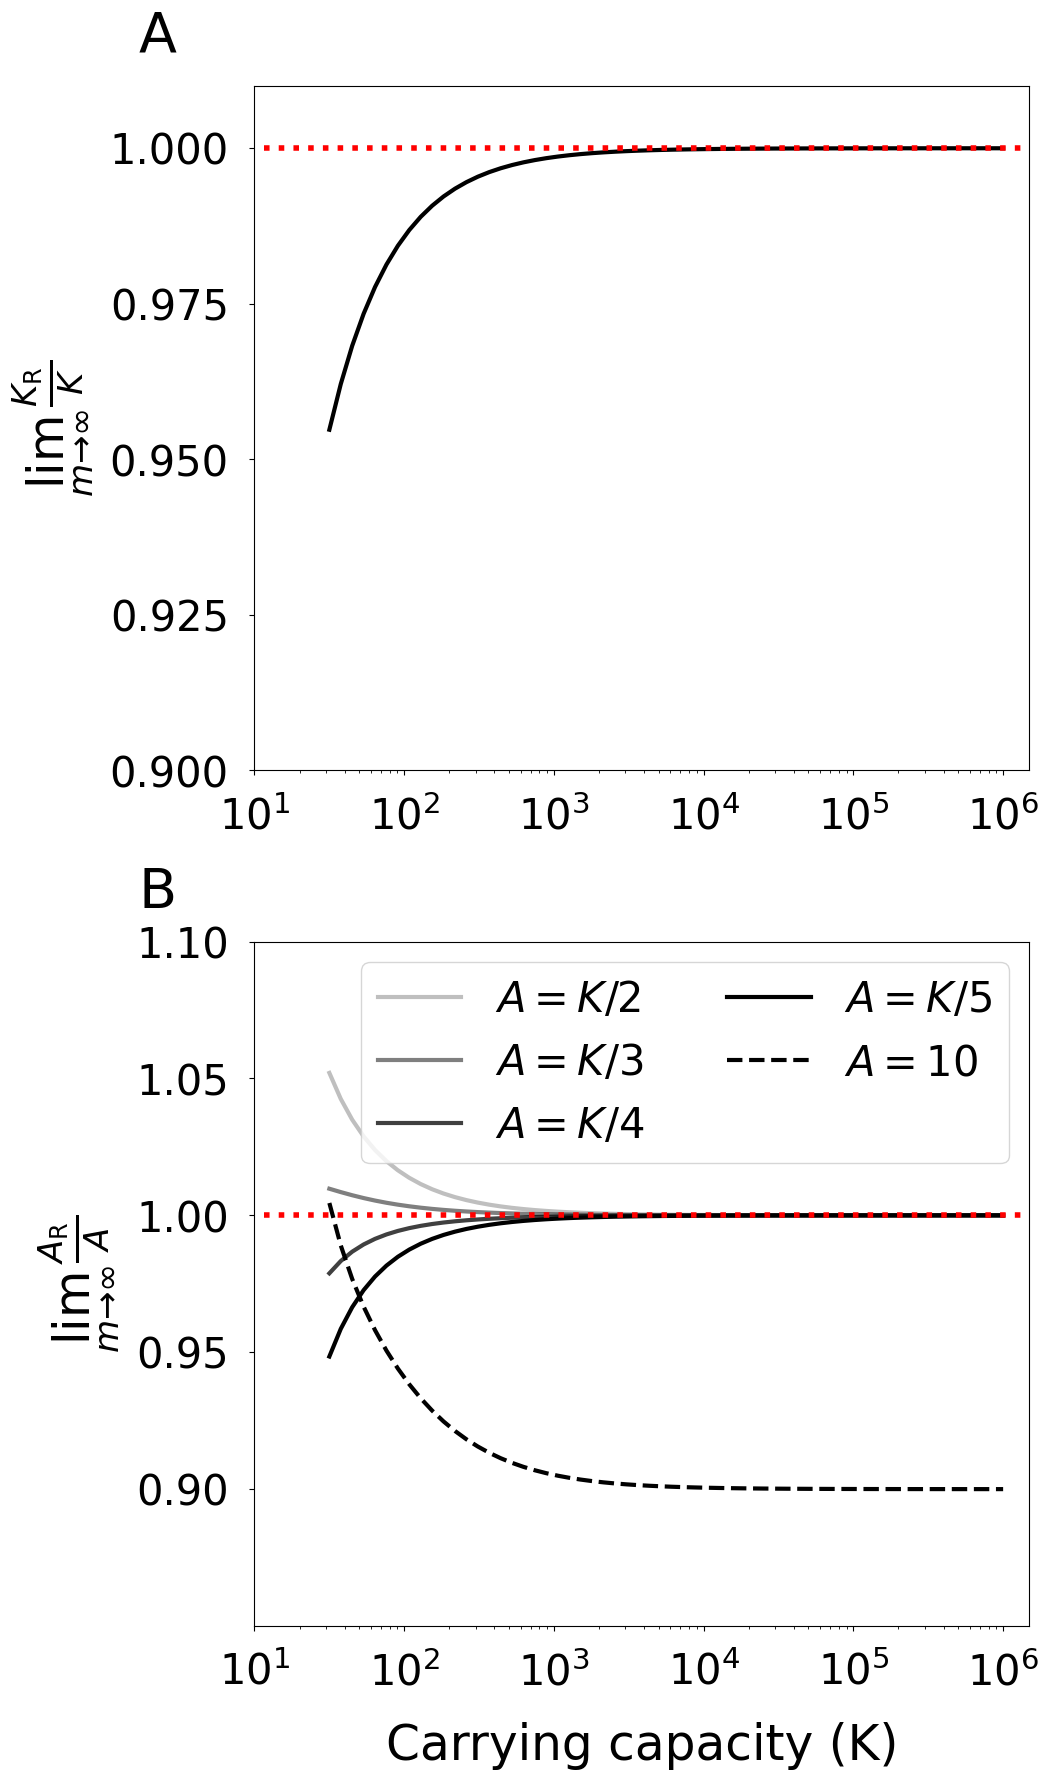

In [20]:
fig, ax = plt.subplots(2, 1, figsize = (10, 20), gridspec_kw={'hspace':0.25})
ax0, ax1 = ax
ax0.plot(K_values, KRinf_values/K_values, linestyle='-', label=r'$K_\text{R}^\infty/K$', linewidth=3, color='black')
ax0.hlines(1, 0, 1e7, linestyle='dotted', color='red', linewidth=4)
ax0.set_ylabel(r'$\lim_{m\rightarrow\infty}  \frac{K_\text{R}}{K}$', fontsize=35, labelpad=10)
ax0.set_xscale('log')
ax0.set_ylim(0.9, 1.01)
ax0.set_xlim(10, 1.5e6)
ax0.set_yticks(np.linspace(0.9, 1.0, 5))
ax0.tick_params(labelsize=30, pad=15)
ax0.text(-0.15, 1.05, 'A', fontsize=40, transform=ax0.transAxes)

ax1.plot(K_values, 2*ARinf_values2/K_values, linestyle='-', label=r'$A=K/2$', linewidth=3, color='black', alpha=0.25)
ax1.plot(K_values, 3*ARinf_values3/K_values, linestyle='-', label=r'$A=K/3$', linewidth=3, color='black', alpha=0.5)
ax1.plot(K_values, 4*ARinf_values4/K_values, linestyle='-', label=r'$A=K/4$', linewidth=3, color='black', alpha=0.75)
ax1.plot(K_values, 5*ARinf_values5/K_values, linestyle='-', label=r'$A=K/5$', linewidth=3, color='black', alpha=1.0)
ax1.plot(K_values, ARinf_values_fixed_A/10, linestyle='--', label=r'$A=10$', linewidth=3, color='black', alpha=1.0)
ax1.hlines(1, 0, 1e7, linestyle='dotted', color='red', linewidth=4)
ax1.set_xlabel('Carrying capacity (K)', fontsize=35, labelpad=20)
ax1.set_ylabel(r'$\lim_{m\rightarrow\infty}  \frac{A_\text{R}}{A}$', fontsize=35, labelpad=10)
ax1.legend(fontsize=30, loc='upper right', ncol=2)
ax1.set_xscale('log')
ax1.set_ylim(0.85, 1.1)
ax1.set_xlim(10, 1.5e6)
ax1.set_yticks(np.linspace(0.9, 1.1, 5))
ax1.tick_params(labelsize=30, pad=15)
ax1.text(-0.15, 1.05, 'B', fontsize=40, transform=ax1.transAxes)

plt.savefig(f'{fig_path}\\figS3.pdf', bbox_inches='tight', pad_inches=0.1)


### Fig. S4

The following block of code may take up to several seconds to run.

In [21]:
N_max = 100

m_values = np.linspace(0.01, 0.1, 10) 
A_values = np.linspace(5, 15, 11, dtype=int)

distributions = np.zeros((len(m_values), len(A_values), N_max+1))

# obtain the equilibrium distribution by numerical integration
for i, m in enumerate(m_values):
    for j, A in enumerate(A_values):
        distributions[i, j] = numerically_integrate(m, A, initial_conditions=np.concatenate((np.zeros(N_max), [1])),
                                                    r=1.0, a=10.0, K=50, x=0.0, survivor_frac=1.0)

Draw the figure.

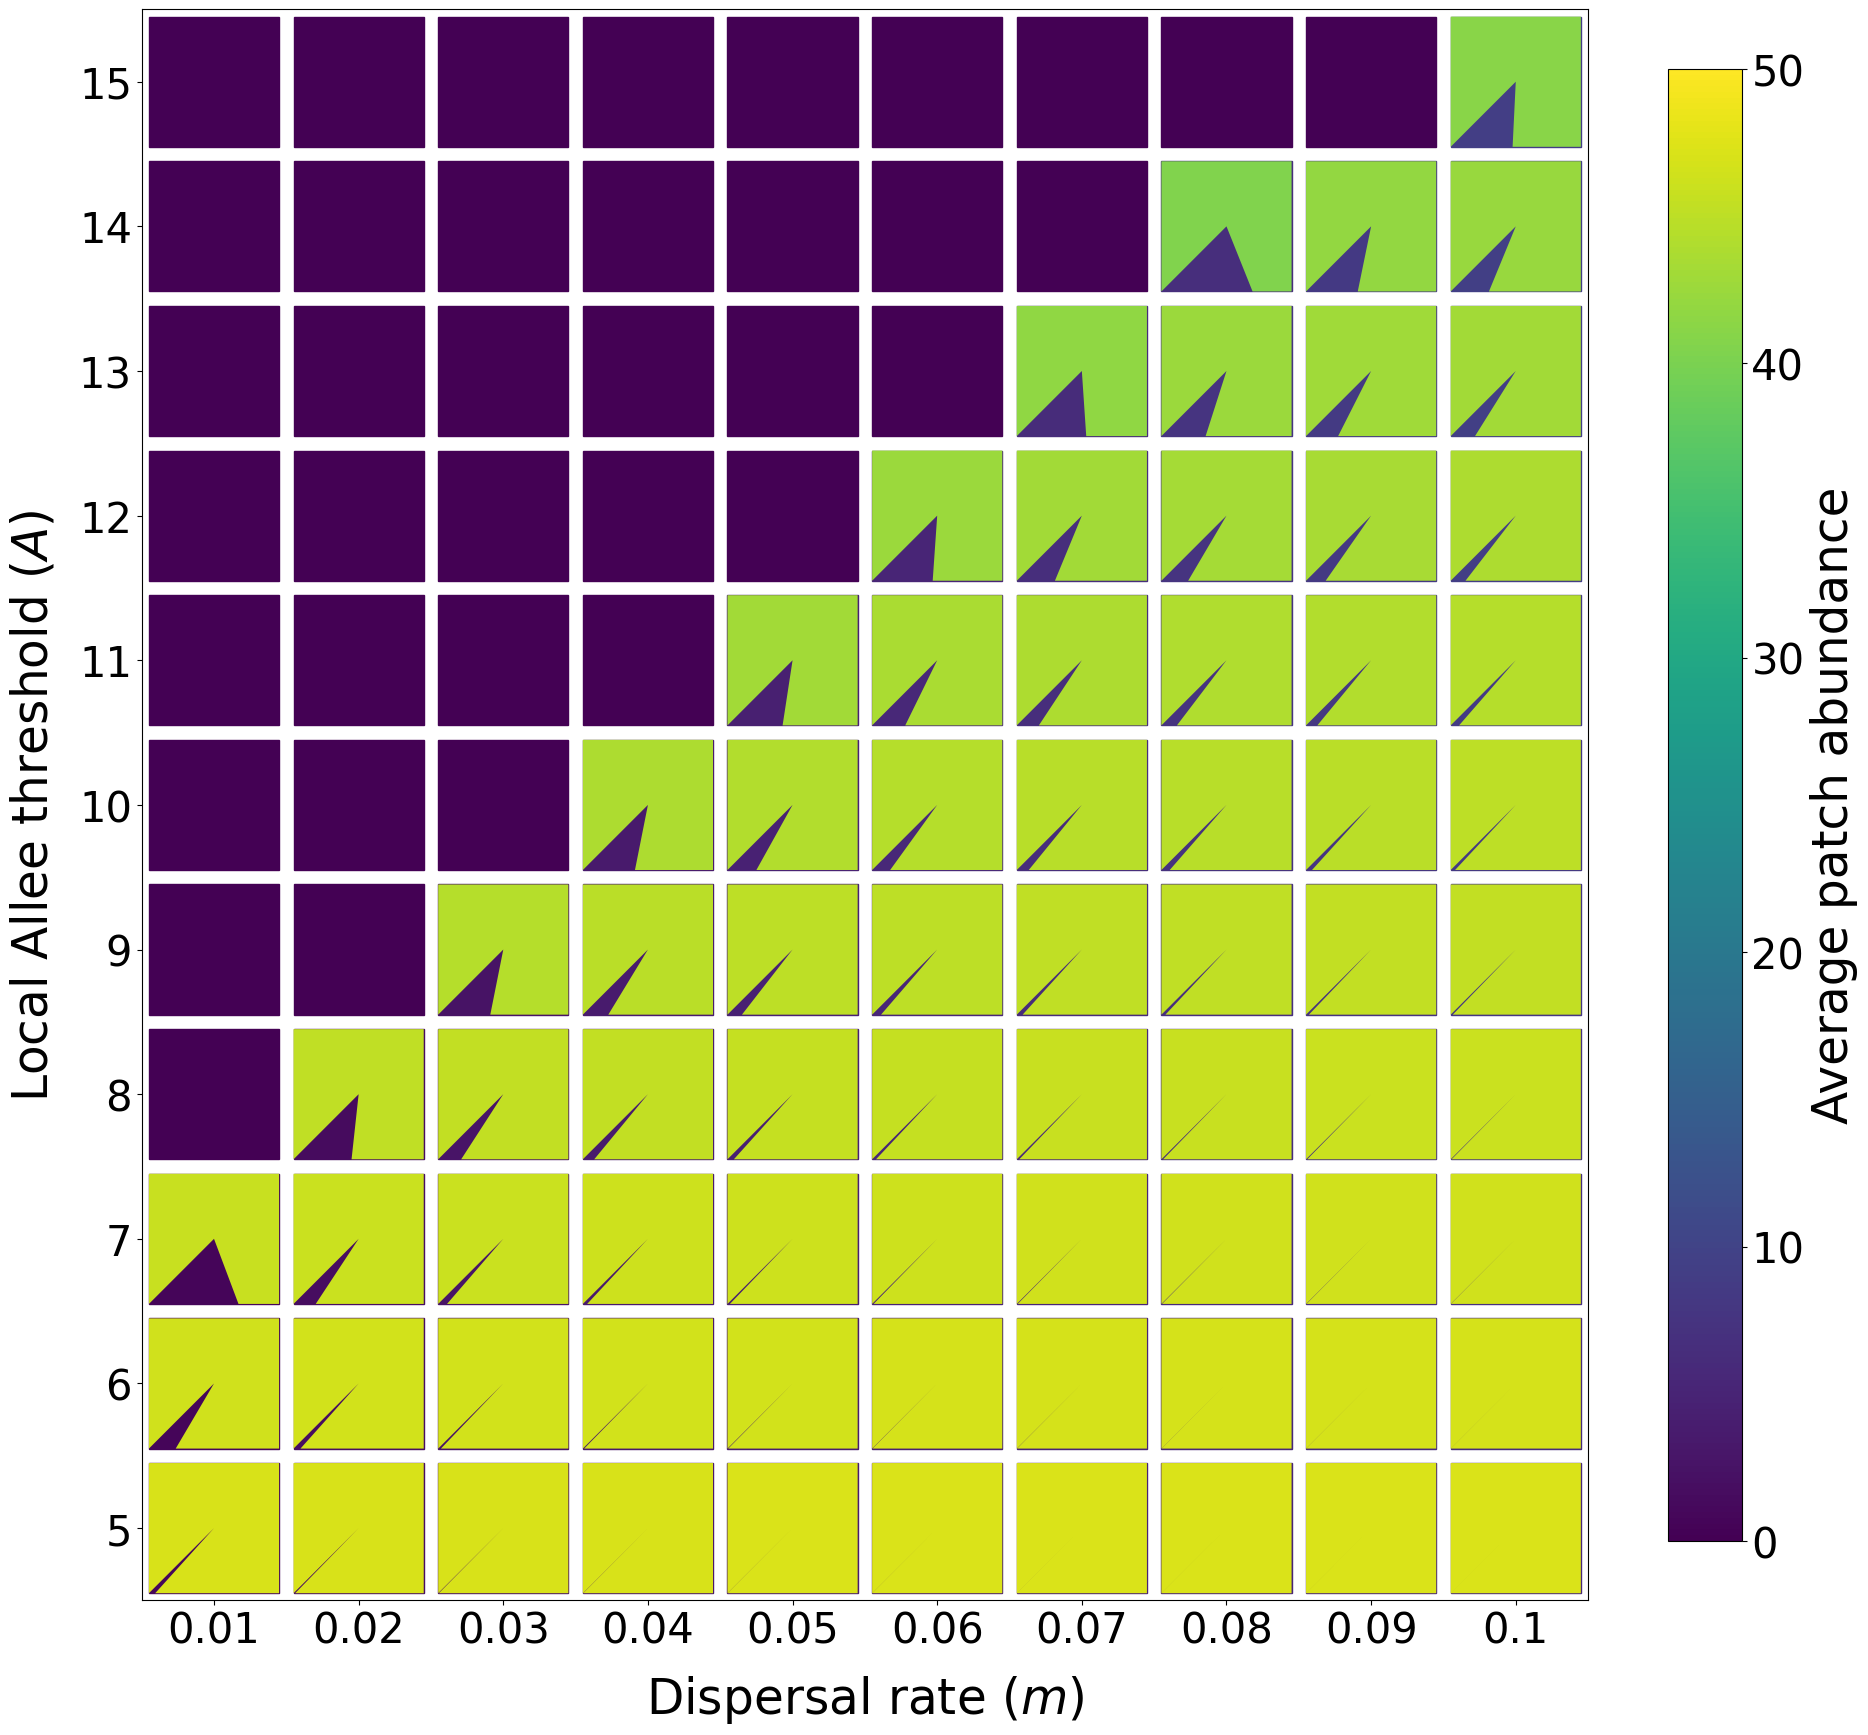

In [22]:
fig, ax = plt.subplots()
fig.set_figheight(20)
fig.set_figwidth(20)

draw_square_pie(ax, m_values, A_values, N_max, distributions)

ax.set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=15)
ax.set_ylabel(r'Local Allee threshold ($A$)', fontsize=35, labelpad=15)
ax.tick_params(labelsize=30)

plt.savefig(f'{fig_path}\\figS4.pdf', bbox_inches='tight', pad_inches=0.1)


### Fig. S5

Find the average abundance needed for colonisation for different kinds of initial distributions. The following block of code may take up to several hours to run.

In [20]:
A_values = [5, 7, 8, 25]
bisection_limits = [[1e-4, 1e-3], [1e-3, 1e-1], [0.01, 0.1], [0.1, 1]]

for i, A in enumerate(A_values):
    m_min = bisection_method(A=A, tofind='min', limits=bisection_limits[i], r=1.0, K=50, a=10.0, x=0.0, survivor_frac=1.0)
    # here, we manually set an m_min for A=5 because the bisection method algorithm isn't perfect 
    # and can lead to spurious results for A=5
    # in other bifurcation diagrams, we don't do this as the difference caused by this problem is negligible
    if A == 5:
        m_min = 0.00028  
    m_values = np.logspace(np.log10(m_min), 3, 100)

    AR_values_poisson = np.full(len(m_values), np.nan)
    AR_values_delta = np.full(len(m_values), np.nan)
    AR_values_negbinom = np.full(len(m_values), np.nan)

    for j, m in enumerate(m_values):

        try:
            AR_values_negbinom[j] = bisection_NR(m=m, A=A, initial_distribution=neg_binom, fixed_param=10,
                                        r=1.0, K=50, a=10.0, x=0.0, survivor_frac=1.0)
            AR_values_delta[j] = bisection_NR(m=m, A=A, initial_distribution=delta, fixed_param=0.5,
                                        r=1.0, K=50, a=10.0, x=0.0, survivor_frac=1.0)
            AR_values_poisson[j] = bisection_NR(m=m, A=A, initial_distribution=trunc_poisson, fixed_param=np.nan,
                                        r=1.0, K=50, a=10.0, x=0.0, survivor_frac=1.0)
        except UserWarning as e:
            pass

    data = pd.DataFrame({'m':m_values, 
                        'poisson': AR_values_poisson,
                        'delta': AR_values_delta,
                        'neg_binom': AR_values_negbinom})
    
    data.to_csv(f'{data_path}\\distribution_dependence_A={A}_r=1_K=50_a=10_x=0_survivor_frac=1.0.csv', index=False)


Draw the figure.

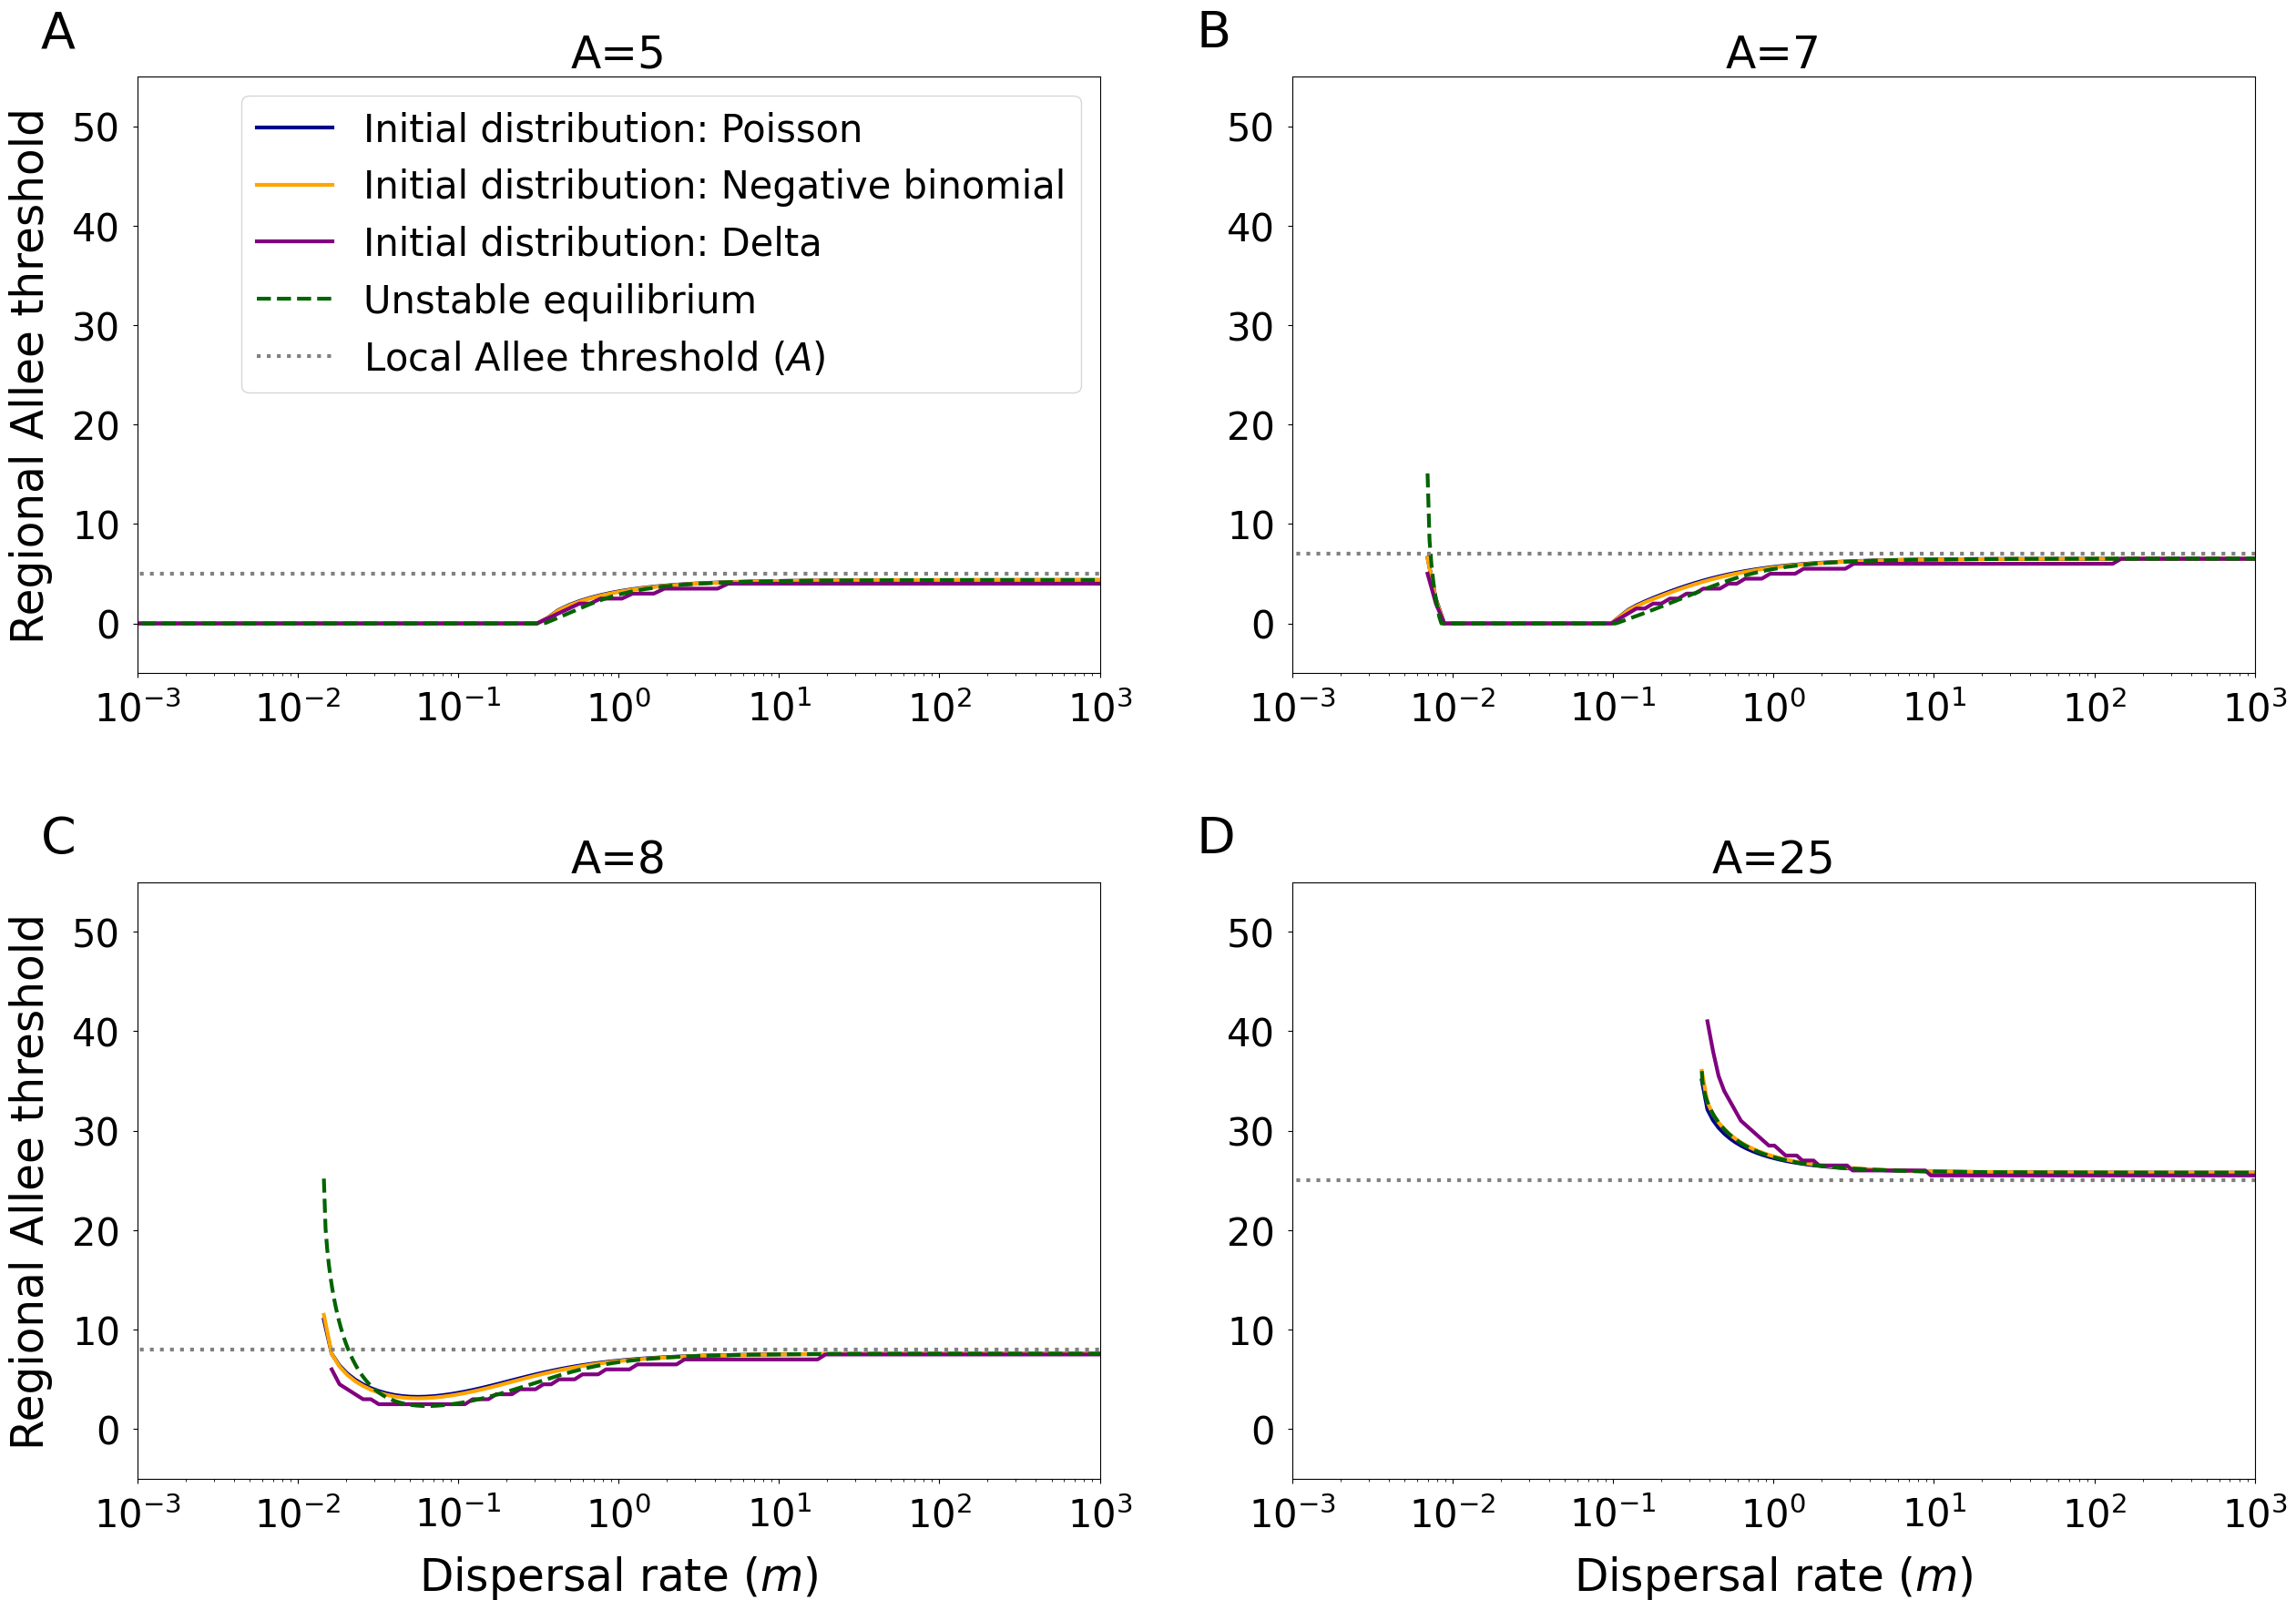

In [22]:
A_values = [5, 7, 8, 25]
labels = ['A', 'B', 'C', 'D']


fig, ax = plt.subplots(2, 2, gridspec_kw={'hspace':0.35})
fig.set_figheight(20)
fig.set_figwidth(30)

for i in [0, 1]:
    for j in [0, 1]:
        A = A_values[2*i+j]
        data = pd.read_csv(f'{data_path}\\distribution_dependence_A={A}_r=1_K=50_a=10_x=0_survivor_frac=1.0.csv')
        init_poisson = data['poisson']
        init_negbinom = data['neg_binom']
        init_delta = data['delta']
        m_values = data['m']

        bifurcation_data = pd.read_csv(f'{data_path}\\metapopulation_bifurcation_A={A}_r=1_K=50_a=10_x=0_survivor_frac=1.0.csv')
        m_values_bif = bifurcation_data['m']
        AR_values = bifurcation_data['A_R']

        ax[i, j].plot(m_values, init_poisson, label='Initial distribution: Poisson', color='darkblue', linewidth=3)
        ax[i, j].plot(m_values, init_negbinom, label='Initial distribution: Negative binomial', color='orange', linewidth=3)
        ax[i, j].plot(m_values, init_delta, label='Initial distribution: Delta', color='purple', linewidth=3)
        ax[i, j].plot(m_values_bif, AR_values, label='Unstable equilibrium', color='darkgreen', linewidth=3, linestyle='dashed')
        ax[i, j].hlines(y=A, xmin=0, xmax=1e7, colors='grey', linewidth=3, linestyles='dotted', label = r'Local Allee threshold ($A$)')
        ax[i, j].set_xlim(1e-3, 1e3)    
        ax[i, j].set_ylim(-5, 55)
        ax[i, j].set_xscale('log')
        ax[i, j].tick_params(labelsize=30, pad=10) 
        ax[i, j].set_title(f'A={A}', fontsize=35)
        ax[i, j].text(-0.1, 1.05, labels[2*i+j], fontsize=40, transform=ax[i, j].transAxes)

ax[0, 0].set_ylabel('Regional Allee threshold', fontsize=35, labelpad=15)
ax[1, 0].set_ylabel('Regional Allee threshold', fontsize=35, labelpad=15)
ax[1, 0].set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=15)
ax[1, 1].set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=15)
ax[0, 0].legend(fontsize=30)

plt.savefig(f'{fig_path}\\figS5.pdf', bbox_inches='tight', pad_inches=0.1)


### Fig. S6

Metapopulation bifurcation diagrams with catastrophes. The following block of code may take up to several minutes to run.

In [64]:
A_values = [5, 7, 8, 25]

bisection_limits = [[0.01, 1], [0.01, 1], [0.01, 1], [0.1, 10]]

for i, A in enumerate(A_values):
    m_min = bisection_method(A=A, r=1.0, K=50, a=10.0, x=0.01, survivor_frac=1.0, tofind='min', limits=bisection_limits[i])
    m_values = np.concatenate((np.logspace(np.log10(m_min), 0, 175, endpoint=False), np.logspace(0, 4, 50)))

    m_values, regional_thresholds, carrying_capacities, zero_stability = get_bifurcation_data(A=A, 
                                                                                            m_values=m_values, 
                                                                                            r=1.0, K=50, a=10.0, 
                                                                                            x=0.01, survivor_frac=1.0)
    data = pd.DataFrame({'m': m_values, 
                        'A_R': regional_thresholds, 
                        'K_R': carrying_capacities, 
                        'zero_vals': zero_stability})
    data.to_csv(f'{data_path}\\metapopulation_bifurcation_A={A}_r=1_K=50_a=10_x=0.01_survivor_frac=1.0.csv', index=False)

Draw the figure.

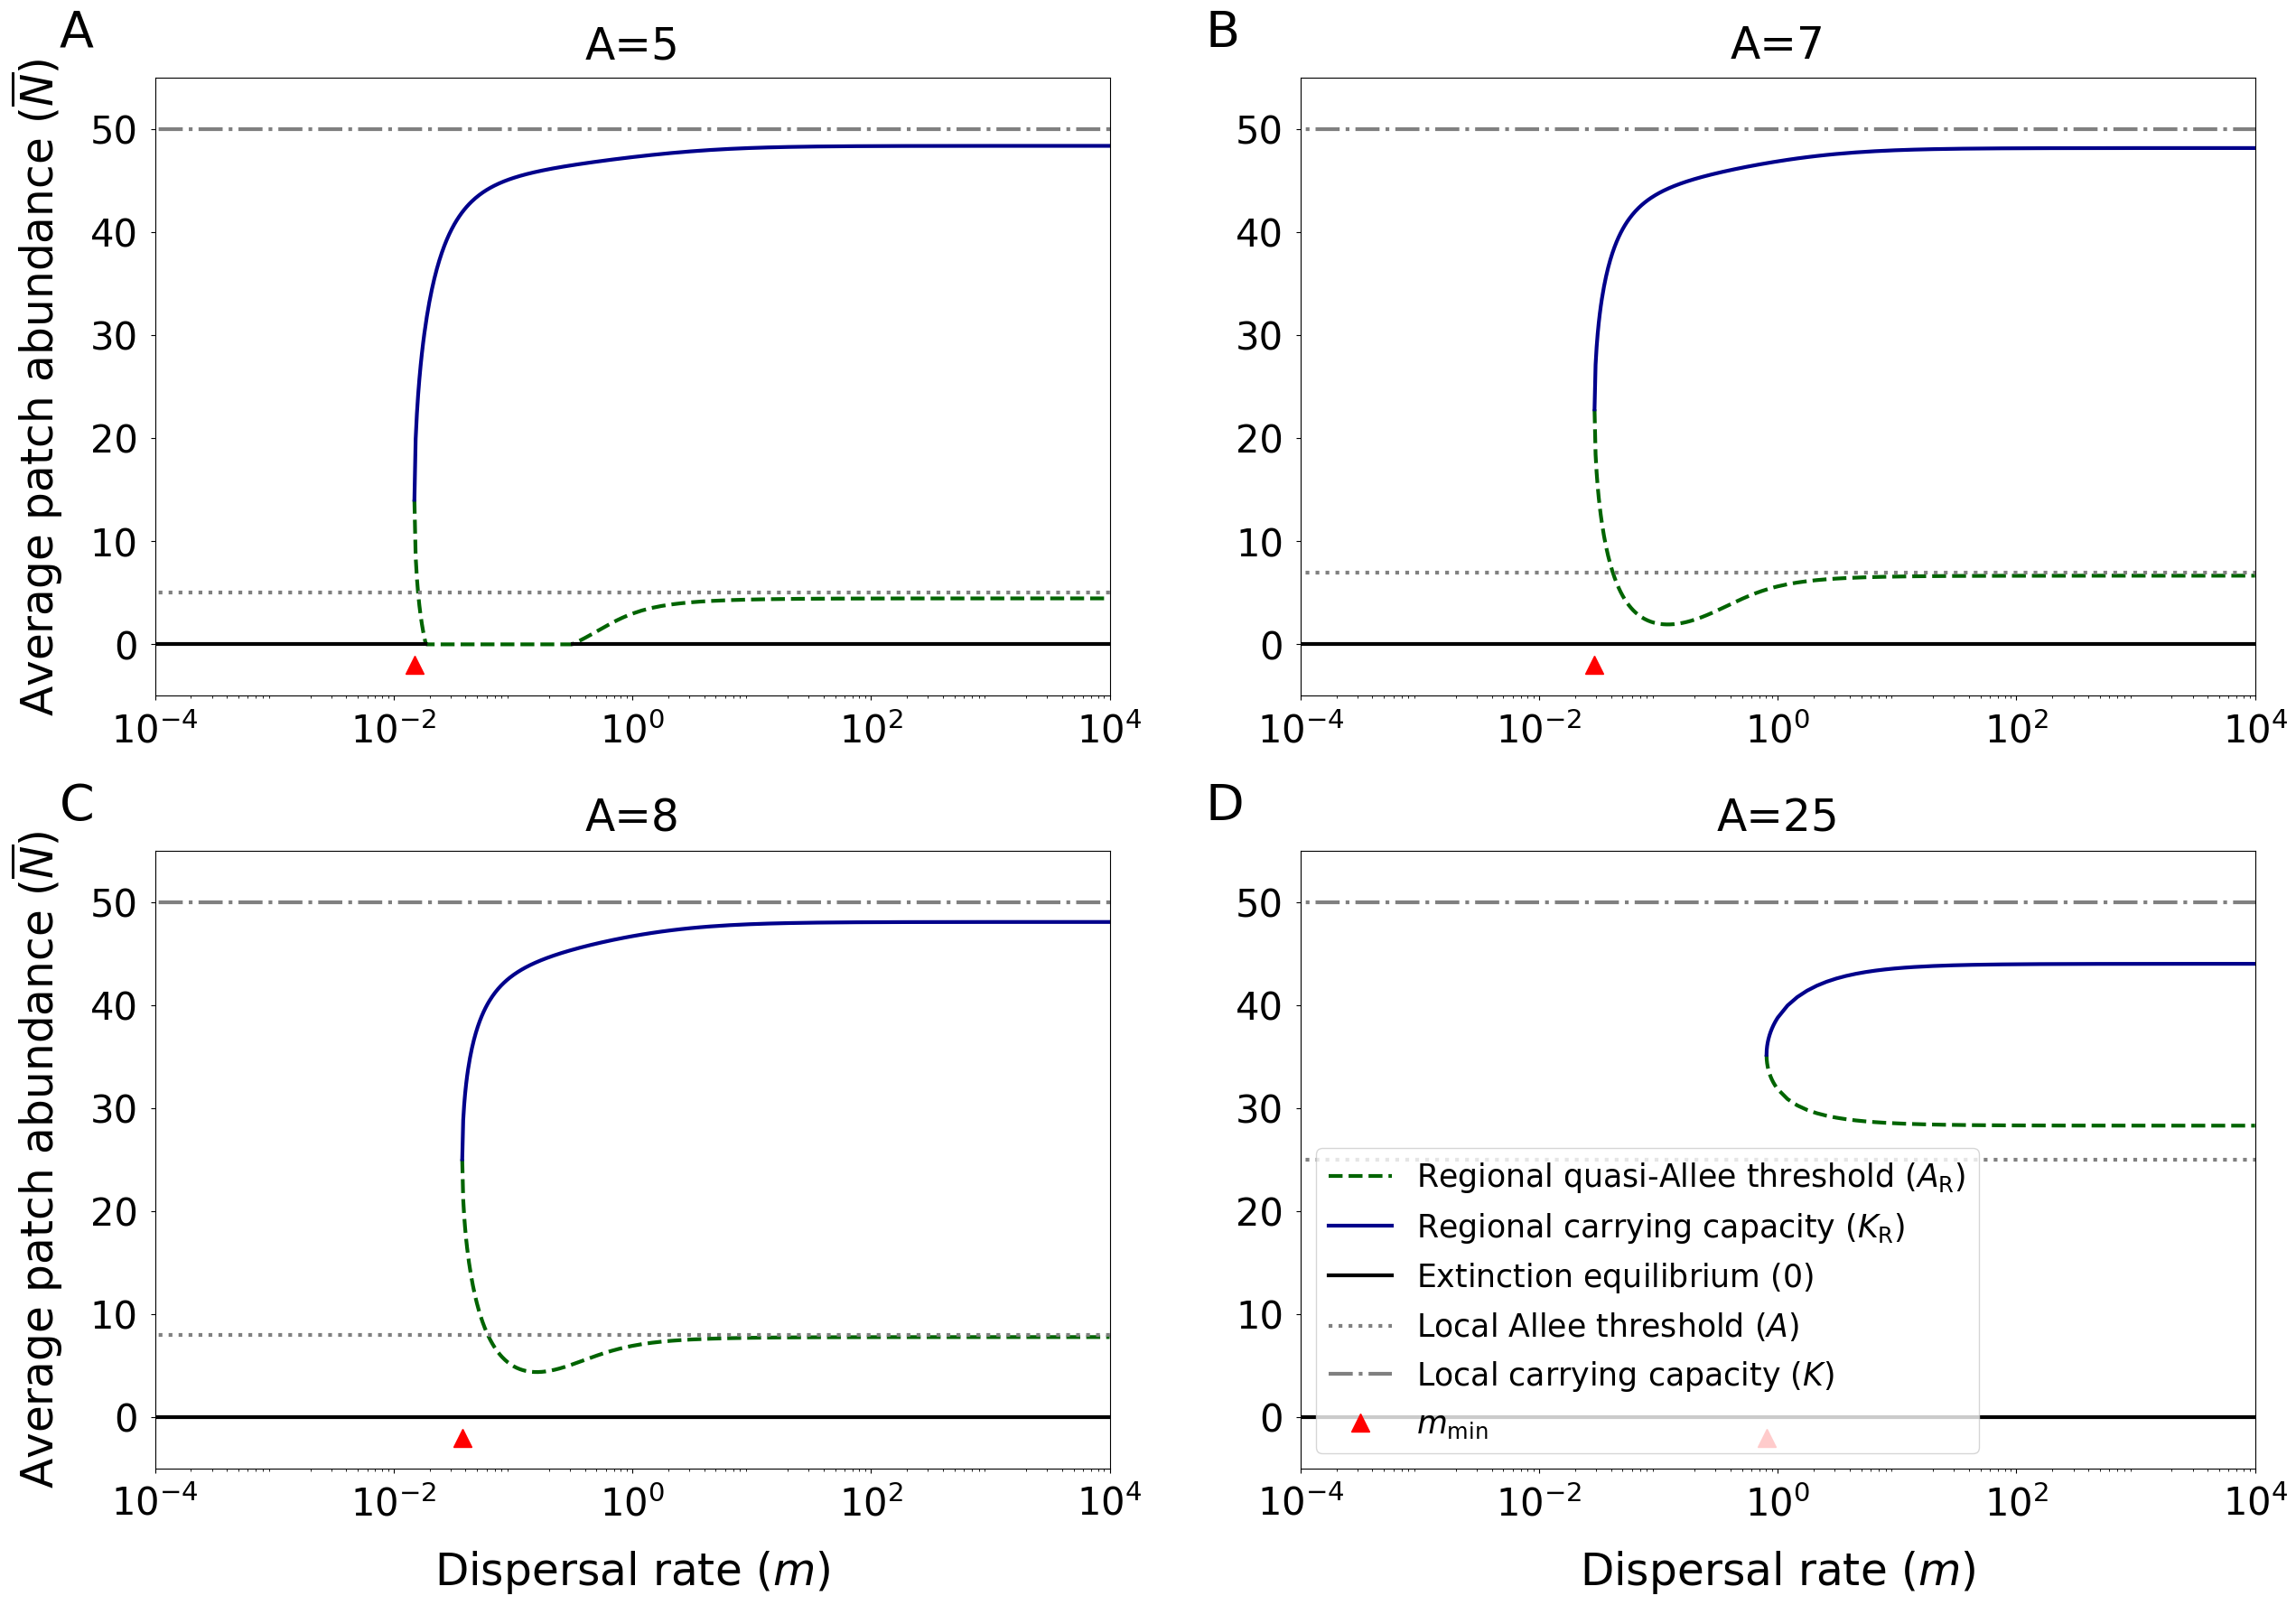

In [158]:
A_values = [5, 7, 8, 25]
labels = ['A', 'B', 'C', 'D']

fig, ax = plt.subplots(2, 2, gridspec_kw={'hspace':0.25})
fig.set_figheight(20)
fig.set_figwidth(30)

for i in [0, 1]:
    for j in [0, 1]:
        A = A_values[2*i+j]
        data = pd.read_csv(f'{data_path}\\metapopulation_bifurcation_A={A}_r=1_K=50_a=10_x=0.01_survivor_frac=1.0.csv')

        zero_vals = data['zero_vals']

        ax[i, j].plot(data['m'], data['A_R'], label=r'Regional quasi-Allee threshold ($A_\text{R}$)', color='darkgreen', linestyle='dashed', linewidth=3)
        ax[i, j].plot(data['m'], data['K_R'], label=r'Regional carrying capacity ($K_\text{R}$)', color='darkblue', linewidth=3)
        ax[i, j].plot(np.concatenate(([1e-6], data['m'], [1e6])), np.concatenate(([0.0], zero_vals, [0.0])), color='black', linewidth=3, label=r'Extinction equilibrium ($0$)')
        ax[i, j].hlines(y=A, xmin=0, xmax=1e7, colors='grey', linestyles='dotted', linewidth=3, label = r'Local Allee threshold ($A$)')
        ax[i, j].hlines(y=50, xmin=0, xmax=1e7, colors='grey', linestyles='dashdot', linewidth=3, label = r'Local carrying capacity ($K$)')

        ax[i, j].set_xlim(1e-4, 1e4)
        ax[i, j].set_ylim(-5, 55)
        ax[i, j].set_xscale('log')
        ax[i, j].tick_params(labelsize=30, pad=10)
        ax[i, j].set_xticks(ticks=[1e-4, 1e-2, 1e0, 1e2, 1e4])
        ax[i, j].set_title(f'A={A}', fontsize=35, pad=15)
        ax[i, j].text(-0.1, 1.05, labels[2*i+j], fontsize=40, transform=ax[i, j].transAxes)


        # mark m_min in every figure
        ax[i, j].plot(data['m'][0], -2, ls='', marker='^', markersize=15, color='red', label=r'$m_\text{min}$')

ax[0, 0].set_ylabel(r'Average patch abundance ($\overline{N}$)', fontsize=35, labelpad=20)
ax[1, 0].set_ylabel(r'Average patch abundance ($\overline{N}$)', fontsize=35, labelpad=20)

ax[1, 0].set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=20)
ax[1, 1].set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=20)
ax[1, 1].legend(fontsize=25, loc='lower left', bbox_to_anchor=(0., 0., 1, 1))

plt.savefig(f'{fig_path}\\figS6.pdf', bbox_inches='tight', pad_inches=0.1)


### Fig. S7

Metapopulation bifurcation diagrams w.r.t. dispersal rate ($m$) with dispersal mortality. The following block of code may take up to several minutes to run.

In [144]:
A_values = [5, 7, 8, 25]

bisection_limits_min = [[1e-4, 1e-3], [1e-3, 1e-1], [0.01, 0.1], [0.1, 1]]
bisection_limits_max = [[50, 70], [10, 100], [10, 100], [1.0, 10.0]]

for i, A in enumerate(A_values):
    m_min = bisection_method(A=A, r=1.0, K=50, a=10.0, x=0.0, survivor_frac=0.99, tofind='min', limits=bisection_limits_min[i])
    m_max = bisection_method(A=A, r=1.0, K=50, a=10.0, x=0.0, survivor_frac=0.99, tofind='max', limits=bisection_limits_max[i])
    m_values = np.logspace(np.log10(m_min), np.log10(m_max), 100)

    m_values, regional_thresholds, carrying_capacities, zero_stability = get_bifurcation_data(A=A, 
                                                                                            m_values=m_values, 
                                                                                            r=1.0, K=50, a=10.0, 
                                                                                            x=0.0, survivor_frac=0.99)
    data = pd.DataFrame({'m': m_values, 
                        'A_R': regional_thresholds, 
                        'K_R': carrying_capacities, 
                        'zero_vals': zero_stability})
    data.to_csv(f'{data_path}\\metapopulation_bifurcation_A={A}_r=1_K=50_a=10_x=0.0_survivor_frac=0.99.csv', index=False)

Draw the figure.

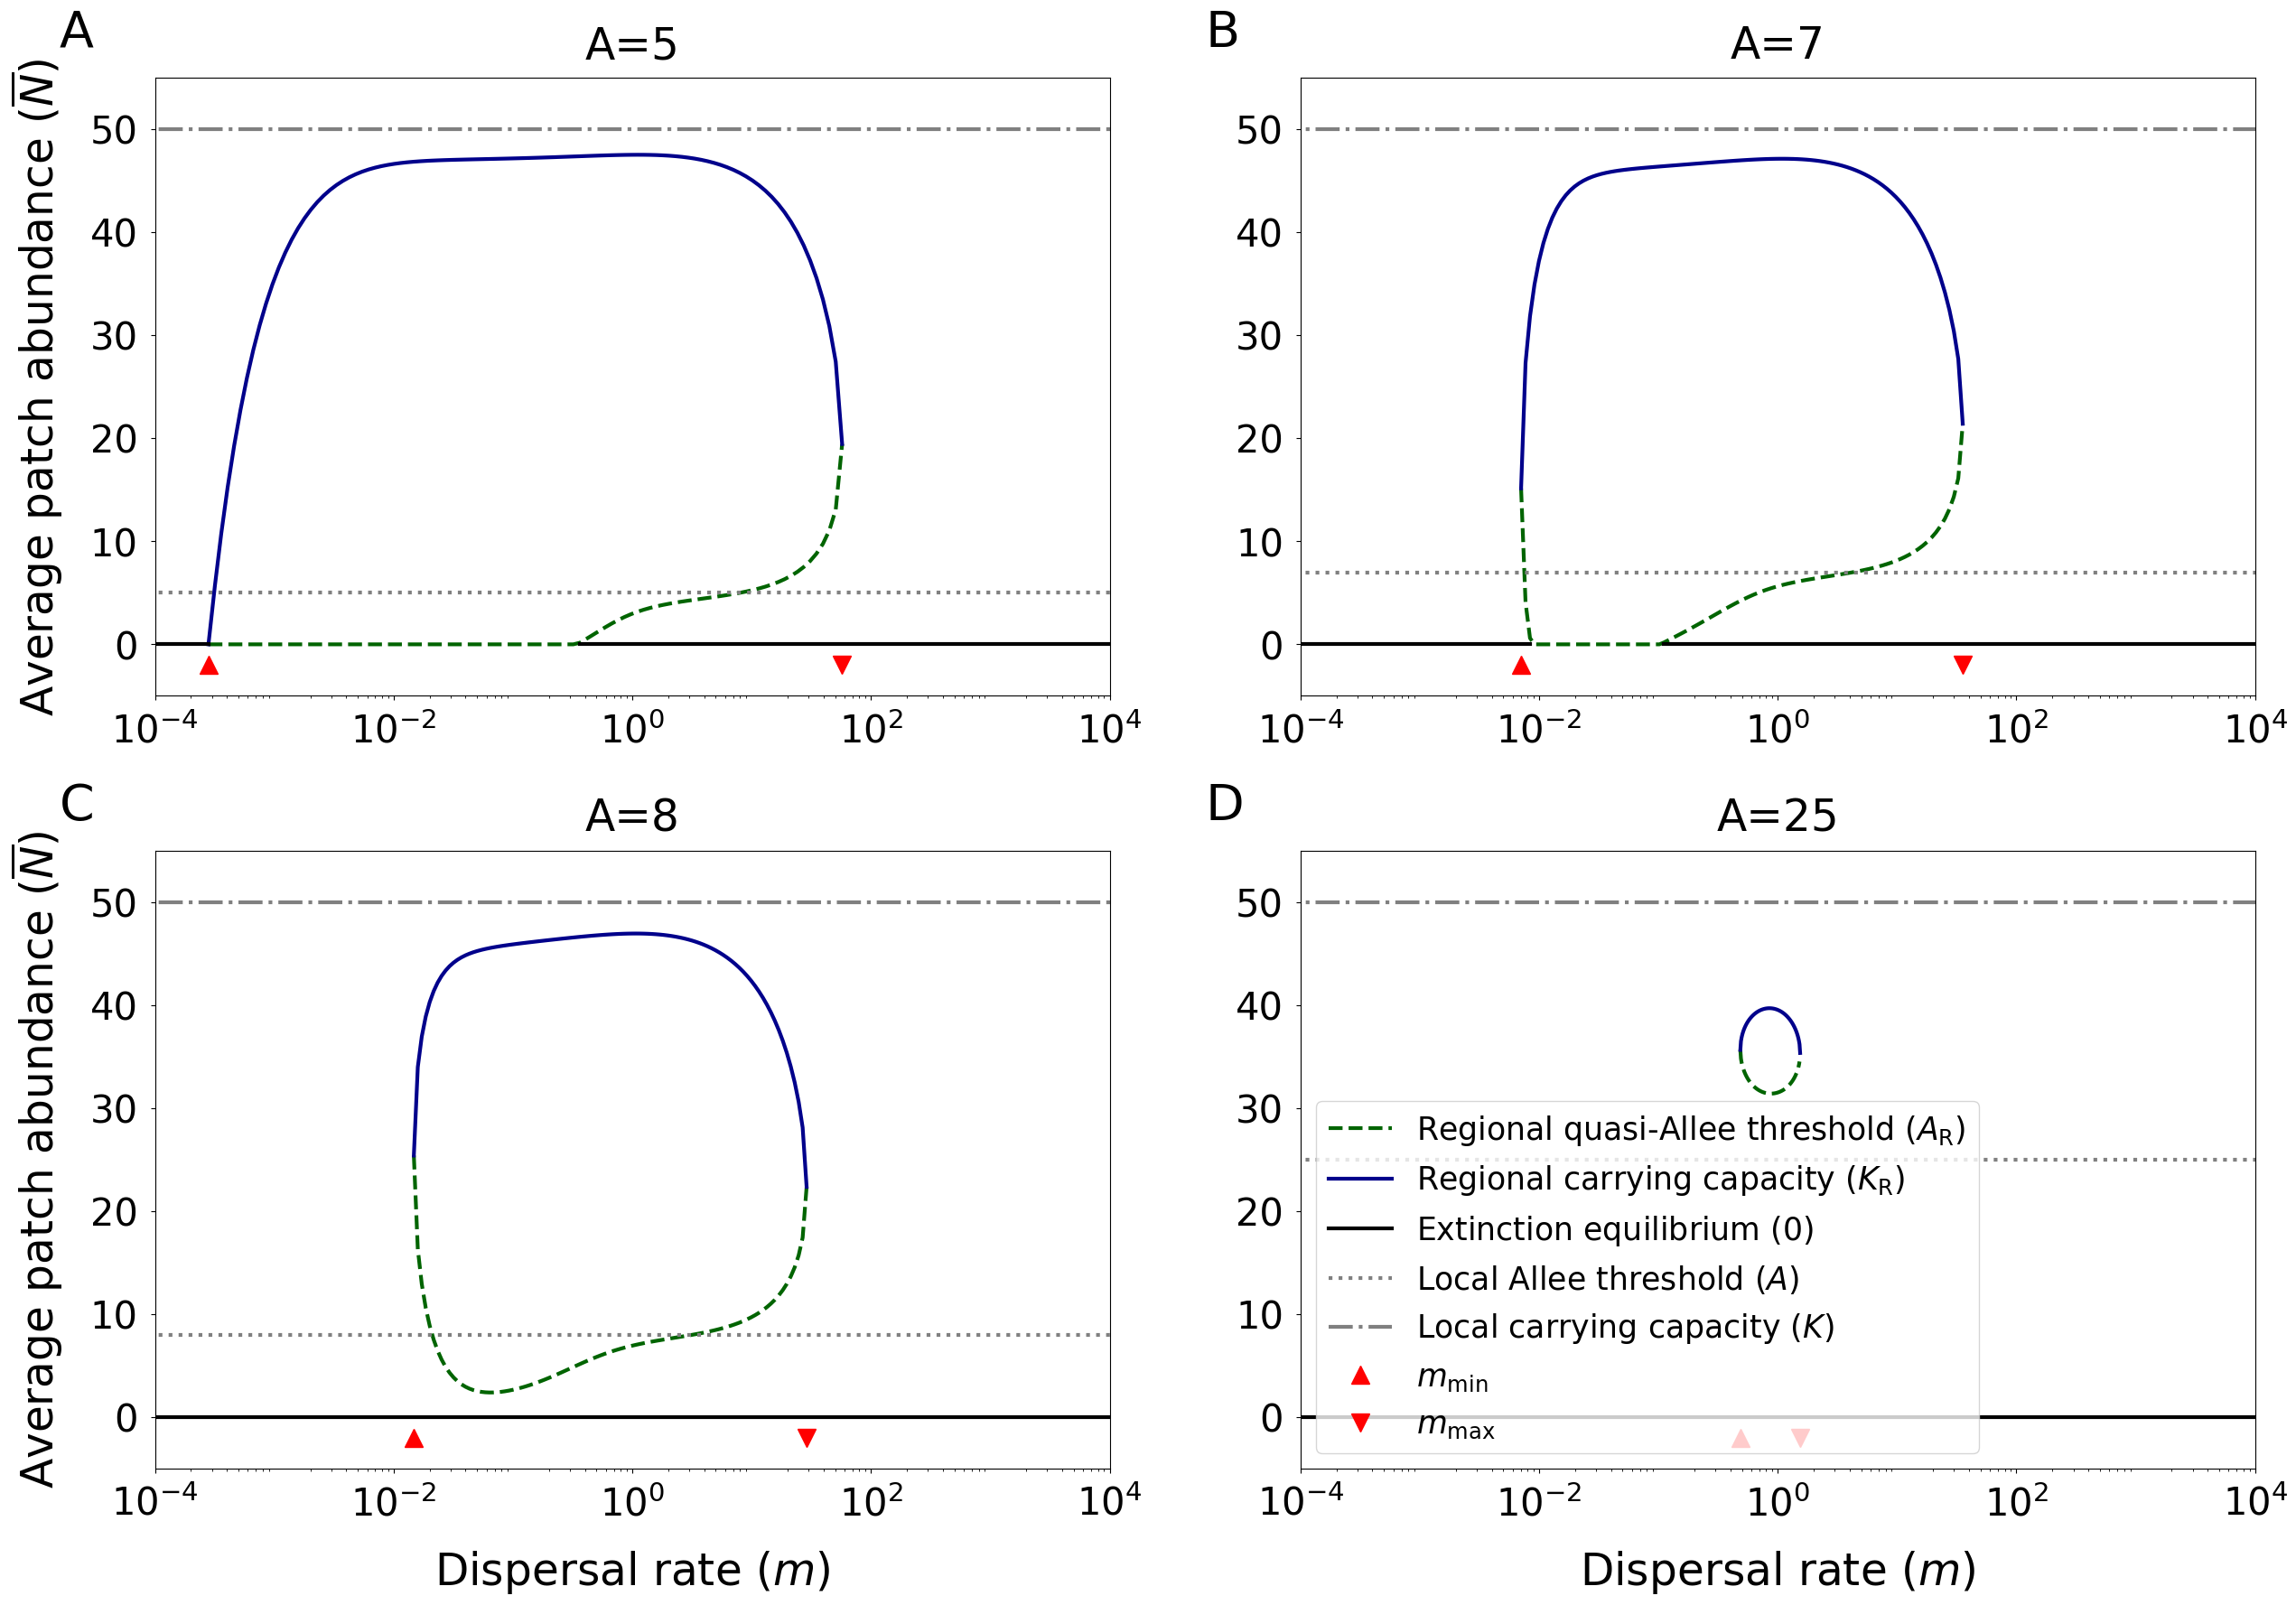

In [26]:
A_values = [5, 7, 8, 25]
labels = ['A', 'B', 'C', 'D']

fig, ax = plt.subplots(2, 2, gridspec_kw={'hspace':0.25})
fig.set_figheight(20)
fig.set_figwidth(30)

for i in [0, 1]:
    for j in [0, 1]:
        A = A_values[2*i+j]
        data = pd.read_csv(f'{data_path}\\metapopulation_bifurcation_A={A}_r=1_K=50_a=10_x=0.0_survivor_frac=0.99.csv')
        zero_vals = data['zero_vals']

        ax[i, j].plot(data['m'], data['A_R'], label=r'Regional quasi-Allee threshold ($A_\text{R}$)', color='darkgreen', linestyle='dashed', linewidth=3)
        ax[i, j].plot(data['m'], data['K_R'], label=r'Regional carrying capacity ($K_\text{R}$)', color='darkblue', linewidth=3)
        ax[i, j].plot(np.concatenate(([1e-6], data['m'], [1e6])), np.concatenate(([0.0], zero_vals, [0.0])), color='black', linewidth=3, label=r'Extinction equilibrium ($0$)')
        ax[i, j].hlines(y=A, xmin=0, xmax=1e7, colors='grey', linestyles='dotted', linewidth=3, label = r'Local Allee threshold ($A$)')
        ax[i, j].hlines(y=50, xmin=0, xmax=1e7, colors='grey', linestyles='dashdot', linewidth=3, label = r'Local carrying capacity ($K$)')

        ax[i, j].set_xlim(1e-4, 1e4)
        ax[i, j].set_ylim(-5, 55)
        ax[i, j].set_xscale('log')
        ax[i, j].tick_params(labelsize=30, pad=10)
        ax[i, j].set_xticks(ticks=[1e-4, 1e-2, 1e0, 1e2, 1e4])
        ax[i, j].set_title(f'A={A}', fontsize=35, pad=15)
        ax[i, j].text(-0.1, 1.05, labels[2*i+j], fontsize=40, transform=ax[i, j].transAxes)


        # mark m_min in every figure
        ax[i, j].plot(data['m'][0], -2, ls='', marker='^', markersize=15, color='red', label=r'$m_\text{min}$')
        ax[i, j].plot(data['m'][len(data['m'])-1], -2, ls='', marker='v', markersize=15, color='red', label=r'$m_\text{max}$')

ax[0, 0].set_ylabel(r'Average patch abundance ($\overline{N}$)', fontsize=35, labelpad=20)
ax[1, 0].set_ylabel(r'Average patch abundance ($\overline{N}$)', fontsize=35, labelpad=20)

ax[1, 0].set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=20)
ax[1, 1].set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=20)
ax[1, 1].legend(fontsize=25, loc='lower left', bbox_to_anchor=(0.0, 0., 1, 1))

plt.savefig(f'{fig_path}\\figsS7.pdf', bbox_inches='tight', pad_inches=0.1)


### Fig. S8

The following block of code may take up to several minutes to run.

In [146]:
AR_data = pd.read_csv(f'{data_path}\\AR_data_r=1_K=50_a=10_x=0_survivor_frac=1.csv', index_col=0, header=0)

A_values = AR_data.columns.to_numpy(dtype=float)
m_values = AR_data.index.to_numpy(dtype=float)

AR_data = AR_data.to_numpy()

dominant_eigenvals = np.full((len(m_values), len(A_values)), np.nan)

for i, m in enumerate(m_values):
    for j, A in enumerate(A_values):
        if A < 8.0:
            jacobian =  csr_matrix(get_jacobian(m=m, A=A, NR=0.0, r=1.0, K=50, a=10.0, x=0.0, survivor_frac=1.0))
            eigenvalues, eigenvector = eigs(jacobian, k=1, which='LR')

            dominant_eigenvals[i, j] = np.max(eigenvalues.real)

data_AR = pd.DataFrame(dominant_eigenvals, columns=A_values, index=m_values)
data_AR.to_csv(f'{data_path}\\eigenvalues_LR.csv')

Draw the figure.

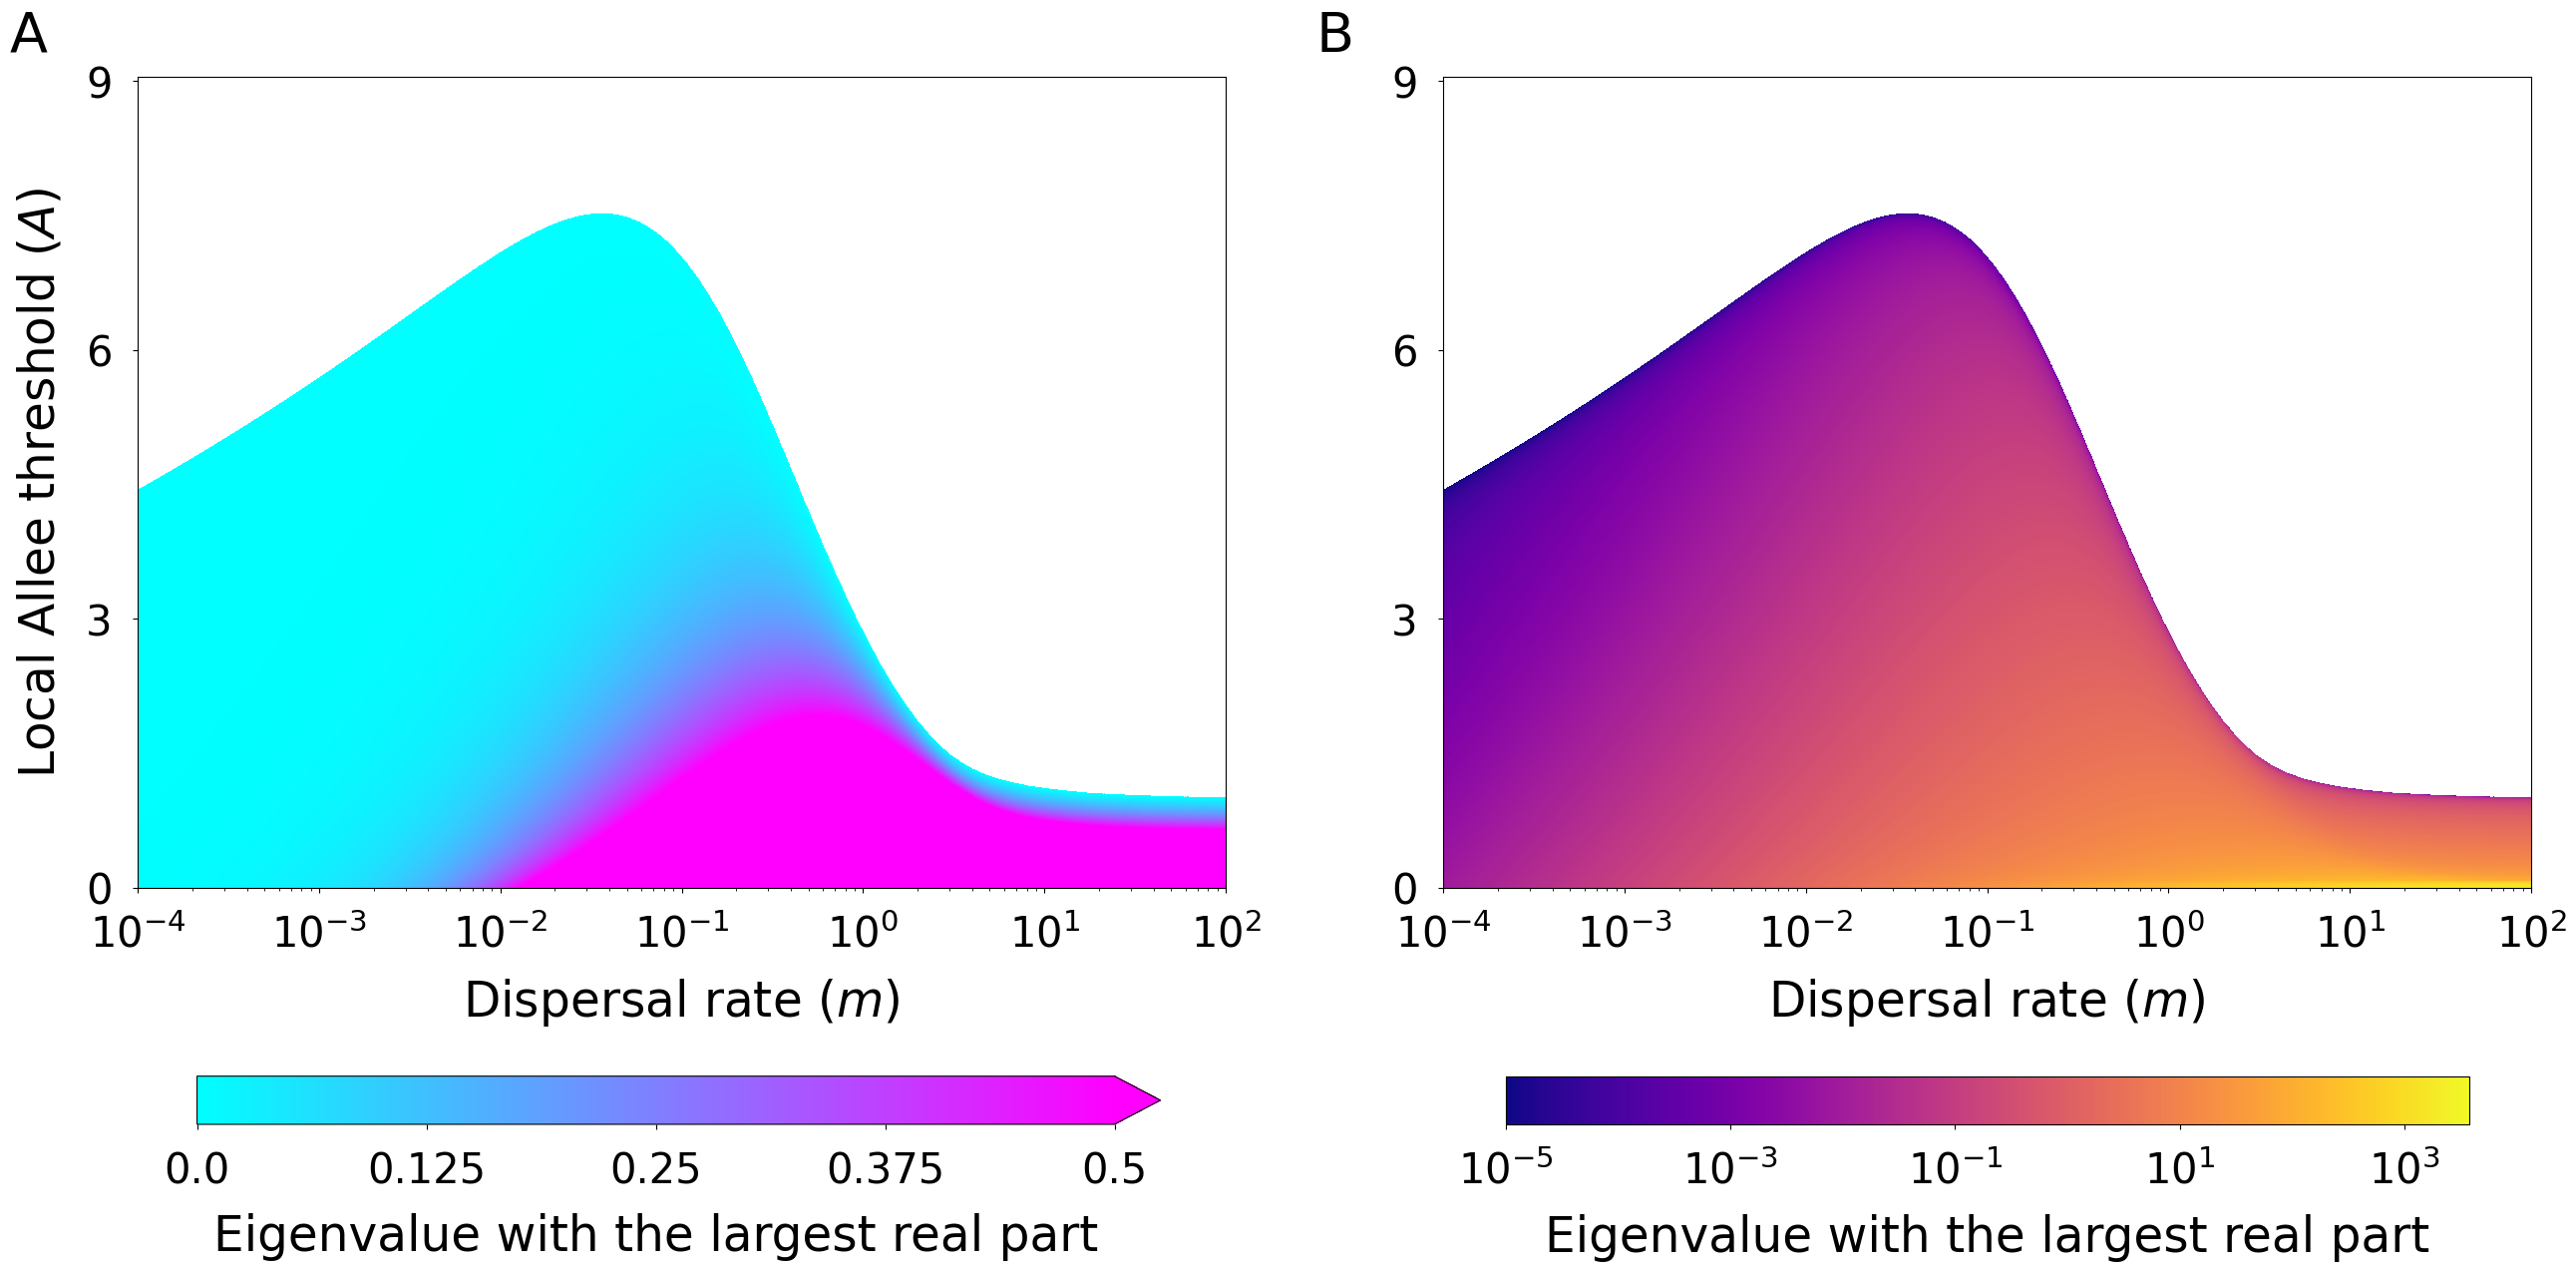

In [32]:
dominant_eigenvals = pd.read_csv(f'{data_path}\\eigenvalues_LR.csv', index_col=0)
m_values = dominant_eigenvals.index.to_numpy()
A_values = dominant_eigenvals.columns.to_numpy()

log_color_scale = False

fig, ax = plt.subplots(1, 2, figsize=(30, 15))

norm = mcolors.Normalize(vmin=0, vmax=0.5)

for i in [0, 1]:

    if i == 1:
        cntr = ax[i].contourf(m_values, A_values, dominant_eigenvals.to_numpy().T, cmap='plasma',
                    levels= np.concatenate((np.logspace(-5, 1, 1000, endpoint=False), np.logspace(1, 2.5, 100))), 
                    norm='log')
        ax[i].text(-0.1, 1.05, 'B', horizontalalignment='center', verticalalignment='center', fontsize=40, transform=ax[i].transAxes)
    else:
        cntr = ax[i].contourf(m_values, A_values, dominant_eigenvals.to_numpy().T, cmap='cool',
                    levels= np.concatenate((np.logspace(-5, 1, 1000, endpoint=False), np.logspace(1, 2.5, 100))), 
                    norm=norm)
        ax[i].set_ylabel(r'Local Allee threshold ($A$)', fontsize=35, labelpad=15)
        ax[i].text(-0.1, 1.05, 'A', horizontalalignment='center', verticalalignment='center', fontsize=40, transform=ax[i].transAxes)


    ax[i].set_xscale('log')
    ax[i].set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=15)
    ax[i].tick_params(labelsize=30, pad=15)
    ax[i].set_yticks(ticks=np.linspace(0, len(A_values)-1, 6), labels=np.linspace(0, 15, 6, dtype=int))
    ax[i].set_xlim(1e-4, 100)
    ax[i].set_ylim(0, 120)

    if i == 1:
        cbar=plt.colorbar(cntr, ax=ax[i], orientation='horizontal', fraction=0.046, pad=0.18, extend='max')
        cbar.set_ticks(ticks=np.logspace(-5, 2, 5), 
                       labels=[r'$10^{-5}$', r'$10^{-3}$', r'$10^{-1}$', r'$10^{1}$',r'$10^{3}$'], fontsize=30)
    else:
        cbar = plt.colorbar(cm.ScalarMappable(cmap='cool', norm=norm), ax=ax[i], orientation='horizontal', fraction=0.046, pad=0.18,
                            extend='max')
        cbar.set_ticks(ticks=np.linspace(0, 0.5, 5), labels=np.around(np.linspace(0, 0.5, 5), 3), fontsize=30)

    cbar.set_label('Eigenvalue with the largest real part', fontsize=35, labelpad=15)
    cbar.ax.tick_params(pad=15)
 
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

plt.savefig(f'{fig_path}\\figS8.pdf', bbox_inches='tight', pad_inches=0.1)


### Fig. S9

Time series for different values of $A$.

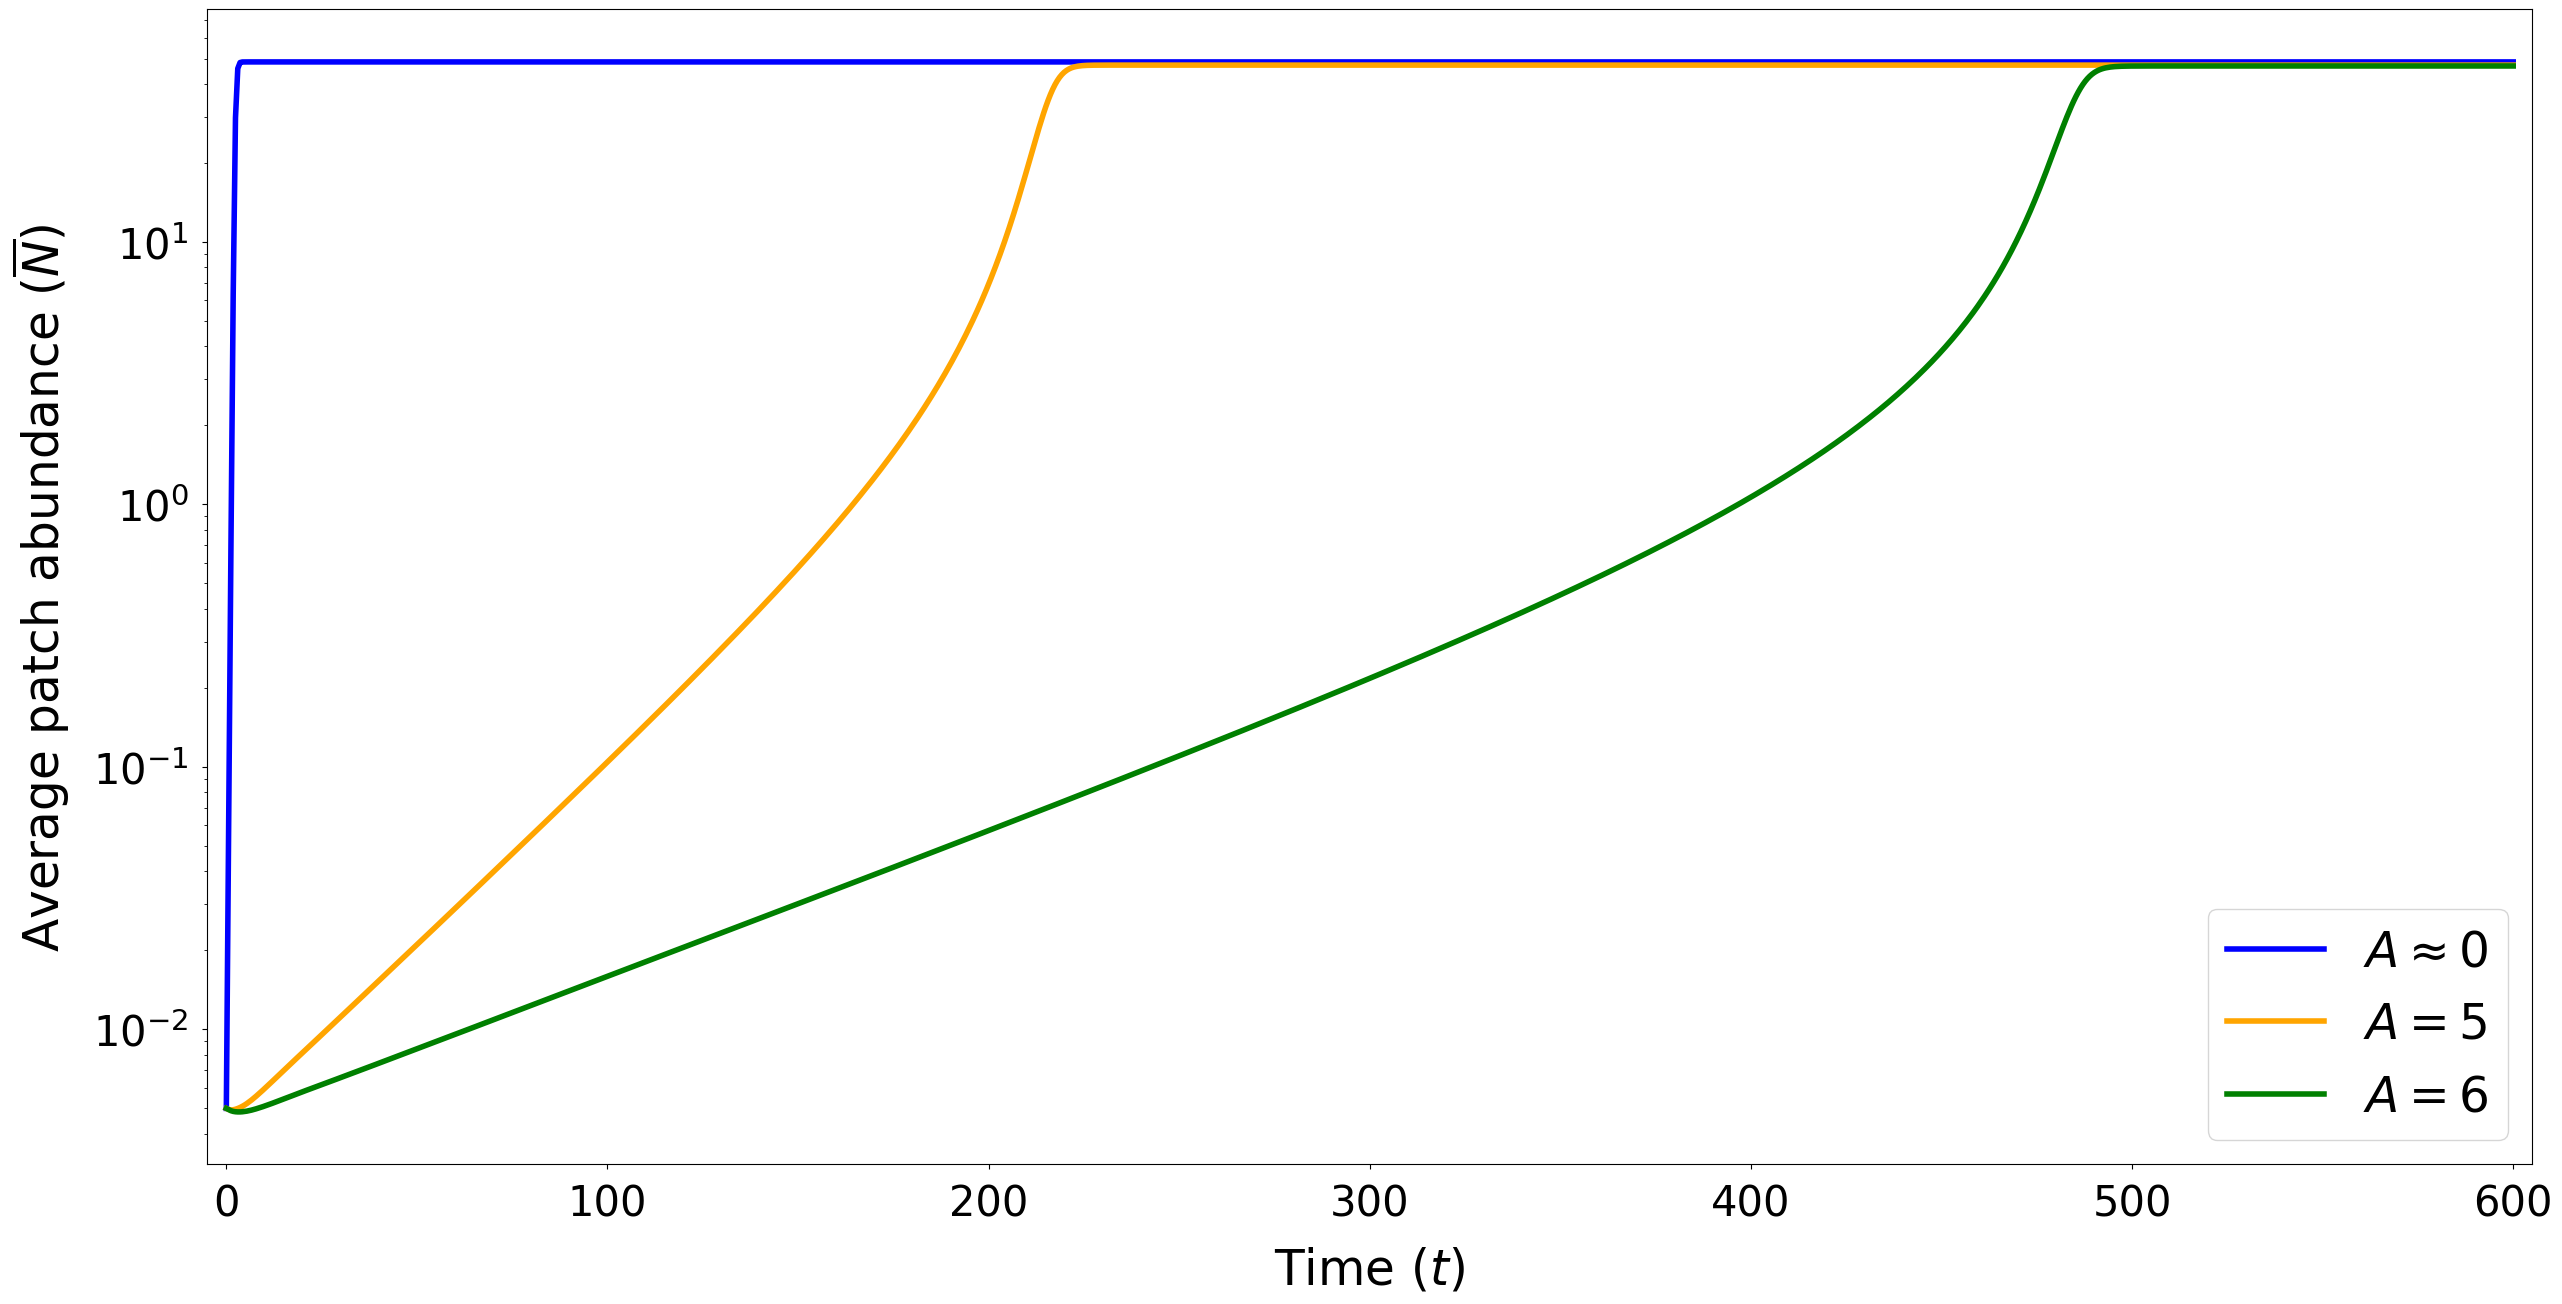

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(30, 15))

A_values = [1e-4, 5, 6]
colors = ['blue', 'orange', 'green']
labels = [r'$A\approx 0$', r'$A=5$', r'$A=6$']

for i, A in enumerate(A_values):
    distribution_ts = numerically_integrate(0.1, A, initial_conditions=np.concatenate(([1], np.zeros(49), [1e-4], np.zeros(50))), 
                                            r=1, a=10, K=50, x=0, survivor_frac=1., t_span=[0, 600], 
                                            t_eval=np.linspace(0, 600, 1000), return_ts=True)
    nr_vs_t = [np.dot(np.arange(0, 101, 1), distribution_ts.y[:, i]/sum(distribution_ts.y[:, i])) for i in range(distribution_ts.y.shape[1])]

    ax.plot(distribution_ts.t, nr_vs_t, color=colors[i], label=labels[i], linewidth=4)
    
ax.set_xlabel(r'Time ($t$)', fontsize=35, labelpad=15)
ax.set_ylabel(r'Average patch abundance ($\overline{N}$)', fontsize=35, labelpad=15)
ax.set_yscale('log')
ax.set_xlim(-5, 605)
ax.legend(fontsize=35)

ax.tick_params(axis='both', which='major', labelsize=30, pad=10)

plt.savefig(f'{fig_path}\\figS9.pdf', bbox_inches='tight', pad_inches=0.1)


### Fig. S10

In [94]:
initial_guesses = [0, 1, 2, 3, 4, 5, 10, 20, 30, 40, 50, 60]

m_values = np.logspace(-3, 3, 1000)

higher_stable_pts = np.full(len(m_values), np.nan)
lower_stable_pts = np.full(len(m_values), np.nan)
unstable_pts = np.full(len(m_values), np.nan)

for i, m in enumerate(m_values):
    equilibrim_points = find_equilibrium_points(m, initial_guesses, NR=60)
    stable_points, unstable_points = check_stability(equilibrim_points, m)

    higher_stable_pts[i] = max(stable_points)

    if len(stable_points) == 2:
        lower_stable_pts[i] = min(stable_points)
        unstable_pts[i] = unstable_points[0]

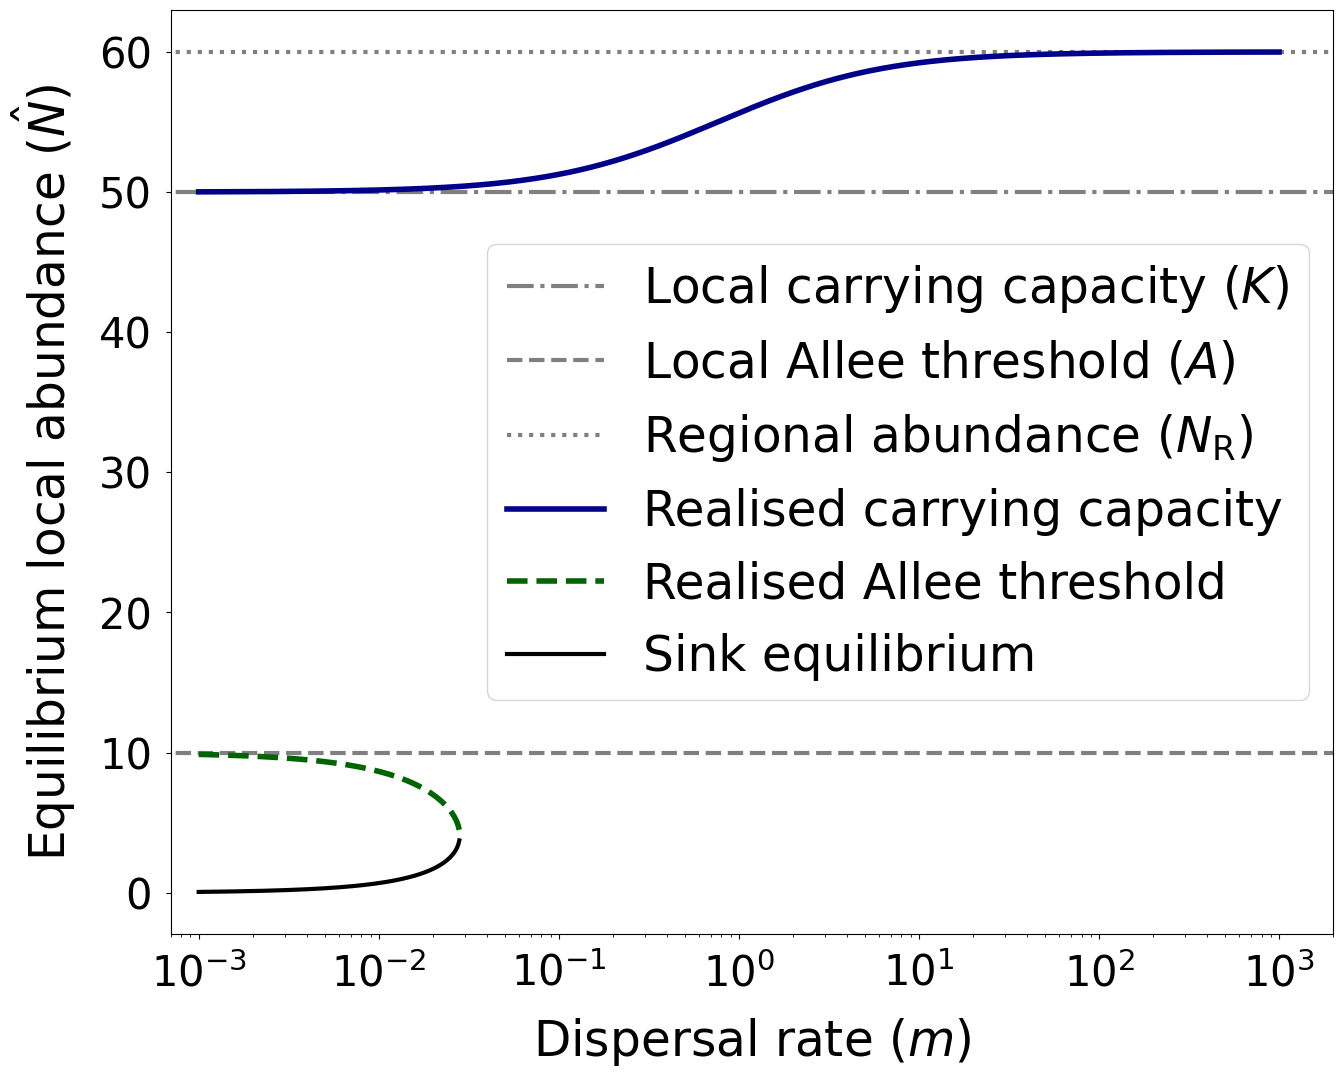

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))

ax.hlines(y=50, xmin=0, xmax=1e7, colors='grey', linestyles='-.', linewidth=3, label = r'Local carrying capacity ($K$)')
ax.hlines(y=10, xmin=0, xmax=1e7, colors='grey', linestyles='--', linewidth=3, label = r'Local Allee threshold ($A$)')
ax.hlines(y=60, xmin=0, xmax=1e7, colors='grey', linestyles=':', linewidth=3, label = r'Regional abundance ($N_\text{R}$)')
ax.plot(m_values, higher_stable_pts, label=r'Realised carrying capacity', color='darkblue', linewidth=4)
ax.plot(m_values, unstable_pts, label=r'Realised Allee threshold', color='darkgreen', linestyle='dashed', linewidth=4)
ax.plot(m_values, lower_stable_pts, label=r'Sink equilibrium', color='black', linewidth=3)
ax.set_xlim(7e-4, 2e3)
ax.set_xscale('log')
ax.set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=15)
ax.set_ylabel(r'Equilibrium local abundance ($\hat{N}$)', fontsize=35, labelpad=15)
ax.tick_params(labelsize=30, pad=10)
ax.legend(fontsize=35, loc='center right')

plt.savefig(f'{fig_path}\\figS10.pdf', bbox_inches='tight', pad_inches=0.1)


### Fig. S11

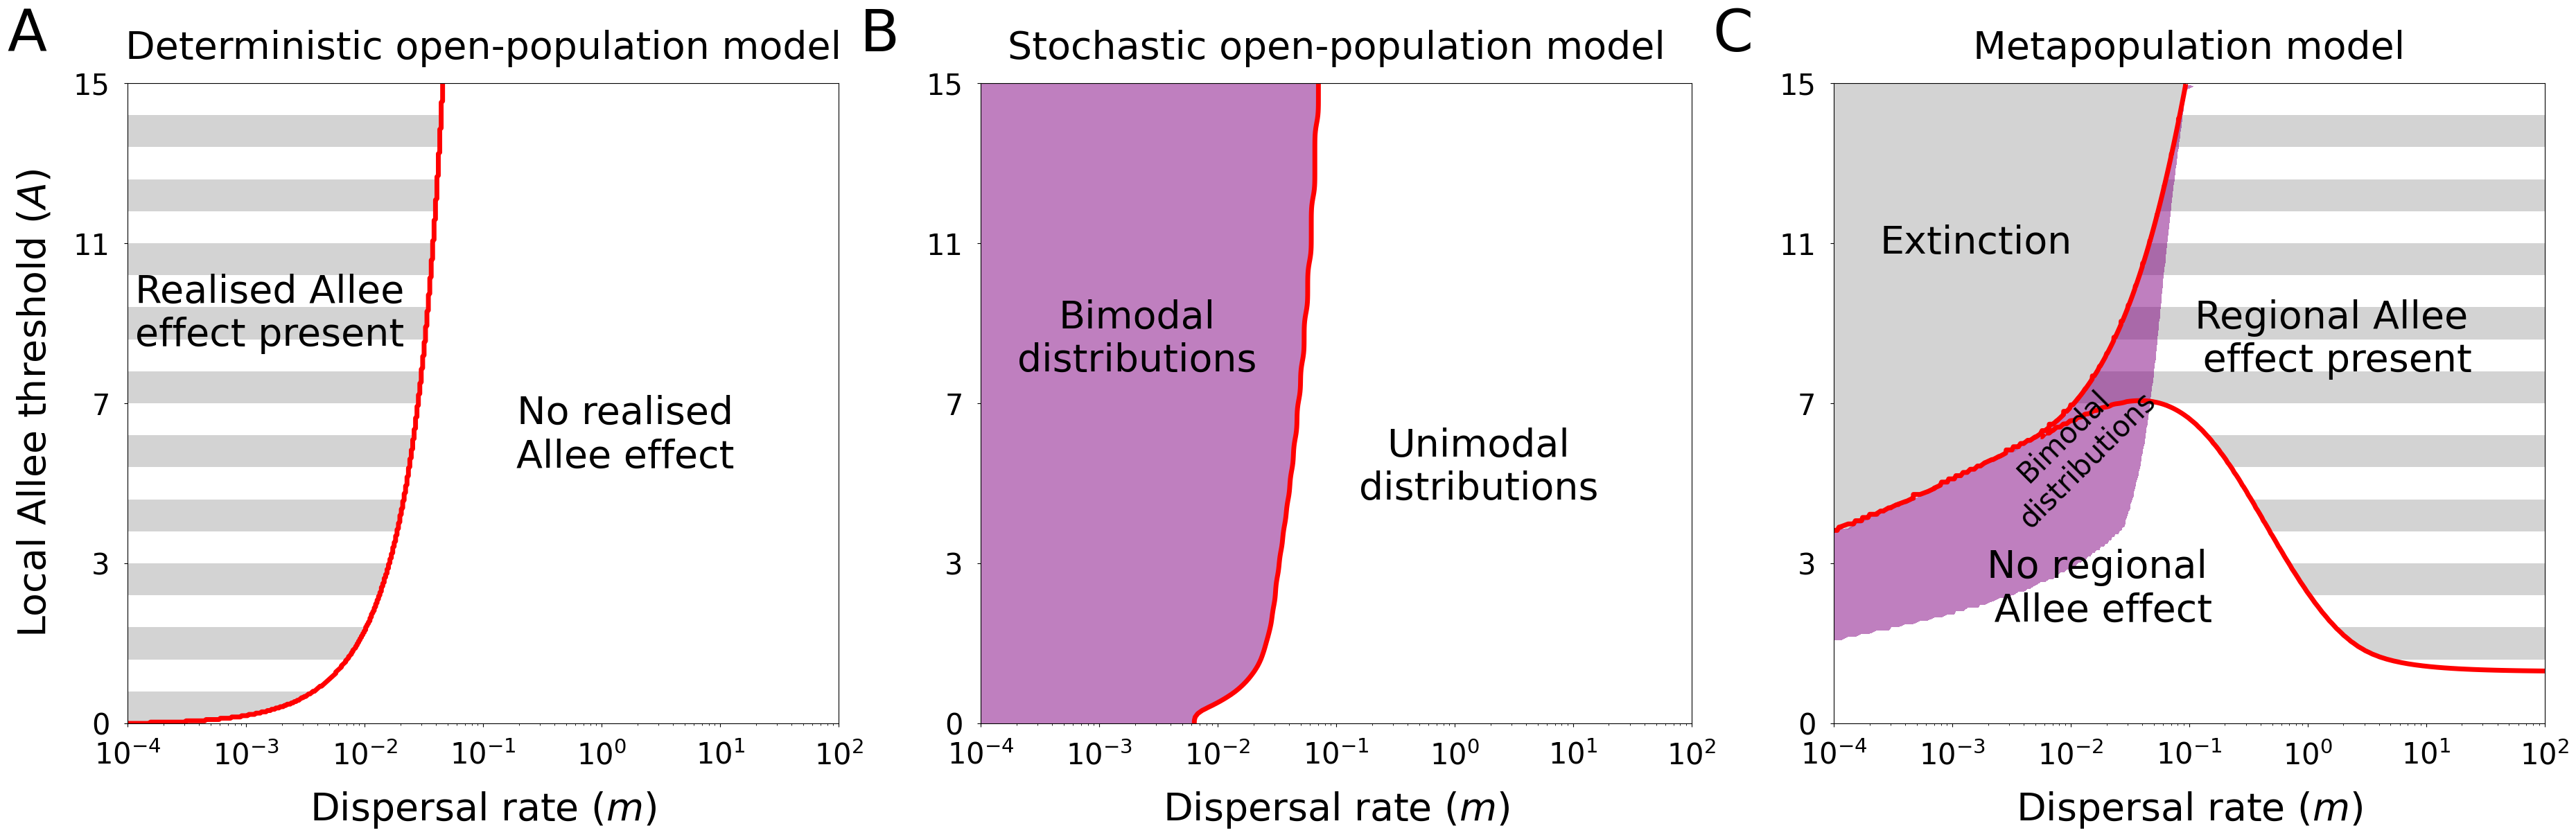

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(45, 12))
ax0, ax1, ax2 = ax

deterministic_data = pd.read_csv(f'{data_path}\\deterministic_unstable_point.csv', index_col=0)
stochastic_data = pd.read_csv(f'{data_path}\\stochastic_open_peak_nums.csv', index_col=0)
metapopulation_data_AR = pd.read_csv(f'{data_path}\\AR_data_r=1_K=50_a=10_x=0_survivor_frac=1.csv', index_col=0)
metapopulation_data_KR = pd.read_csv(f'{data_path}\\KR_data_r=1_K=50_a=10_x=0_survivor_frac=1.csv', index_col=0)
metapopulation_data_peak_num = pd.read_csv(f'{data_path}\\metapopulation_peak_nums.csv', index_col=0)

m_values = deterministic_data.index.to_numpy()
A_values = deterministic_data.columns.to_numpy()

# add strips to represent bistability; other things are plotted on top of them
for i in np.arange(0, 1, 0.1):
    ax0.fill([0, 1, 1, 0], [i, i, i+0.05, i+0.05], 'lightgrey', transform=ax0.transAxes)

ax0.contour(m_values, A_values, deterministic_data.to_numpy().T, levels=[0.0], colors='red', linewidths=5)
ax0.contourf(m_values, A_values, deterministic_data.to_numpy().T, levels=[-1, 0], colors='white')
ax0.set_xscale('log')
ax0.set_xlabel(r'Dispersal rate ($m$)', fontsize=40, labelpad=20)
ax0.set_ylabel(r'Local Allee threshold ($A$)', fontsize=40, labelpad=20)
ax0.tick_params(labelsize=30, pad=15)
ax0.set_title('Deterministic open-population model', fontsize=40, pad=25)
ax0.text(-0.17, 1.05, 'A', fontsize=60, transform=ax0.transAxes)
ax0.set_yticks(ticks=np.linspace(0, len(A_values)-1, 5), labels=np.linspace(0, 15, 5, dtype=int))
ax0.text(0.2, 0.64, 'Realised Allee\neffect present', fontsize=40, transform=ax0.transAxes, ha='center', va='center')
ax0.text(0.7, 0.45, 'No realised\nAllee effect', fontsize=40, transform=ax0.transAxes, ha='center', va='center')

m_values = stochastic_data.index.to_numpy()
A_values = stochastic_data.columns.to_numpy()
peak_nums = gaussian_filter(stochastic_data.to_numpy(), 2.5)

ax1.contour(m_values, A_values, peak_nums.T, levels=[1.5], colors='red', linewidths=5)
ax1.contourf(m_values, A_values, peak_nums.T, levels=[1.5, 2], colors='purple', alpha=0.5)
ax1.set_xscale('log')
ax1.set_xlabel(r'Dispersal rate ($m$)', fontsize=40, labelpad=20)
ax1.tick_params(labelsize=30, pad=15)
ax1.set_title('Stochastic open-population model', fontsize=40, pad=25)
ax1.set_yticks(ticks=np.linspace(0, len(A_values)-1, 5), labels=np.linspace(0, 15, 5, dtype=int))
ax1.text(-0.17, 1.05, 'B', fontsize=60, transform=ax1.transAxes)
ax1.text(0.22, 0.6, 'Bimodal\ndistributions', fontsize=40, transform=ax1.transAxes, ha='center', va='center')
ax1.text(0.7, 0.4, 'Unimodal\ndistributions', fontsize=40, transform=ax1.transAxes, ha='center', va='center')

m_values = metapopulation_data_AR.index.to_numpy()
A_values = metapopulation_data_AR.columns.to_numpy()

# add strips to represent bistability; other things are plotted on top of them
for i in np.arange(0, 1, 0.1):
    ax2.fill([0, 1, 1, 0], [i, i, i+0.05, i+0.05], 'lightgrey', transform=ax2.transAxes)

ax2.contour(m_values[m_values>5e-3], A_values, metapopulation_data_AR.to_numpy().T[:, m_values>5e-3], 
            levels=[0.25], colors='red', linewidths=5)

ax2.contourf(m_values, A_values, metapopulation_data_AR.to_numpy().T, 
            levels=[0, 0.25], colors=['white'])

ax2.contour(m_values, A_values, metapopulation_data_KR.to_numpy().T, levels=[1e-4], colors='red', linewidths=5)
ax2.contourf(m_values, A_values, metapopulation_data_KR.to_numpy().T, levels=[0, 1e-4], colors='lightgrey')

ax2.contourf(m_values, A_values, metapopulation_data_peak_num.to_numpy().T, levels=[1, 2], colors='purple', alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlabel(r'Dispersal rate ($m$)', fontsize=40, labelpad=20)
ax2.tick_params(labelsize=30, pad=15)
ax2.set_title('Metapopulation model', fontsize=40, pad=25)
ax2.set_yticks(ticks=np.linspace(0, len(A_values)-1, 5), labels=np.linspace(0, 15, 5, dtype=int))
ax2.text(-0.17, 1.05, 'C', fontsize=60, transform=ax2.transAxes)
ax2.text(0.2, 0.75, 'Extinction', fontsize=40, transform=ax2.transAxes, ha='center', va='center')
ax2.text(0.37, 0.21, 'No regional\n Allee effect', fontsize=40, transform=ax2.transAxes, ha='center', va='center')
ax2.text(0.7, 0.6, 'Regional Allee\n effect present', fontsize=40, transform=ax2.transAxes, ha='center', va='center')
ax2.text(0.34, 0.43, 'Bimodal\ndistributions', fontsize=30, transform=ax2.transAxes, ha='center', va='center', rotation=45)

plt.savefig(f'{fig_path}\\figS11.pdf', bbox_inches='tight', pad_inches=0.1)


### Fig. S12

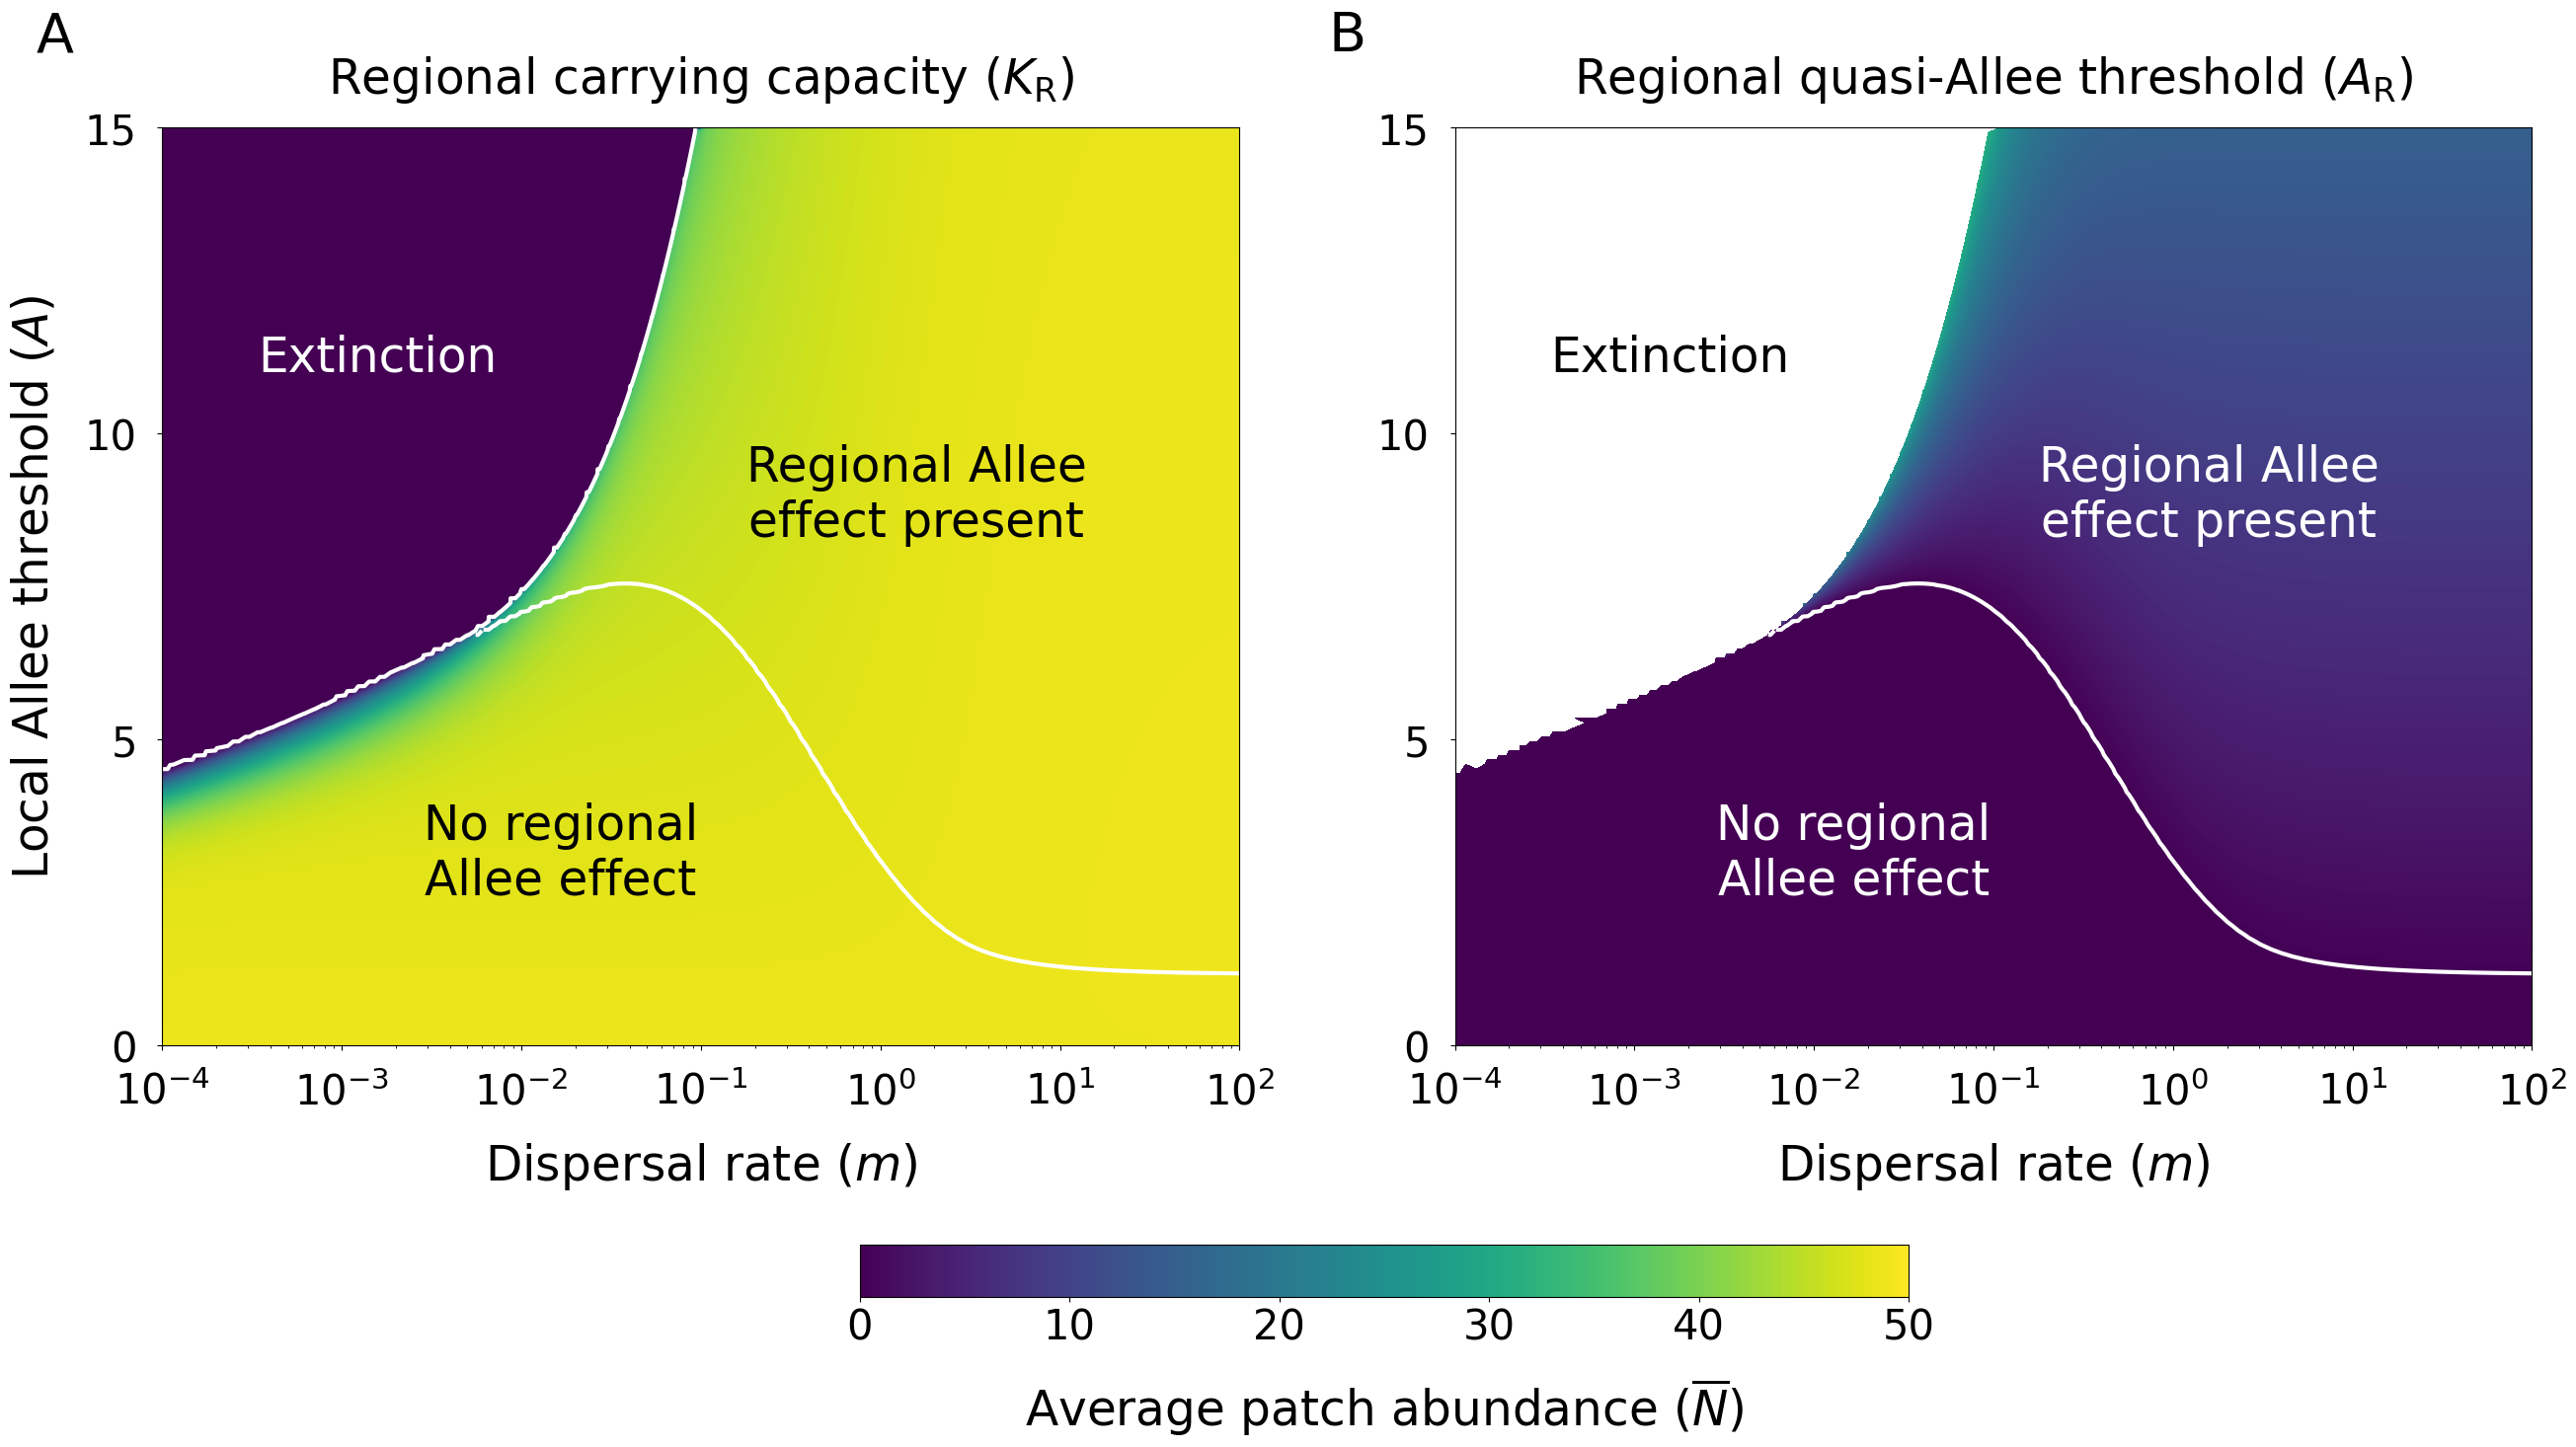

In [113]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np


AR_data = pd.read_csv(f'{data_path}\\AR_data_r=1_K=50_a=10_x=0_survivor_frac=1.csv', index_col=0)
KR_data = pd.read_csv(f'{data_path}\\KR_data_r=1_K=50_a=10_x=0_survivor_frac=1.csv', index_col=0)
KR_data.fillna(0.0, inplace=True)

A_values = AR_data.columns.to_numpy()
m_values = AR_data.index.to_numpy()

fig, ax = plt.subplots(1, 2)
fig.set_figheight(15)
fig.set_figwidth(30)

norm = mcolors.Normalize(vmin=0, vmax=50)

ax[0].contourf(m_values, A_values, KR_data.to_numpy().T, cmap='viridis', levels=1000, norm=norm)
ax[0].contour(m_values[m_values>5e-3], A_values, AR_data.to_numpy().T[:, m_values>5e-3], colors='white', levels=[0.2], linewidths=3)
ax[0].contour(m_values, A_values, KR_data.to_numpy().T, colors='white', levels=[0.15], linewidths=3)

# add text
ax[0].text(-0.1, 1.1, 'A', horizontalalignment='center', verticalalignment='center', fontsize=40, transform=ax[0].transAxes)
ax[0].set_title(r'Regional carrying capacity ($K_\text{R}$)', fontsize=35, pad=25)

ax[1].contourf(m_values, A_values, AR_data.to_numpy().T, cmap='viridis', levels=1000, norm=norm)
ax[1].contour(m_values[m_values>5e-3], A_values, AR_data.to_numpy().T[:, m_values>5e-3], colors='white', levels=[0.2], linewidths=3)

ax[1].text(1.1, 1.1, 'B', horizontalalignment='center', verticalalignment='center', fontsize=40, transform=ax[0].transAxes)
ax[1].set_title(r'Regional quasi-Allee threshold ($A_\text{R}$)', fontsize=35, pad=25)

ax[0].set_ylabel(r'Local Allee threshold ($A$)', fontsize=35, labelpad=20)

colors = ['black', 'white']

for i in [0, 1]:
    ax[i].set_xscale('log')
    ax[i].set_xlabel(r'Dispersal rate ($m$)', fontsize=35, labelpad=20)
    ax[i].tick_params(labelsize=30, pad=15)
    ax[i].set_yticks(ticks=np.linspace(0, len(A_values)-1, 4), labels=np.linspace(0, 15, 4, dtype=int))
    ax[i].set_xlim(1e-4, 1e2)
    ax[i].text(0.2, 0.75, 'Extinction', fontsize=35, transform=ax[i].transAxes, ha='center', va='center', color=colors[not i])
    ax[i].text(0.37, 0.21, 'No regional\nAllee effect', fontsize=35, transform=ax[i].transAxes, ha='center', va='center', color=colors[i])
    ax[i].text(0.7, 0.6, 'Regional Allee\neffect present', fontsize=35, transform=ax[i].transAxes, ha='center', va='center', color=colors[i])

cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, orientation='horizontal', fraction=0.046, pad=0.04)
cbar.set_label(r'Average patch abundance ($\overline{N}$)', fontsize=35, labelpad=20)
cbar.set_ticks(ticks=np.linspace(0, 50, 6), labels=np.linspace(0, 50, 6, dtype=int), fontsize=30)
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.28)


plt.savefig(f'{fig_path}\\figS12.png', bbox_inches='tight', pad_inches=0.1)


### Fig. S13

Run a simulation with finitely many patches illustrating why intermediate dispersal rates do not produce regional Allee effects, whereas high dispersal rates do. First, we run the simulations showing an absence of regional Allee effects. The following block of code may take up to several minutes to run.

In [17]:
times, populations = gillespie_finite_patches(initials=np.concatenate((np.full(1, 50), np.full(99, 0))), duration=100, m=0.1, A=5, r=1, a=10, K=50,
                                  n_patch=100, rngseed=69)

df = pd.DataFrame(populations, columns=[f'patch_{i}' for i in range(100)])
df['time'] = times
df.to_csv(f'{data_path}\\gillespie_100_patches_m=0.1_A=5_r=1_a=10_K=50_X=0_survivor_frac=1.0.csv', index=False)



Then, we run the simulation showing a presence of regional Allee effects.

In [18]:
times_regional_AE, populations_regional_AE = gillespie_finite_patches(initials=np.concatenate((np.full(1, 50), np.full(99, 0))), duration=100, 
                                                            m=1.0, A=5, r=1, a=10, K=50, n_patch=100, rngseed=42)

df = pd.DataFrame(populations_regional_AE, columns=[f'patch_{i}' for i in range(100)])
df['time'] = times_regional_AE
df.to_csv(f'{data_path}\\gillespie_100_patches_m=1.0_A=5_r=1_a=10_K=50_X=0_survivor_frac=1.0.csv', index=False)



Draw the figure.

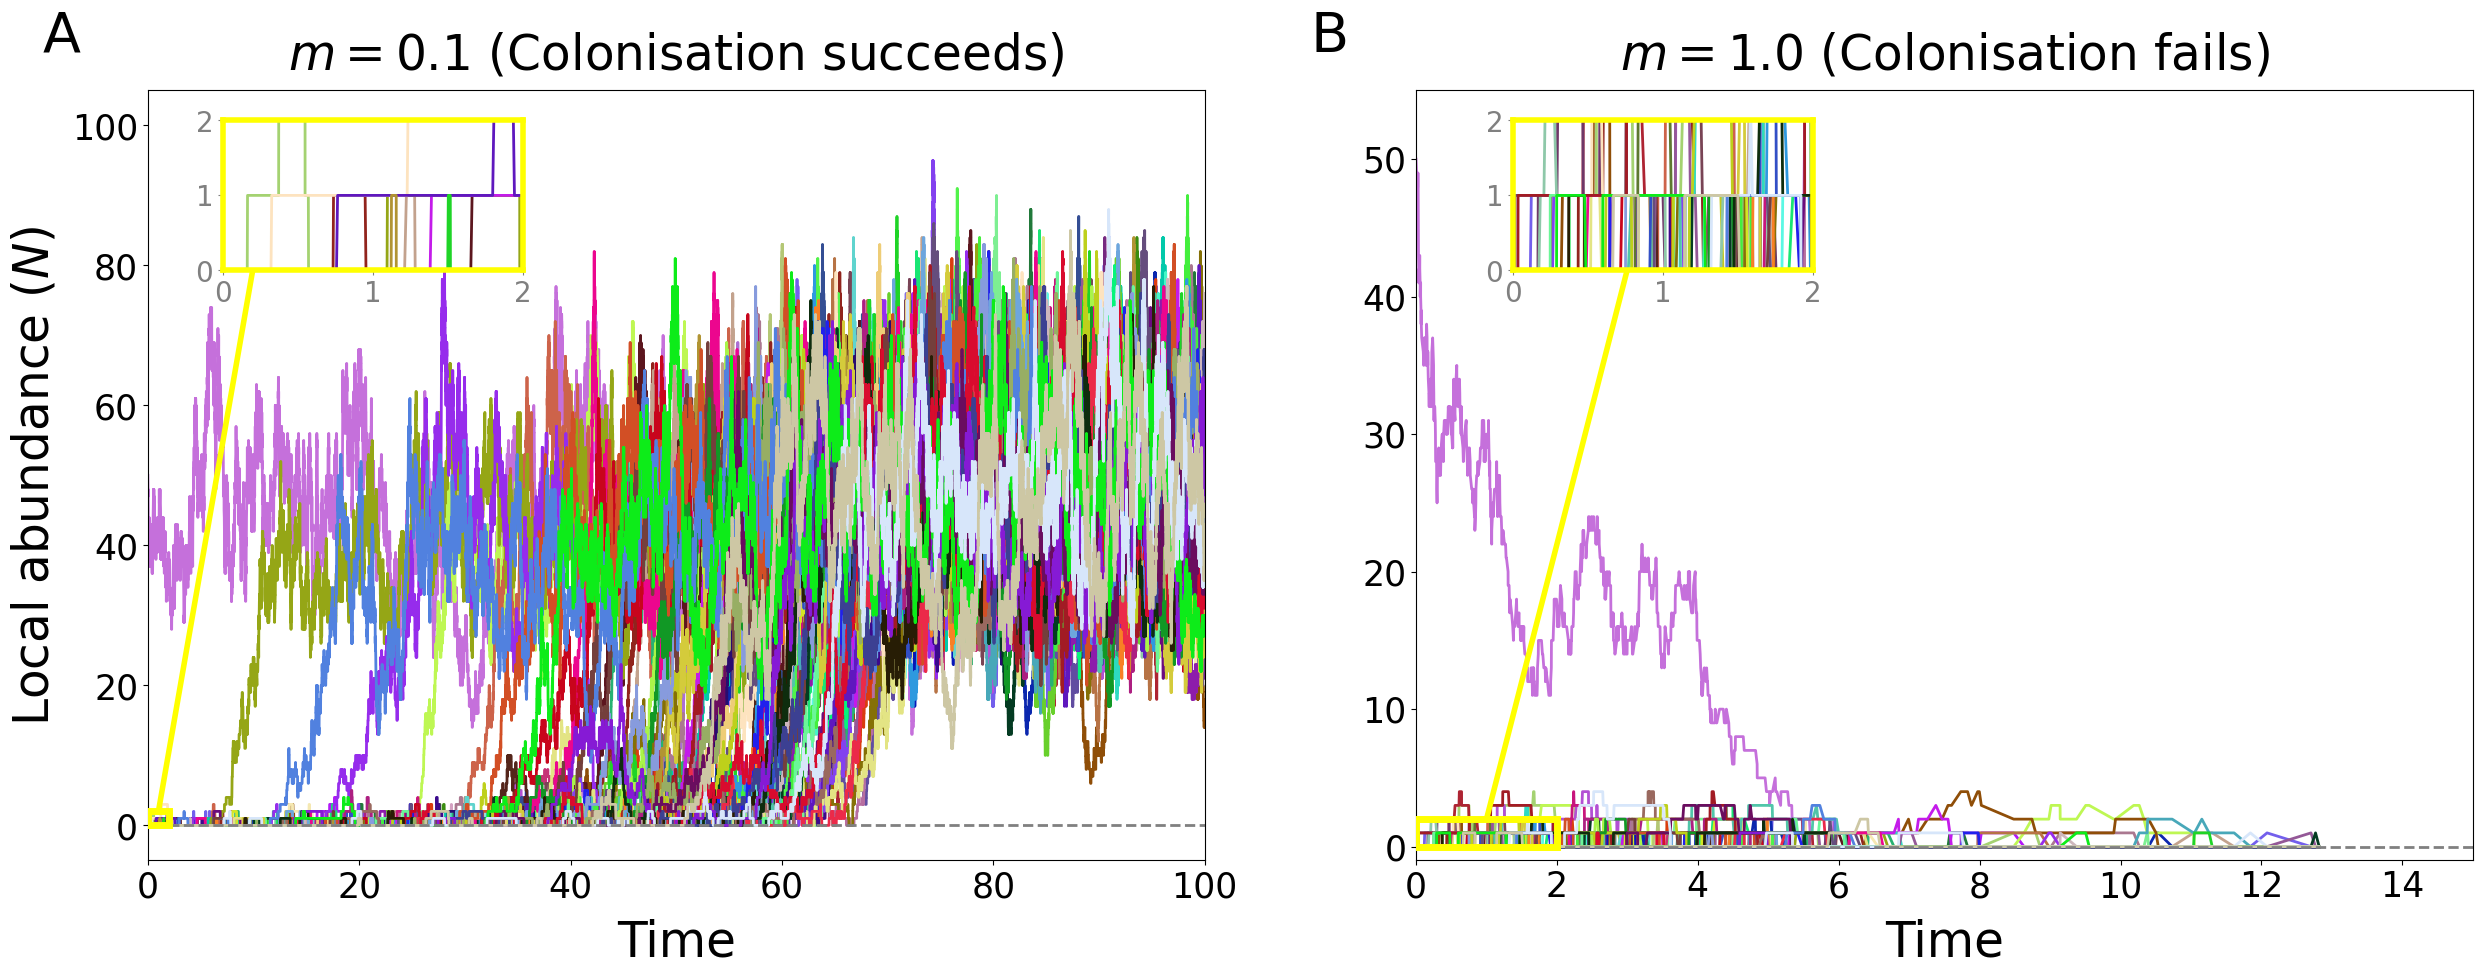

In [19]:
data_no_regional_AE = pd.read_csv(f'{data_path}\\gillespie_100_patches_m=0.1_A=5_r=1_a=10_K=50_X=0_survivor_frac=1.0.csv')
times = data_no_regional_AE['time']
populations = data_no_regional_AE.drop(columns='time').values

data_regional_AE = pd.read_csv(f'{data_path}\\gillespie_100_patches_m=1.0_A=5_r=1_a=10_K=50_X=0_survivor_frac=1.0.csv')
times_regional_AE = data_regional_AE['time']
populations_regional_AE = data_regional_AE.drop(columns='time').values

# recover complete data from the saved one
populations = recover_full_data(populations)
populations_regional_AE = recover_full_data(populations_regional_AE)


rng = np.random.default_rng(seed=42)
colors = rng.random((100, 3))

fig, ax = plt.subplots(1, 2, figsize=(30, 10))


for i in range(100):
    ax[0].plot(times, populations[:, i], color=colors[i], linewidth=2)
    ax[1].plot(times_regional_AE, populations_regional_AE[:, i], color=colors[i], linewidth=2)

for i in range(2):
    ax[i].hlines(0, -5, 105, color='grey', linewidth=2, linestyle='--')
    ax[i].tick_params(axis='both', which='major', labelsize=25)
    ax[i].set_xlabel('Time', fontsize=35, labelpad=10)

ax[0].set_ylabel(r'Local abundance ($N$)', fontsize=35, labelpad=10)

ax[0].set_xlim(0, 100)
ax[1].set_xlim(0, 15)
ax[0].set_ylim(-5, 105)
ax[1].set_ylim(-1, 55)

ax[0].text(-0.1, 1.05, 'A', transform=ax[0].transAxes, fontsize=40)
ax[1].text(-0.1, 1.05, 'B', transform=ax[1].transAxes, fontsize=40)

ax[0].set_title(r'$m=0.1$ (Colonisation succeeds)', fontsize=35, pad=15)
ax[1].set_title(r'$m=1.0$ (Colonisation fails)', fontsize=35, pad=15)

rect1 = plt.Rectangle((0, 0), 2, 2, edgecolor='yellow', facecolor='none', linewidth=5, zorder=10)
rect2 = plt.Rectangle((0, 0), 2, 2, edgecolor='yellow', facecolor='none', linewidth=5, zorder=10)
ax[0].add_patch(rect1)
ax[1].add_patch(rect2)

new_axis0 = fig.add_axes([0.15, 0.7, 0.1, 0.15])
new_axis1 = fig.add_axes([0.58, 0.7, 0.1, 0.15])

new_axis0.spines[:].set_color('yellow')
new_axis0.spines[:].set_linewidth(4)
new_axis0.tick_params(axis='both', which='major', labelsize=20, color='grey', labelcolor='grey')
new_axis0.set_xlim(0, 2)
new_axis0.set_ylim(0, 2)

new_axis1.spines[:].set_color('yellow')
new_axis1.spines[:].set_linewidth(4)
new_axis1.tick_params(axis='both', which='major', labelsize=20, color='grey', labelcolor='grey')
new_axis1.set_xlim(0, 2)
new_axis1.set_ylim(0, 2)

ax[0].plot([1, 10], [2, 80], color='yellow', linestyle='-', linewidth=4)
ax[1].plot([1, 3], [2, 42], color='yellow', linestyle='-', linewidth=4)

for i in range(100):
    new_axis0.plot(times, populations[:, i], color=colors[i], linewidth=2)
    new_axis1.plot(times_regional_AE, populations_regional_AE[:, i], color=colors[i], linewidth=2)

plt.savefig(f'{fig_path}\\figS13.png', bbox_inches='tight', pad_inches=0.1, dpi=100)

### Movie S1

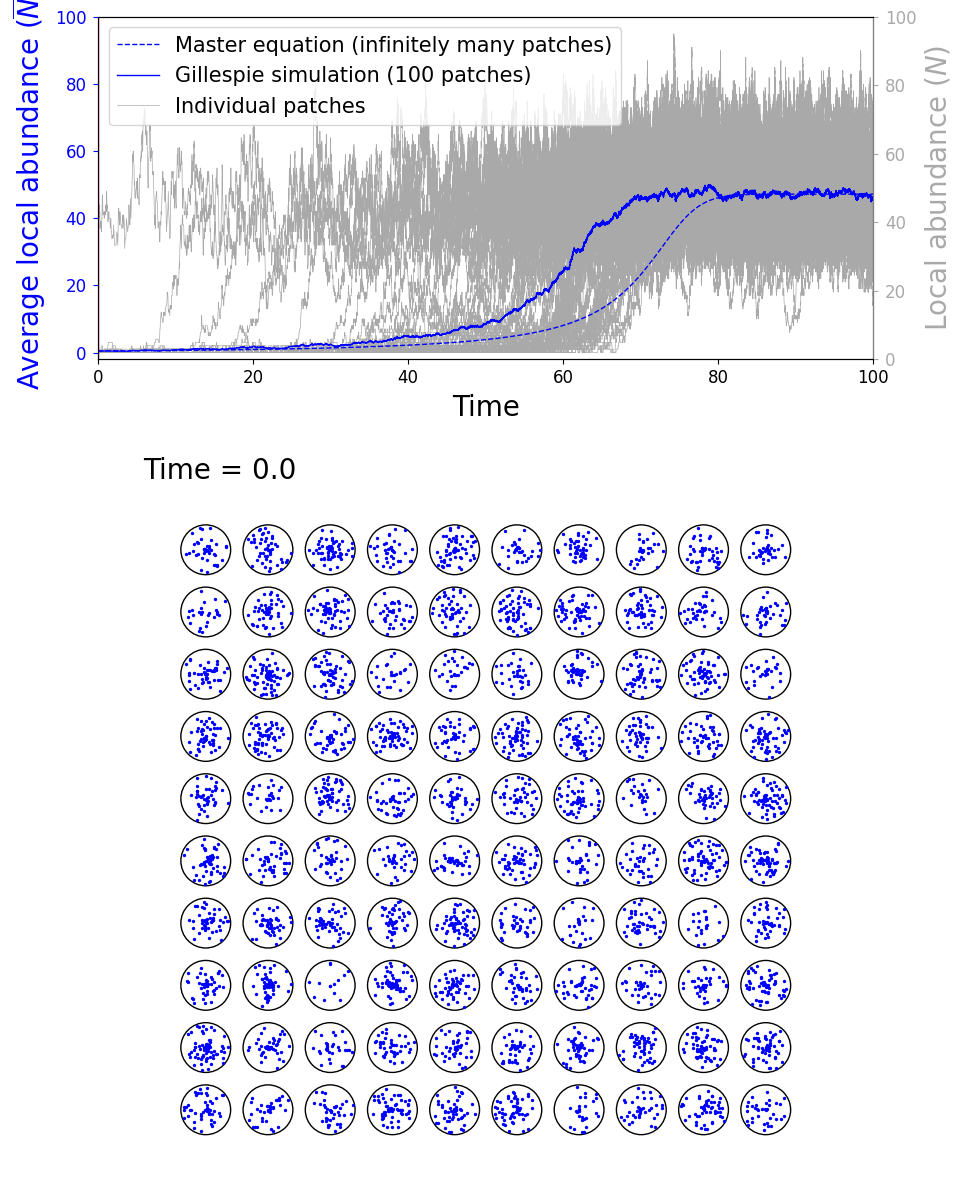

In [ ]:
data_no_regional_AE = pd.read_csv(f'{data_path}\\gillespie_100_patches_m=0.1_A=5_r=1_a=10_K=50_X=0_survivor_frac=1.0.csv')
times = data_no_regional_AE['time'].to_numpy()
populations = data_no_regional_AE.drop(columns='time').values

populations = recover_full_data(populations)

avg_population = np.sum(populations, axis=1)/100

mastereq_ts = numerically_integrate(m=0.1, A=5, initial_conditions=np.concatenate(([0.99], np.zeros(49), [0.01], np.zeros(50))),
                                                    r=1., a=10, K=50, x=0., survivor_frac=1., 
                                                    t_span=[0, 100], t_eval=np.linspace(0, 100, 1000), return_ts=True)
avg_population_from_mastereq = np.dot(np.arange(0, 101, 1), mastereq_ts.y/np.sum(mastereq_ts.y, axis=0))

patch_xy = lambda index: (index % 10, index // 10)

fig, ax = plt.subplots(2, 1, figsize=(10, 15), gridspec_kw={'height_ratios': [1, 2], 'hspace': 0.25})
ax0, ax1 = ax

ax2 = ax0.twinx()

# to speed up the plotting, we plot only a few of the available time points
plot_only_these = np.linspace(0, len(times), 100000, endpoint=False, dtype=int)

for i in range(99):
    ax0.plot(times[plot_only_these], populations[plot_only_these, i], color='darkgrey', linewidth=0.5)
ax0.plot(times[plot_only_these], populations[plot_only_these, 99], color='darkgrey', linewidth=0.5, label='Individual patches')


ax0.plot(times[plot_only_these], avg_population[plot_only_these], linewidth=1, color='blue', label='Gillespie simulation (100 patches)')
ax0.plot(mastereq_ts.t, avg_population_from_mastereq, linewidth=1, color='blue', linestyle='--',
        label='Master equation (infinitely many patches)')



ax0.set_xlim(0, 100)
ax0.set_ylim(-2, 100)
ax0.tick_params(axis='y', which='major', labelsize=12, colors='blue', pad=5)
ax0.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12, colors='darkgrey', pad=5)
ax2.set_yticks(np.linspace(0, 100, 6))
ax0.set_xlabel('Time', fontsize=20, labelpad=5)
ax0.set_ylabel(r'Average local abundance ($\overline{N}$)', fontsize=20, labelpad=5, color='blue')
ax2.set_ylabel(r'Local abundance ($N$)', fontsize=20, labelpad=5, color='darkgrey')
handles, labels = ax0.get_legend_handles_labels()
ordered_handles = [handles[2], handles[1], handles[0]]
ordered_labels = [labels[2], labels[1], labels[0]]

ax0.legend(handles=ordered_handles, labels=ordered_labels, fontsize=15, loc='upper left')

ax0.spines['left'].set_color('blue')
ax2.spines['right'].set_color('grey')

ax1.set_xlim(-1, 10)
ax1.set_ylim(-1, 10)
ax1.set_aspect('equal')
ax1.set_axis_off()

radius = 0.4

for i in range(10):
    for j in range(10):
        circle = plt.Circle((i, j), radius, color='k', fill=False)
        ax1.add_patch(circle)

scatter = ax1.scatter([], [], s=2, color='blue')
vl = ax0.axvline(0, -10, 100,  color='red', linestyle='-', linewidth=1)

# we want to plot the populations sizes at the times 0, 1, 2, ..., 100
# so, we calculate the index of the populations array that corresponds to these times
frame_num = 300
times_to_plot = np.linspace(0, 100, frame_num)
indices = np.searchsorted(times, times_to_plot) - 1

rng = np.random.default_rng(seed=69)

def update(frame):  

    x_values = []
    y_values = []

    local_abundances = populations[indices[frame], :].astype(int)

    radius_values = rng.uniform(-0.375, 0.375, np.sum(local_abundances))
    angles = rng.uniform(0, 2*np.pi, np.sum(local_abundances))

    x_values = radius_values * np.cos(angles) + np.repeat(np.tile(np.arange(0, 10), 10), local_abundances)
    y_values = radius_values * np.sin(angles) + np.repeat(np.repeat(np.arange(0, 10), 10), local_abundances)
    
    scatter.set_offsets(np.c_[x_values, y_values])
    vl.set_xdata([times_to_plot[frame], times_to_plot[frame]])

    ax1.set_title(f'Time = {np.around(times_to_plot[frame], 0)}', ha='left', loc='left', fontsize=20)

    return scatter, vl,
    

ani = animation.FuncAnimation(fig, update, frames=frame_num, interval=100)

writer = animation.FFMpegWriter(fps=10, bitrate=1800)
ani.save(f'{fig_path}\\movieS1.mp4', writer=writer)



### Movie S2

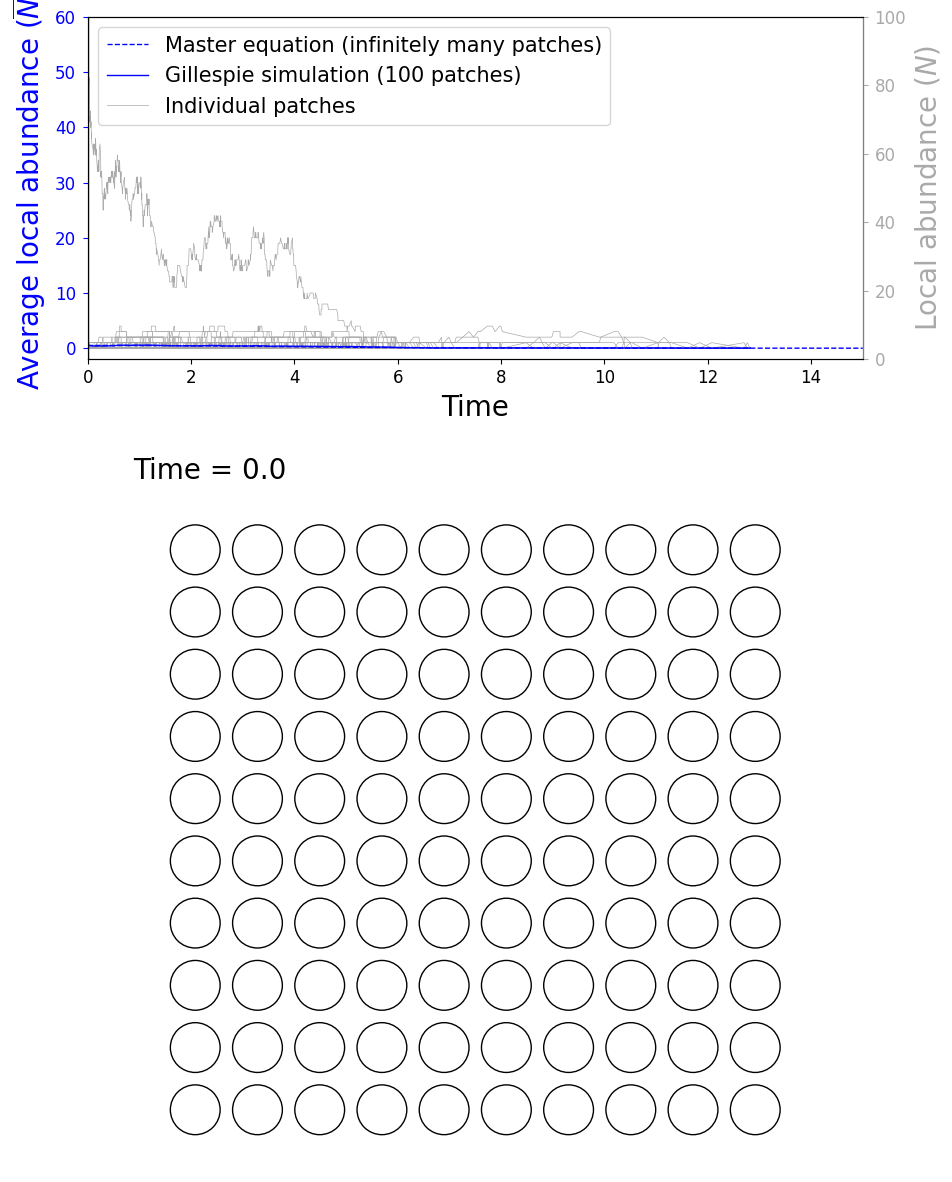

In [22]:
data_regional_AE = pd.read_csv(f'{data_path}\\gillespie_100_patches_m=1.0_A=5_r=1_a=10_K=50_X=0_survivor_frac=1.0.csv')
times_regional_AE = data_regional_AE['time']
populations_regional_AE = data_regional_AE.drop(columns='time').values

# recover complete data from the saved one
mask = np.isnan(populations_regional_AE)
idx = np.where(~mask, np.arange(mask.shape[0])[:, None], 0)
np.maximum.accumulate(idx, axis=0, out=idx)
populations_regional_AE = populations_regional_AE[idx, np.arange(idx.shape[1])]

avg_population = np.sum(populations_regional_AE, axis=1)/100

mastereq_ts = numerically_integrate(m=1., A=5, initial_conditions=np.concatenate(([0.99], np.zeros(49), [0.01], np.zeros(50))),
                                                    r=1., a=10, K=50, x=0., survivor_frac=1., 
                                                    t_span=[0, 15], t_eval=np.linspace(0, 15, 1000), return_ts=True)
avg_population_from_mastereq = np.dot(np.arange(0, 101, 1), mastereq_ts.y/np.sum(mastereq_ts.y, axis=0))

patch_xy = lambda index: (index % 10, index // 10)

fig, ax = plt.subplots(2, 1, figsize=(10, 15), gridspec_kw={'height_ratios': [1, 2], 'hspace': 0.25})
ax0, ax1 = ax

ax2 = ax0.twinx()

for i in range(99):
    ax0.plot(times_regional_AE, populations_regional_AE[:, i], color='darkgrey', linewidth=0.5)
ax0.plot(times_regional_AE, populations_regional_AE[:, 99], color='darkgrey', linewidth=0.5, label='Individual patches')


ax0.plot(times_regional_AE, avg_population, linewidth=1, color='blue', label='Gillespie simulation (100 patches)')
ax0.plot(mastereq_ts.t, avg_population_from_mastereq, linewidth=1, color='blue', linestyle='--',
        label='Master equation (infinitely many patches)')



ax0.set_xlim(0, 15)
ax0.set_ylim(-2, 60)
ax0.tick_params(axis='y', which='major', labelsize=12, colors='blue', pad=5)
ax0.tick_params(axis='x', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12, colors='darkgrey', pad=5)
ax2.set_yticks(np.linspace(0, 100, 6))
ax0.set_xlabel('Time', fontsize=20, labelpad=5)
ax0.set_ylabel(r'Average local abundance ($\overline{N}$)', fontsize=20, labelpad=5, color='blue')
ax2.set_ylabel(r'Local abundance ($N$)', fontsize=20, labelpad=5, color='darkgrey')
handles, labels = ax0.get_legend_handles_labels()
ordered_handles = [handles[2], handles[1], handles[0]]
ordered_labels = [labels[2], labels[1], labels[0]]

ax0.legend(handles=ordered_handles, labels=ordered_labels, fontsize=15, loc='upper left')

ax0.spines['left'].set_color('blue')
ax2.spines['right'].set_color('grey')

ax1.set_xlim(-1, 10)
ax1.set_ylim(-1, 10)
ax1.set_aspect('equal')
ax1.set_axis_off()

radius = 0.4

for i in range(10):
    for j in range(10):
        circle = plt.Circle((i, j), radius, color='k', fill=False)
        ax1.add_patch(circle)

scatter = ax1.scatter([], [], s=2, color='blue')
vl = ax0.axvline(0, -10, 100,  color='red', linestyle='-', linewidth=1)

# we want to plot the populations sizes at the times 0, 1, 2, ..., 100
# so, we calculate the index of the populations array that corresponds to these times
frame_num = 200
times_to_plot = np.linspace(0, 15, frame_num)
indices = np.searchsorted(times_regional_AE, times_to_plot) - 1

rng = np.random.default_rng(seed=69)

def update(frame):  

    x_values = []
    y_values = []

    local_abundances = populations_regional_AE[indices[frame], :].astype(int)

    radius_values = rng.uniform(-0.375, 0.375, np.sum(local_abundances))
    angles = rng.uniform(0, 2*np.pi, np.sum(local_abundances))

    x_values = radius_values * np.cos(angles) + np.repeat(np.tile(np.arange(0, 10), 10), local_abundances)
    y_values = radius_values * np.sin(angles) + np.repeat(np.repeat(np.arange(0, 10), 10), local_abundances)
    
    scatter.set_offsets(np.c_[x_values, y_values])
    vl.set_xdata([times_to_plot[frame], times_to_plot[frame]])

    ax1.set_title(f'Time = {np.around(times_to_plot[frame], 0)}', ha='left', loc='left', fontsize=20)

    return scatter, vl,
    

ani = animation.FuncAnimation(fig, update, frames=frame_num, interval=100)

writer = animation.FFMpegWriter(fps=10, bitrate=1800)
ani.save(f'{fig_path}\\movieS2.mp4', writer=writer)